## Here will be analysis for the first Time Since Infection Paper

#### I will include both the mouse and the monkey analyses here.

### Mouse Analysis

#### Install required packages as needed
- Not all of these installed, but it should be fine for my purposes, I hope
- If note, this github has procedures for making sure R CRAN packages get installed into conda: https://github.com/conda/conda/issues/4355
https://stackoverflow.com/questions/34705917/conda-how-to-install-r-packages-that-are-not-available-in-r-essentials

In [ ]:
# This is the correct way, that I learned in initially doing Monkey analysis in jupyter notebooks
# If I need to update packages, I may need to unlock these packages, as I can't reinstall caret with this code
#conda.r = "/master/rault/miniconda3/lib/R/library"
#install.packages("caret", conda.r)

#install.packages("deepnet", conda.r)
#devtools::install_github('topepo/caret/pkg/caret')
#install.packages("ranger", conda.r)
#install.packages("glmnet", conda.r)
#install.packages("gbm", conda.r)
#install.packages("e1071", conda.r)
#install.packages("mlbench", conda.r)

In [2]:
#source("https://bioconductor.org/biocLite.R")
#biocLite()
#biocLite("Biobase")
# biocLite("GEOquery")
# biocLite("limma")
# biocLite("multtest")
# biocLite("HybridMTest")
# biocLite("MLInterfaces")
# install.packages("scatterplot3d")
# install.packages("rgl")
# install.packages("pheatmap")
# install.packages("dplyr")
# install.packages("gplots")
# install.packages("class")
# install.packages("e1071")
# install.packages("heatmap3")
# install.packages("heatmap.plus")
# install.packages("randomForest")
# install.packages("caret")

#### Load Required Libraries

Loading all the below works, except rgl and MLInterfaces, which I should not need

In [ ]:
#library("randomForest")
#library(gplots)
#require("heatmap.plus")
#require("heatmap3")
#library(Biobase)
#library(GEOquery)
#library(limma)
#library(scatterplot3d)
#library(rgl)
#library(multtest)
#library(pheatmap)
#library(HybridMTest)
#library(class)
#library(MLInterfaces)
#library(e1071)
#library(caret)
#library(repr)
#require(dplyr) # I don't think this is needed absolutely currently

In [645]:
if (!require("preprocessCore")) {
  source("https://bioconductor.org/biocLite.R")
  biocLite("preprocessCore")
  library("preprocessCore")
}
if (!require("GGally")) {
    install.packages("GGally")
    library("GGally")
}
library(ggplot2)
library(randomForest)
library(Biobase)
library(GEOquery)

In [4]:
# Make R graphs smaller
options(repr.plot.width=4, repr.plot.height=3)

#### Set up the environment and load in the data, applying p value of detection to whole dataset with all strains

In [647]:
source("utils.R")
path  = "/master/rault/TB"
data_path = paste(path, "/data/Mouse", sep="")

In [648]:
array_data = read.delim(paste(data_path, "P13_2011DS114_9MouseChips_BM_V4_0_R1_21Jan2011_Norm.txt", sep="/"))
QC_data = read.delim(paste(data_path,"P13_2011DS114_9MouseChips_BM_V4_0_R1_21Jan2011_QC.txt", sep="/"), header=T, skip = 8)
RNA_QC = read.delim(paste(data_path,"P13_TB_Mice_RNA QC.txt", sep="/"), header=T)
mousechip_conv = read.delim(paste(data_path,"Mousechip.txt", sep="/"), header=T)
pheno_data = read.delim(paste(data_path,"BV microarray for Baylor Annotation_Clinical.txt", sep="/"), header=T)

In [649]:
colnames(pheno_data)[1] = "Sample.Group"
pheno_data$chip.name = paste("M#", pheno_data$Donor.ID, "OSU", sep="")

In [650]:
eset = make.expression.set(array_data, pheno_data, mousechip_conv)
eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 17275 features, 50 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: M#11OSU M#12OSU ... M#72OSU (50 total)
  varLabels: Strain Infect.Status Time.point.days
  varMetadata: M#11OSU M#12OSU ... labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

#### Select only C57BL/6 mice and quantile normalize their arrays

Warning message in boxplot(log2(exprs(eset.B6) + 1), ylim = c(4, 10)):
“NaNs produced”

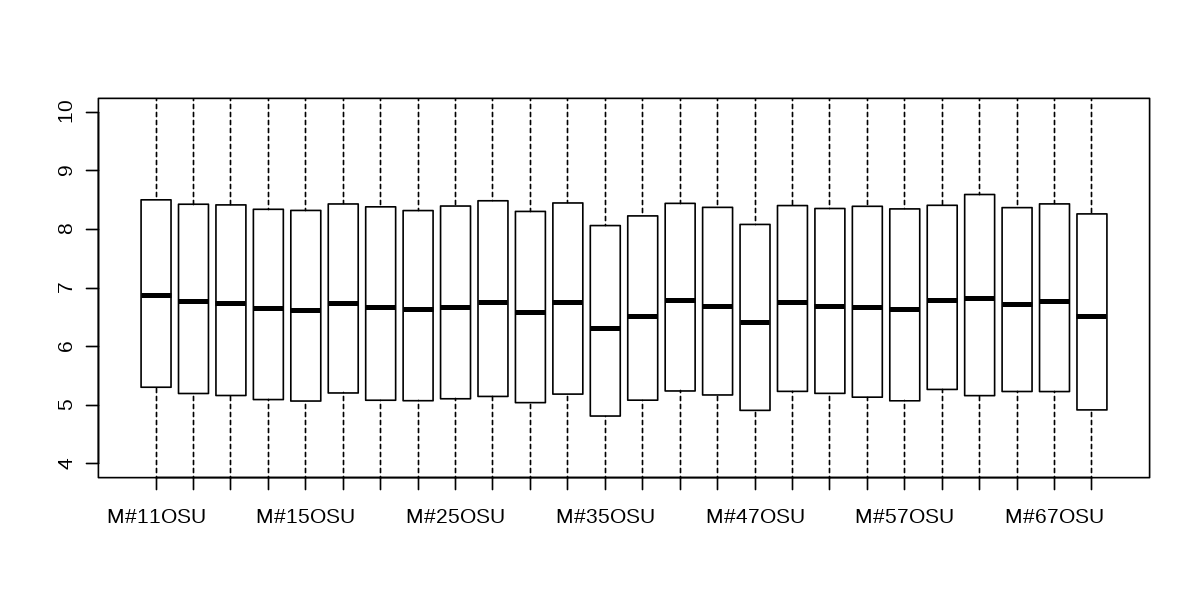

In [651]:
eset.B6 = eset[, eset$Strain=="C57BL/6"]
boxplot(log2(exprs(eset.B6) + 1), ylim=c(4,10))

Warning message in boxplot(log2(exprs(qn) + 1), ylim = c(4, 10)):
“NaNs produced”

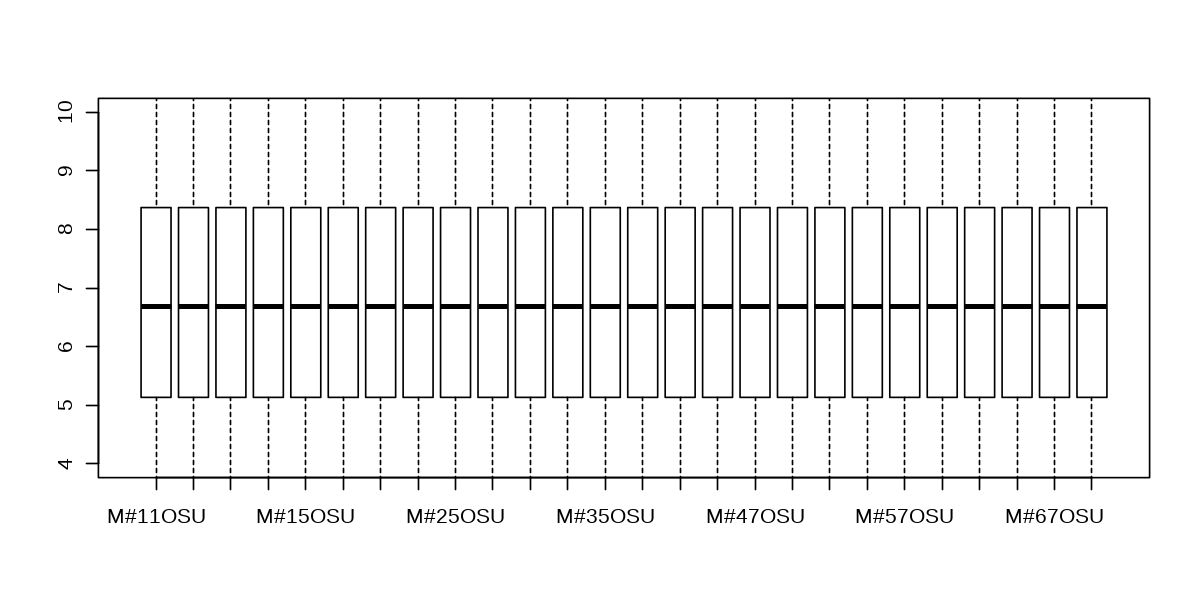

In [652]:
qn = eset.B6
exprs(qn) = normalize.quantiles(exprs(eset.B6))
boxplot(log2(exprs(qn)+1), ylim = c(4, 10))

In [64]:
# To do percentile normalization, may want to multiply by a ratio to get back to original scale for later functions, or just do everything on log scale

#per75 = apply(exprs(eset.B6.med), 2, quantile, 0.50)
#exprs(eset.B6.med) <- sweep(exprs(eset.B6.med), 2, per75, "/" )
#boxplot(exprs(eset.B6.med), ylim = c(0, 2))

#### Now find genes that are 2-fold changed from median in 10% of samples (basic filtering) and log2 transform the data

In [653]:
eset.B6.2xUDALO = normalization(qn)
exprs(eset.B6.2xUDALO) = log2(exprs(eset.B6.2xUDALO) + 1)
#boxplot(exprs(eset.B6.2xUDALO), ylim = c(4,10))   # Now not perfectly distributed because we filtered the variable genes

[1] "1717 genes passed the 2 fold change from median in 10% of samples filter"


#### We now have the detected genes from all mice and variable genes within the C57BL/6 mice 
#### Now do PCA and graph the results by M.tb infection status and time point.

In [20]:
PCA.B6 = prcomp(t(exprs(eset.B6.2xUDALO)), scale.=T)

In [21]:
gg.PCA.B6.inf = as.data.frame(PCA.B6$x[,1:5])
gg.PCA.B6.days = gg.PCA.B6.inf
gg.PCA.B6.inf$Infect.Status = eset.B6.2xUDALO$Infect.Status
gg.PCA.B6.days$Time.point.days = as.character(eset.B6.2xUDALO$Time.point.days)



#data.frame(PCA.B6$x[,1:2], Infect.Status=eset.B6.2xUDALO$Infect.Status)

##### In the dataset of all C57BL/6 mice, the first principle component clearly separates infected from uninfected mice. No other principle component separates these groups

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


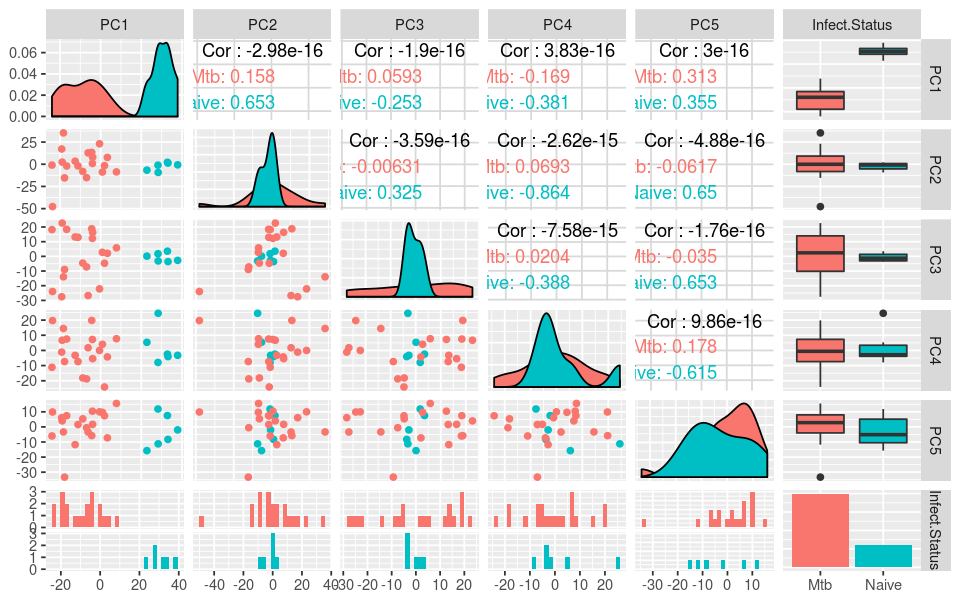

In [22]:
options(repr.plot.width=8, repr.plot.height=5)
print(ggpairs(gg.PCA.B6.inf, aes(colour = Infect.Status)))

##### This graph tells me that a combination of PCA1 and PCA3 separates the time periods in C57BL/6 mice. MaybeI should do a PCA only in infected mice too to show this point. Groups of 3 of all time points cluster alone on this plot, suggesting leave 1-out cross-validation could give better prediction, but I will keep 3-fold to not overfit.
- Also I think base R will make a better, cleaner figure for publication. But this package works very well for visualization.
- I think I could have 2 separate figures in Figure 1, one to show that all the infect and uninfect are different. One to show the time points within the infected group.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


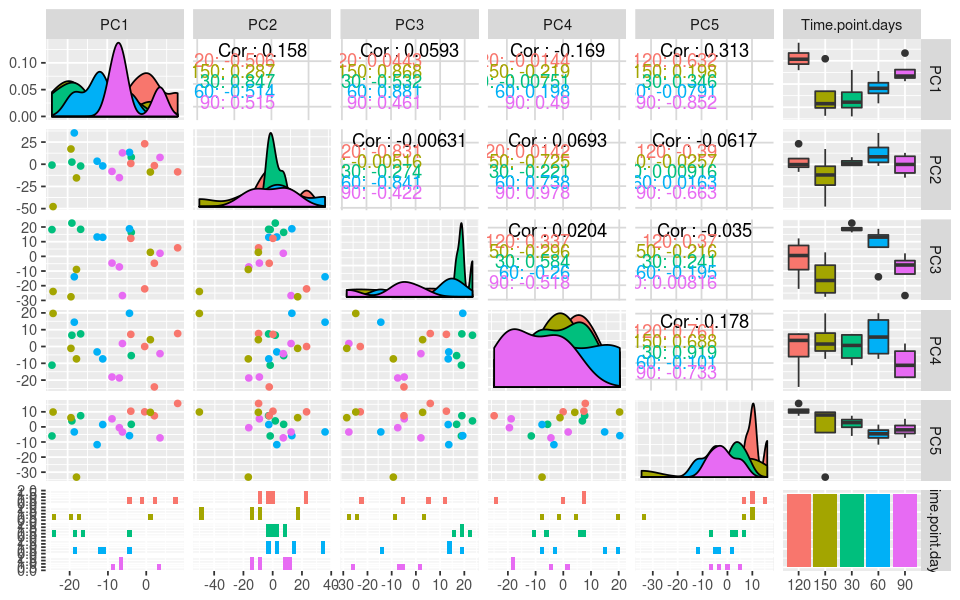

In [23]:
options(repr.plot.width=8, repr.plot.height=5)
gg.PCA.B6.Mtb = gg.PCA.B6.days[eset.B6.2xUDALO$Infect.Status == "Mtb",]
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Time.point.days)))

##### Here is PCA only in Infected mice, to visualize the time point separations without the effect of infection. Here a combination of principle component 1 & 2 separate these time points, with principle component 1 doing most of the separation. Therefore, time point explains most of the variation of the data within M.tb infected mice

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


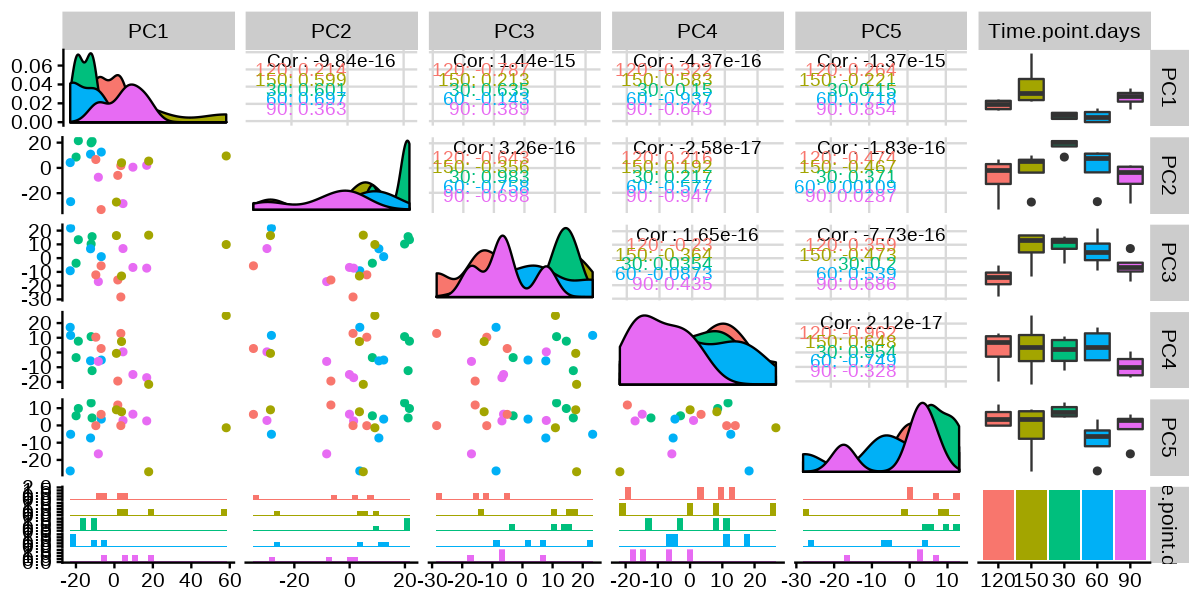

In [655]:
eset.B6.Mtb = eset.B6.2xUDALO[,eset.B6.2xUDALO$Infect.Status == "Mtb"]
PCA.B6.Mtb = prcomp(t(exprs(eset.B6.Mtb)), scale.=T)
gg.PCA.B6.Mtb = as.data.frame(PCA.B6.Mtb$x[,1:5])
gg.PCA.B6.Mtb$Time.point.days = as.character(eset.B6.Mtb$Time.point.days)
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Time.point.days)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


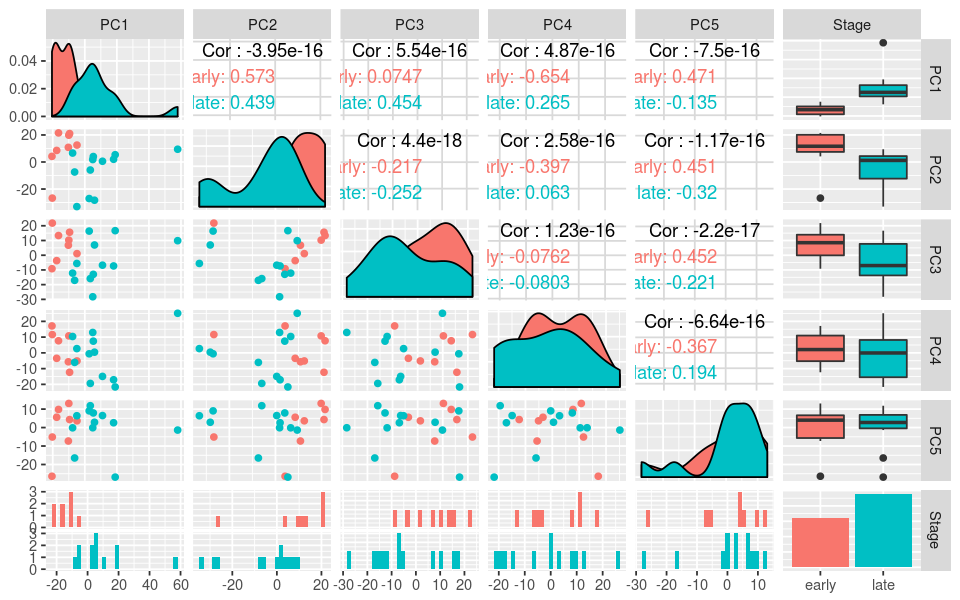

In [25]:
stage = ifelse(eset.B6.Mtb$Time.point.days <= 60,
               "early",
               "late")
gg.PCA.B6.Mtb = as.data.frame(PCA.B6.Mtb$x[,1:5])
gg.PCA.B6.Mtb$Stage = stage
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Stage)))

#### Exploratory PCA showed that the 2 major sources of variation in the data are 1) Whether mice were infected and 2) Were mice infected for 1-2 mo. vs. 3-5 mo. Now I will make the PCA graphs for Figure 1 of the paper, focusing on these two points

#### I will worry about putting the two plots into a nice figure later, after the machine learning

In [ ]:
eset.B6.Mtb = eset.B6.2xUDALO[,eset.B6.2xUDALO$Infect.Status == "Mtb"]
PCA.B6.Mtb = prcomp(t(exprs(eset.B6.Mtb)), scale.=T)
gg.PCA.B6.Mtb = as.data.frame(PCA.B6.Mtb$x[,1:5])
gg.PCA.B6.Mtb$Time.point.days = as.character(eset.B6.Mtb$Time.point.days)
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Time.point.days)))
stage = ifelse(eset.B6.Mtb$Time.point.days <= 60,
               "early",
               "late")
gg.PCA.B6.Mtb = as.data.frame(PCA.B6.Mtb$x[,1:5])
gg.PCA.B6.Mtb$Stage = stage
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Stage)))

In [91]:
#summary(PCA.B6.Mtb)
#PCA.B6.Mtb

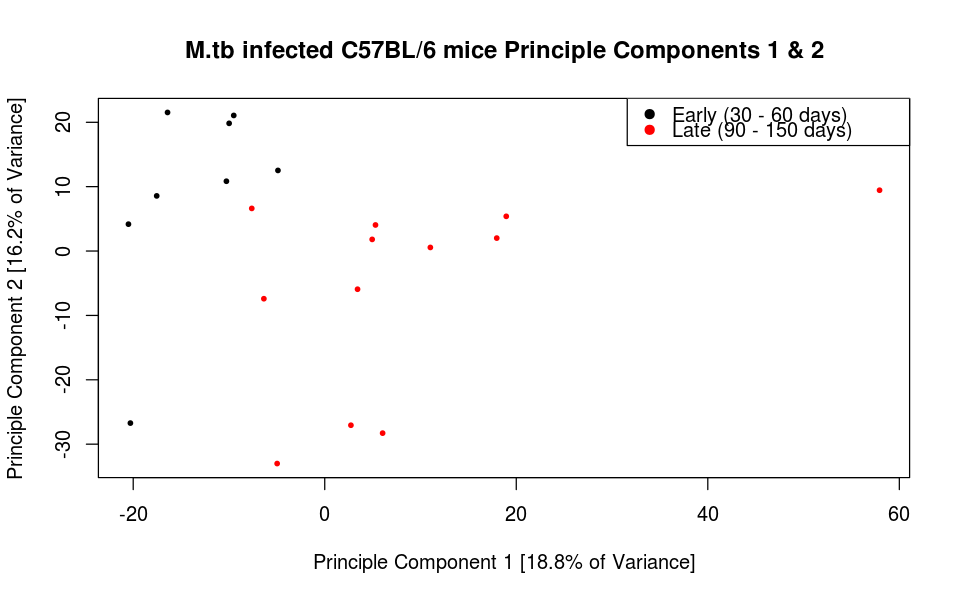

In [50]:
# Still need to put in the variance explained and also separate the legend a little. Ggplot might honestly give a better equivalent 
eset.B6.Mtb = eset.B6.2xUDALO[,eset.B6.2xUDALO$Infect.Status == "Mtb"]
PCA.B6.Mtb = prcomp(t(exprs(eset.B6.Mtb)), scale.=T)

std_dev = PCA.B6.Mtb$sdev
pr_var = std_dev^2
prop_varex = pr_var / sum(pr_var)

stage = ifelse(eset.B6.Mtb$Time.point.days <= 60,
               "early",
               "late")

plot(PCA.B6.Mtb$x[,"PC1"], PCA.B6.Mtb$x[,"PC2"], pch=19,
    cex=0.5, col=as.factor(stage),
     xlab=paste("Principle Component 1 [", format(prop_varex[1]*100, digits=3, nsmall=1), "% of Variance]", sep=""),
     ylab=paste("Principle Component 2 [", format(prop_varex[2]*100, digits=3, nsmall=1), "% of Variance]", sep=""),
     main="M.tb infected C57BL/6 mice Principle Components 1 & 2")
legend("topright", legend=c('Early (30 - 60 days)', 'Late (90 - 150 days)'), col=c("black", "red"), pch=19)

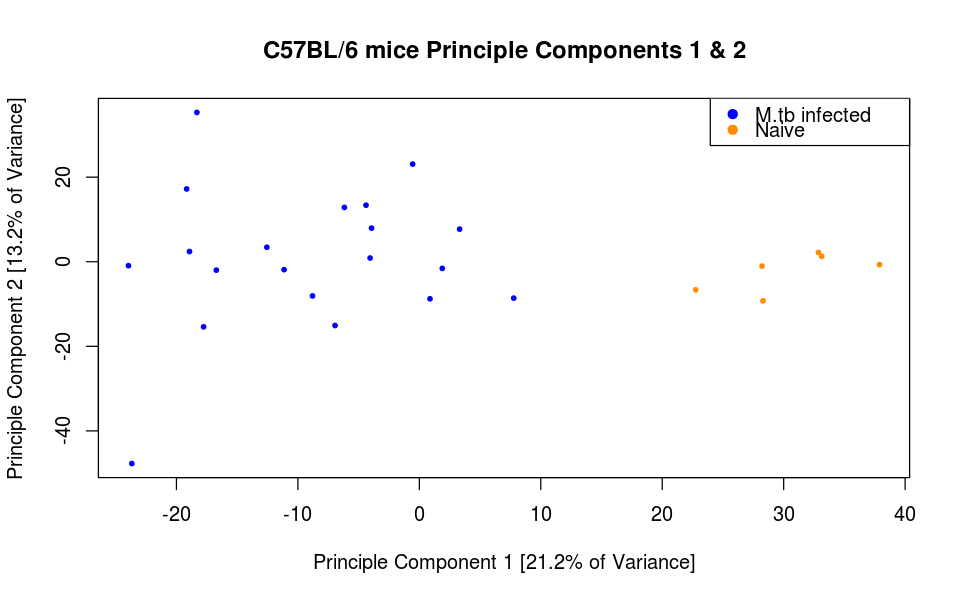

In [52]:

std_dev = PCA.B6$sdev
pr_var = std_dev^2
prop_varex = pr_var / sum(pr_var)

plot(gg.PCA.B6.inf$PC1, gg.PCA.B6.inf$PC2, pch=19,
     cex=0.5, col=ifelse(gg.PCA.B6.inf$Infect.Status=="Mtb", "blue", "darkorange"),
     xlab=paste("Principle Component 1 [", format(prop_varex[1]*100, digits=3, nsmall=1), "% of Variance]", sep=""),
     ylab=paste("Principle Component 2 [", format(prop_varex[2]*100, digits=3, nsmall=1), "% of Variance]", sep=""),
     main="C57BL/6 mice Principle Components 1 & 2")
legend("topright", legend=c('M.tb infected', 'Naive'), col=c("blue", "darkorange"), pch=19)

##### The code below is from one of my BMI 8050 homeworks, demonstrating plotting of PCA data

In [ ]:
plot(PCA.B6.Mtb$x[,"PC1"], PCA.B6.Mtb$x[,"PC2"], pch=19,
    cex=0.5, col=PCA.B6.Mtb$,
     xlab="Principle Component 1",
     ylab="Principle Component 2",
     main="M.tb infected C57BL/6 mice Principle Components 1 & 2")

In [ ]:
# 3 (b) Plot the cancer samples according to the first two principle components and visually cluster the data

df = data.frame(x=tcga_PCA$x[,"PC1"], y=tcga_PCA$x[,"PC2"])
commonTheme = list(labs(color="Density",fill="Density",
                        x="Principle Component 1",
                        y="Principle Component 2"),
                   theme_bw(),
                   theme(legend.position=c(0,1),
                         legend.justification=c(0,1)))

ggplot(data=df,aes(x,y)) + 
  geom_density2d(aes(colour=..level..)) + 
  scale_colour_gradient(low="green",high="red") + 
  geom_point() + commonTheme + ggtitle("Density Contour Map of Breast Cancer Samples by Principle Components 1 & 2")

In [ ]:
plot(tcga_PCA$x[,"PC1"], tcga_PCA$x[,"PC2"], pch=19, 
     cex=0.5, col=ifelse(tcga_PCA$x[,"PC1"] < my_cutoff, "blue", "red"),
     xlab="Principle Component 1",
     ylab="Principle Component 2",
     main="Breast Cancer Samples along Principle Components 1 & 2") 
legend("topright", legend=c('My cluster 1', 'My cluster 2'), col=c("blue", "red"), pch=19)

#### Now do Random Forests Classification and Regression on the C57BL/6 infected Mouse data

##### Classification

In [81]:
set.seed(100)
stage = ifelse(eset.B6.Mtb$Time.point.days <= 60,
               "early",
               "late")

B6.table.class = as.data.frame(t(exprs(eset.B6.Mtb)))
B6.table.class$stage = as.factor(stage)
B6.rf.class = randomForest(stage~., data=B6.table.class)

I should potentially do more work to make the table prettier and to make sure whether predictions are on the x or y axis of the table, but this result perfectly replicates what I have seen before, so I'm perfectly fine with it.

I'll have to dig more into the details when I analyze feature importance, etc.

In [82]:
B6.rf.class


Call:
 randomForest(formula = stage ~ ., data = B6.table.class) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 41

        OOB estimate of  error rate: 10%
Confusion matrix:
      early late class.error
early     7    1  0.12500000
late      1   11  0.08333333

##### Regression - the result is more dramatic with the filtering I did solely within B6 mice. Maybe filtering within only infected mice could improve results even further?
- I may need to do a transformation of the predictions to get them into a better scale
- What about doing the 5-way classification too? Could that help confirm what I am seeing?

In [656]:
# Great website for tutorial in random forests for tuning 
# http://machinelearningmastery.com/tune-machine-learning-algorithms-in-r/
B6.table.regress = as.data.frame(t(exprs(eset.B6.Mtb)))
B6.table.regress$Time.point.days = eset.B6.Mtb$Time.point.days
#C57.table = make.data.frame(exprs(C57.el.eset), C57.el.eset$Time.point.days, 
#                            "Time.point.days")
B6.table.class5 = B6.table.regress
B6.table.class5$Time.point.days = as.factor(B6.table.regress$Time.point.days)
#summary(exprs(C57.el.eset)[3,])
#summary(C57.table[,4])

#summary(C57.table[,])

In [657]:
set.seed(100)
B6.rf.class5 = randomForest(Time.point.days~., data=B6.table.class5)
B6.rf.class5


Call:
 randomForest(formula = Time.point.days ~ ., data = B6.table.class5) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 41

        OOB estimate of  error rate: 75%
Confusion matrix:
    30 60 90 120 150 class.error
30   3  1  0   0   0        0.25
60   3  1  0   0   0        0.75
90   0  0  0   2   2        1.00
120  0  0  3   1   0        0.75
150  0  0  3   1   0        1.00

In [678]:
set.seed(100)
C57.rf.regres = randomForest(Time.point.days~., data=B6.table.regress, importance=T)

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”

In [659]:
str(C57.rf.regres)

List of 18
 $ call           : language randomForest(formula = Time.point.days ~ ., data = B6.table.regress)
 $ type           : chr "regression"
 $ predicted      : Named num [1:20] 58.2 69.3 58.3 63.3 69 ...
  ..- attr(*, "names")= chr [1:20] "M#23OSU" "M#24OSU" "M#25OSU" "M#26OSU" ...
 $ mse            : num [1:500] 1350 1491 1360 1003 851 ...
 $ rsq            : num [1:500] 0.25 0.172 0.245 0.443 0.527 ...
 $ oob.times      : int [1:20] 193 178 182 172 189 187 167 166 182 181 ...
 $ importance     : num [1:1717, 1] 43.74 9.62 47.61 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:1717] "ILMN_2543688" "ILMN_2435996" "ILMN_2480021" "ILMN_2734484" ...
  .. ..$ : chr "IncNodePurity"
 $ importanceSD   : NULL
 $ localImportance: NULL
 $ proximity      : NULL
 $ ntree          : num 500
 $ mtry           : num 572
 $ forest         :List of 11
  ..$ ndbigtree    : int [1:500] 9 9 7 9 7 9 9 7 9 7 ...
  ..$ nodestatus   : int [1:11, 1:500] -3 -3 -3 -1 -3 -1 -1 -1 -1 0 ...
  ..$

M#23OSU   M#24OSU   M#25OSU   M#26OSU    M#7OSU   M#32OSU   M#35OSU   M#36OSU 
 58.23057  69.25562  58.27473  63.30523  68.97619  73.54813  81.82335  75.65361 
   M#8OSU   M#43OSU   M#47OSU   M#48OSU   M#55OSU   M#56OSU   M#57OSU   M#58OSU 
113.24451 115.25967  96.65556 112.77714 109.00588 112.12500  82.42896 101.38564 
  M#10OSU   M#66OSU   M#67OSU   M#69OSU 
109.14368  98.16149 107.34359  86.98098

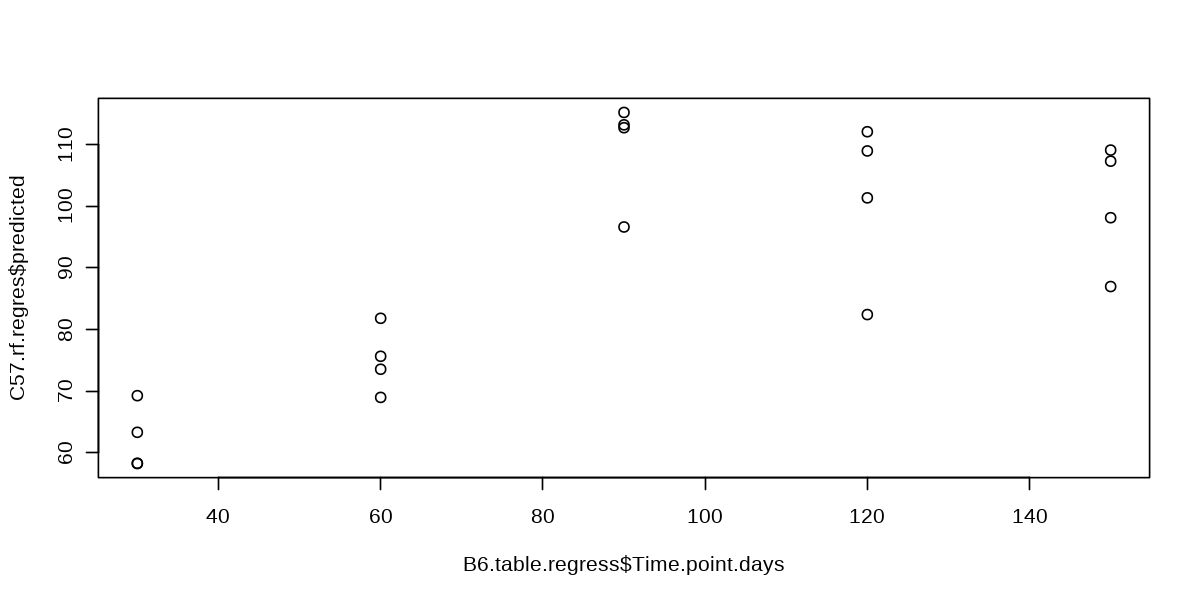

In [660]:
C57.rf.regres$predicted
plot(B6.table.regress$Time.point.days, C57.rf.regres$predicted)

In [665]:
predictions = data.frame(C57.predicted=C57.rf.regres$predicted, C57.Time.point.days = B6.table.regress$Time.point.days)
set.seed(103)
q = qplot(C57.Time.point.days, C57.predicted, data= predictions, geom = c("point", "smooth"), method="loess")

Warning message:
“Ignoring unknown parameters: method”

In [726]:
dim(B6.table.regress)

[1]   20 1718

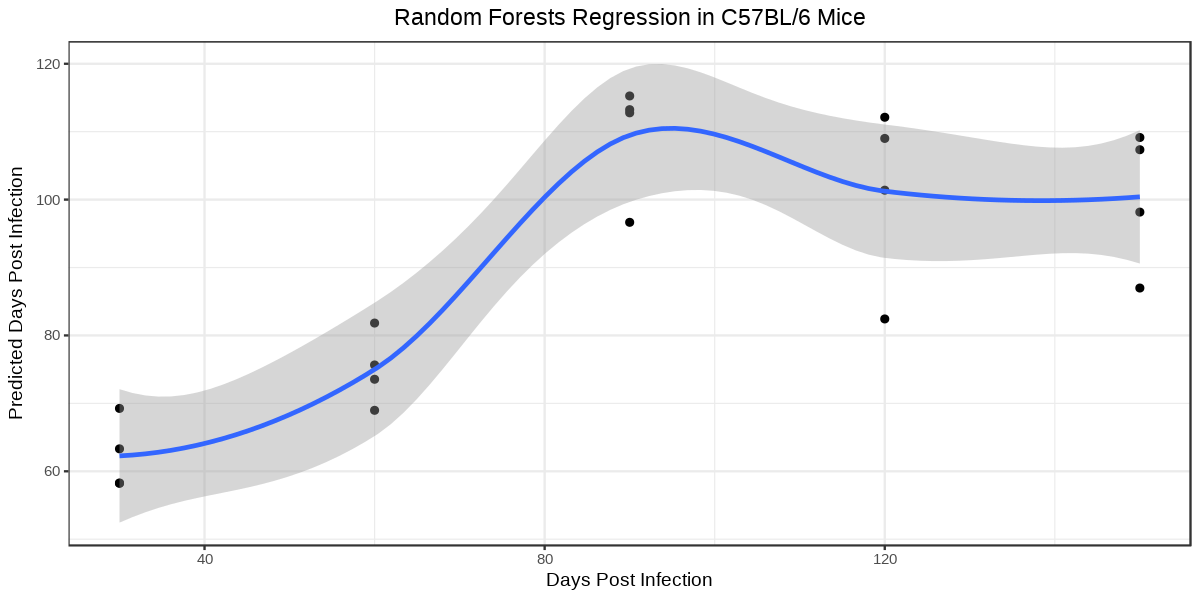

In [666]:
q + theme_bw() + 
  labs(x="Days Post Infection", y="Predicted Days Post Infection") + 
  ggtitle("Random Forests Regression in C57BL/6 Mice") +
  theme(plot.title = element_text(hjust = 0.5))

###### Rerun in the regression with only using the 50 most important genes using the MSE score
- The conclusion from the graph is the same whether using all 9050 genes, the 50 most important genes, the 10 most important genes or even the 5 most important genes, although the shape of the fit line changes with 5 because 1 30 day sample gets predicted later than all 60 days. The expression of just 1 gene, ILMN_1234749, gives the same conclusion as 9050 genes, although it has the same 1 sample anomaly at 30 days

In [730]:
# Rerun random forests with cross-validation using the most important features selected
set.seed(100)
C57.rf.regres.imp = randomForest(Time.point.days~., data=B6.table.regress, importance=T)
B6.regres.imp = data.frame(importance(C57.rf.regres.imp))
impvar = rownames(B6.regres.imp)[order(B6.regres.imp[,1], decreasing=TRUE)]

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”

In [731]:
impvar

[1] "ILMN_1234749" "ILMN_1240605" "ILMN_2740902" "ILMN_1248413"
   [5] "ILMN_1217247" "ILMN_2603699" "ILMN_2471161" "ILMN_3161906"
   [9] "ILMN_2714565" "ILMN_2819319" "ILMN_2911009" "ILMN_2741985"
  [13] "ILMN_1253984" "ILMN_2526836" "ILMN_2921303" "ILMN_1225182"
  [17] "ILMN_2922942" "ILMN_1223028" "ILMN_1218967" "ILMN_1255053"
  [21] "ILMN_2539917" "ILMN_2895284" "ILMN_2484707" "ILMN_2762326"
  [25] "ILMN_1227024" "ILMN_2606804" "ILMN_1252295" "ILMN_1217386"
  [29] "ILMN_2632153" "ILMN_2867901" "ILMN_2756704" "ILMN_1229500"
  [33] "ILMN_2420939" "ILMN_2982019" "ILMN_1222380" "ILMN_1213191"
  [37] "ILMN_1248849" "ILMN_2446999" "ILMN_2707181" "ILMN_2639012"
  [41] "ILMN_2706819" "ILMN_3127335" "ILMN_2762983" "ILMN_1252006"
  [45] "ILMN_2593631" "ILMN_2711112" "ILMN_2776857" "ILMN_2991272"
  [49] "ILMN_1257574" "ILMN_1248830" "ILMN_1242258" "ILMN_2625601"
  [53] "ILMN_2656021" "ILMN_1246004" "ILMN_1241039" "ILMN_1217577"
  [57] "ILMN_2711355" "ILMN_1219574" "ILMN_1253384" "ILMN_2670368"
  [61] "ILMN_2629581" "ILMN_2628708" "ILMN_2481391" "ILMN_1259252"
  [65] "ILMN_1246270" "ILMN_1220039" "ILMN_2688912" "ILMN_2655862"
  [69] "ILMN_2454339" "ILMN_2608719" "ILMN_2593994" "ILMN_2944755"
  [73] "ILMN_2657844" "ILMN_2970532" "ILMN_2756046" "ILMN_1223045"
  [77] "ILMN_1244454" "ILMN_3161959" "ILMN_2802311" "ILMN_2514749"
  [81] "ILMN_1237804" "ILMN_2659317" "ILMN_3157081" "ILMN_2688262"
  [85] "ILMN_1240819" "ILMN_2747641" "ILMN_2633179" "ILMN_2636110"
  [89] "ILMN_2480021" "ILMN_2719473" "ILMN_2652482" "ILMN_2445789"
  [93] "ILMN_2581419" "ILMN_2685921" "ILMN_1242553" "ILMN_1226839"
  [97] "ILMN_2964324" "ILMN_1229210" "ILMN_2575986" "ILMN_2632712"
 [101] "ILMN_2420353" "ILMN_2747959" "ILMN_1216107" "ILMN_1239314"
 [105] "ILMN_2854962" "ILMN_2589640" "ILMN_2737523" "ILMN_2748880"
 [109] "ILMN_2612206" "ILMN_1226979" "ILMN_2475271" "ILMN_2725595"
 [113] "ILMN_2742626" "ILMN_3071356" "ILMN_2507232" "ILMN_2543393"
 [117] "ILMN_3111744" "ILMN_1223979" "ILMN_2619107" "ILMN_2681241"
 [121] "ILMN_2959372" "ILMN_2836749" "ILMN_2685392" "ILMN_2636004"
 [125] "ILMN_1246446" "ILMN_2524667" "ILMN_2555071" "ILMN_3155815"
 [129] "ILMN_1249864" "ILMN_1233713" "ILMN_2500533" "ILMN_2962737"
 [133] "ILMN_2676056" "ILMN_1249378" "ILMN_2568571" "ILMN_1255190"
 [137] "ILMN_2646052" "ILMN_3043036" "ILMN_2595477" "ILMN_2833652"
 [141] "ILMN_2644708" "ILMN_2629663" "ILMN_2652877" "ILMN_2815506"
 [145] "ILMN_1235488" "ILMN_1244513" "ILMN_2793638" "ILMN_1221028"
 [149] "ILMN_2736489" "ILMN_2729197" "ILMN_2981801" "ILMN_1249824"
 [153] "ILMN_2682613" "ILMN_1255514" "ILMN_2773153" "ILMN_2691014"
 [157] "ILMN_2605201" "ILMN_2648475" "ILMN_2536184" "ILMN_1223708"
 [161] "ILMN_2652500" "ILMN_2589073" "ILMN_2798993" "ILMN_1247787"
 [165] "ILMN_2577039" "ILMN_2621021" "ILMN_1227403" "ILMN_2662450"
 [169] "ILMN_2731901" "ILMN_2772632" "ILMN_3163124" "ILMN_2605465"
 [173] "ILMN_1247947" "ILMN_2601378" "ILMN_2426853" "ILMN_3161250"
 [177] "ILMN_2543688" "ILMN_2435996" "ILMN_1219084" "ILMN_2706468"
 [181] "ILMN_2522460" "ILMN_1244904" "ILMN_2427777" "ILMN_2736038"
 [185] "ILMN_2473811" "ILMN_1227464" "ILMN_1233811" "ILMN_1216275"
 [189] "ILMN_2748150" "ILMN_2513205" "ILMN_2788036" "ILMN_2595597"
 [193] "ILMN_2718681" "ILMN_1252111" "ILMN_1233759" "ILMN_2910684"
 [197] "ILMN_1222069" "ILMN_2591592" "ILMN_2660555" "ILMN_2648346"
 [201] "ILMN_2825826" "ILMN_2710286" "ILMN_1216584" "ILMN_2567911"
 [205] "ILMN_3070701" "ILMN_2674140" "ILMN_2698767" "ILMN_2787871"
 [209] "ILMN_1243616" "ILMN_1234999" "ILMN_2821788" "ILMN_1230853"
 [213] "ILMN_1228320" "ILMN_2615920" "ILMN_1258341" "ILMN_2687165"
 [217] "ILMN_2653132" "ILMN_2600964" "ILMN_2858359" "ILMN_1223929"
 [221] "ILMN_1239933" "ILMN_2599527" "ILMN_1244797" "ILMN_1218547"
 [225] "ILMN_2708920" "ILMN_2692316" "ILMN_2550962" "ILMN_1256943"
 [229] "ILMN_2604423" "ILMN_1219258" "ILMN_2641038" "ILMN_2770968"
 [233] "ILMN_2663604" "ILMN_2610944" "ILMN_1244866" "ILMN_2862465"
 [237] "ILMN_2787817" "ILMN_2901112" "ILMN_1219670

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”Warning message:
“Ignoring unknown parameters: method”

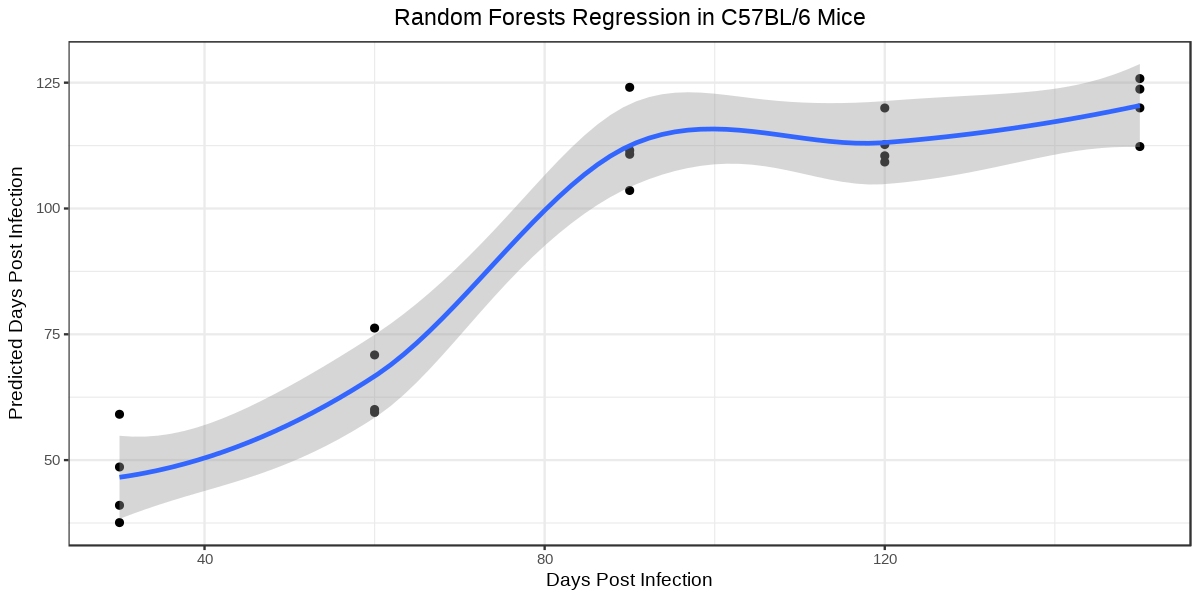

In [725]:
B6.table.regress.onlyimp = B6.table.regress[,colnames(B6.table.regress) %in% c(impvar[1:50], "Time.point.days")]
C57.rf.regress.onlyimp = randomForest(Time.point.days~., data=B6.table.regress.onlyimp, importance=T)
predictions.imp = data.frame(C57.predicted=C57.rf.regress.onlyimp$predicted, C57.Time.point.days = B6.table.regress.onlyimp$Time.point.days)
set.seed(103)
q.imp = qplot(C57.Time.point.days, C57.predicted, data= predictions.imp, geom = c("point", "smooth"), method="loess")
q.imp + theme_bw() + 
  labs(x="Days Post Infection", y="Predicted Days Post Infection") + 
  ggtitle("Random Forests Regression in C57BL/6 Mice") +
  theme(plot.title = element_text(hjust = 0.5))

In [ ]:
imp.genes = rownames(B6.regres.imp$X.IncMSE)
varImpPlot(C57.rf.regres,type=2)

ozone.rf <- randomForest(Ozone ~ ., airquality, importance=TRUE)
imp <- importance(ozone.rf)
impvar <- rownames(imp)[order(imp[, 1], decreasing=TRUE)]

In [90]:
reg.graph.f = "Random Forests Regression of Time pi in C57BL-6 mice_29Aug2017.pdf"
pdf(reg.graph.f, width=7, height=5)
q + theme_bw() + 
  labs(x="Days Post Infection", y="Predicted Days Post Infection") + 
  ggtitle("Random Forests Regression in C57BL/6 Mice") +
  theme(plot.title = element_text(hjust = 0.5))
dev.off()

png 
  2

### Monkey Analysis

#### Load additional required libraries

In [7]:
source("https://bioconductor.org/biocLite.R")
if (!require(Biobase)) {
  biocLite("Biobase")
  library(Biobase)
}
if (!require(GEOquery)) {
  biocLite("GEOquery")
  library(GEOquery)
}

if (!require(sva)) {
  biocLite("sva")
  library(sva)
}

if (!require(randomForest)) {
  install.packages("randomForest")
  library(randomForest)
}

if (!require(ggplot2)) {
  install.packages("ggplot2")
  library(ggplot2)
}

if (!require("glmnet")) {
  install.packages("glmnet")
  library("glmnet")
}

if (!require("GGally")) {
  install.packages("GGally")
  library("GGally")
}
if (!require("caret")) {
  install.packages("caret")
  library("caret")
}
if (!require("dplyr")) {
  install.packages("dplyr")
  library("dplyr")
}
if (!require("xgboost")) {
  install.packages("xgboost")
  library("xgboost")
}
if (!require("deepnet")) {
  install.packages("deepnet")
  library("deepnet")
}
if (!require("doParallel")) {
  install.packages("doParallel")
  library("doParallel")
}

if (!require("cowplot")) {
  install.packages("cowplot")
  library("cowplot")
}



Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,

#### Load data with batch correction and variable gene selection already performed

In [6]:
source("utils.R")
path  = "/master/rault/TB"
monkey_path = paste(path, "/data/Gideon_et_al_Monkey_Data", sep="")

In [7]:
# b_corr_monkey = read.table(file=paste(monkey_path, "ExpressionData_batchedall.txt", sep="/"), header=T, sep="\t")
monkey_var_genes = read.table(file=paste(monkey_path, "ExpressionData_batchcorrected_variablegenes.txt", sep="/"), header=T, sep="\t")
pheno = read.table(file = paste(monkey_path, "PhenoData_filtered.txt", sep="/"), header=T, sep="\t")

In [14]:
pheno$time.period = as.factor(ifelse(pheno$time.point < 3,
                               "pre.infect",
                               ifelse(pheno$time.point <= 10,
                                      "early", 
                                      ifelse(pheno$time.point >= 90,
                                             "late",
                                             "middle"))))

#### Perform PCA and explore separation of time periods and points graphically

In [15]:
PCA.monkey = prcomp(t(monkey_var_genes), scale.=T)

In [16]:
gg.PCA.monkey.period = as.data.frame(PCA.monkey$x[,1:5])
gg.PCA.monkey.period$time.period = pheno$time.period
gg.PCA.monkey.period$time.period = as.character(gg.PCA.monkey.period$time.period)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


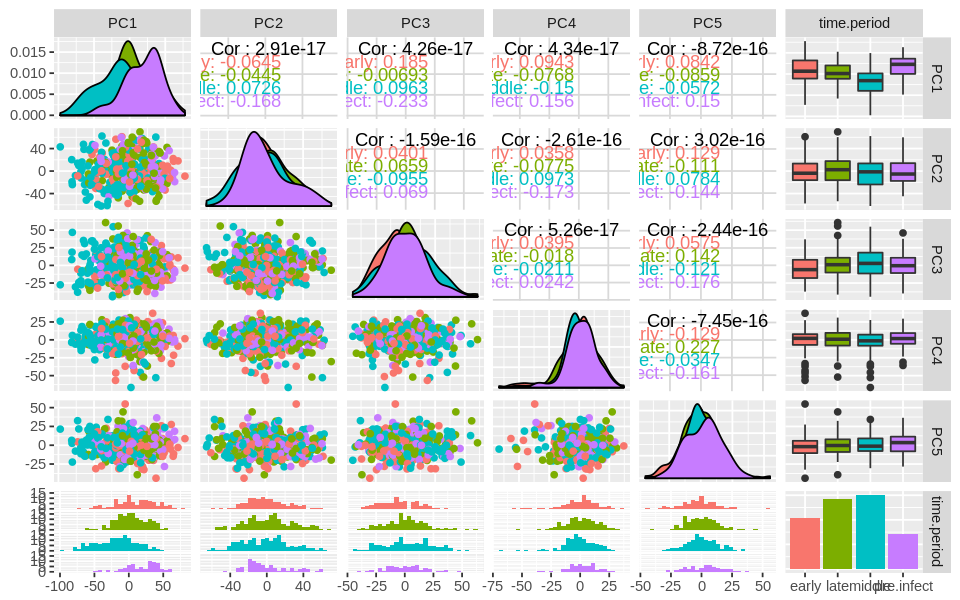

In [18]:
options(repr.plot.width=8, repr.plot.height=5)
print(ggpairs(gg.PCA.monkey.period, aes(colour = time.period)))


#data.frame(PCA.B6$x[,1:2], Infect.Status=eset.B6.2xUDALO$Infect.Status)

##### Now we will do PCA with only the infected groups, and then only the middle and late time point

In [19]:
m_infected = monkey_var_genes[, pheno$time.period != "pre.infect"]
m_middle_late = monkey_var_genes[, pheno$time.period %in% c("middle", "late")]
PCA.monkey_infect = prcomp(t(m_infected ), scale.=T)
PCA.monkey_middle_late = prcomp(t(m_middle_late ), scale.=T)

##### PCA of all time periods post-infection

In [20]:
gg.PCA.monkey.infect = as.data.frame(PCA.monkey_infect$x[,1:5])
gg.PCA.monkey.infect$time.period = pheno[pheno$time.period != "pre.infect",]$time.period
gg.PCA.monkey.infect$time.period = as.character(gg.PCA.monkey.infect$time.period)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


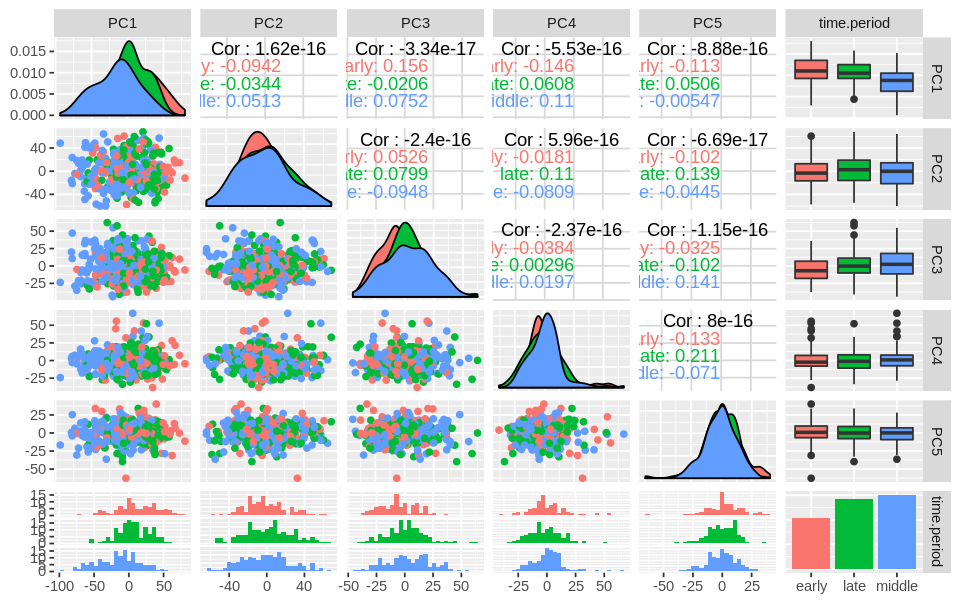

In [21]:
print(ggpairs(gg.PCA.monkey.infect, aes(colour = time.period)))

##### PCA of middle and late time periods post-infection

In [22]:
gg.PCA.monkey.m_l = as.data.frame(PCA.monkey_middle_late$x[,1:5])
gg.PCA.monkey.m_l$time.period = pheno[pheno$time.period  %in% c("middle", "late"),]$time.period
gg.PCA.monkey.m_l$time.period = as.character(gg.PCA.monkey.m_l$time.period)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


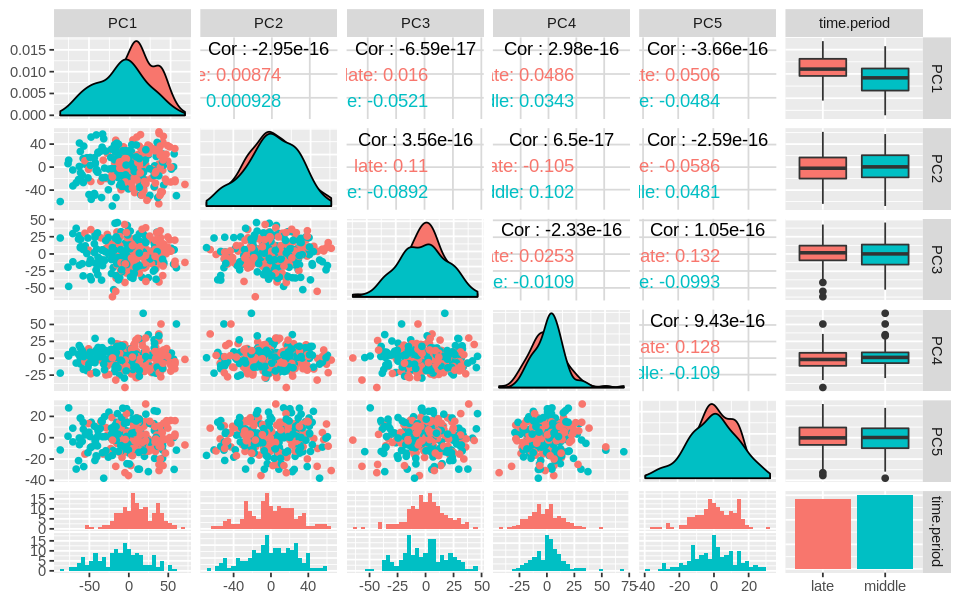

In [23]:
print(ggpairs(gg.PCA.monkey.m_l, aes(colour = time.period)))

##### PCA of all time points within middle and late periods post infection

Result: One can see that days 20, 30 and 42 are the most distinct on PC-1 from all middle and late time periods, and time point 30 is also distinct from the entire dataset (just middle and late set) along PC-3.

In [25]:
gg.PCA.monkey.m_l.point = as.data.frame(PCA.monkey_middle_late$x[,1:5])
gg.PCA.monkey.m_l.point$time.point = pheno[pheno$time.period  %in% c("middle", "late"),]$time.point
gg.PCA.monkey.m_l.point$time.point = as.character(gg.PCA.monkey.m_l.point$time.point)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


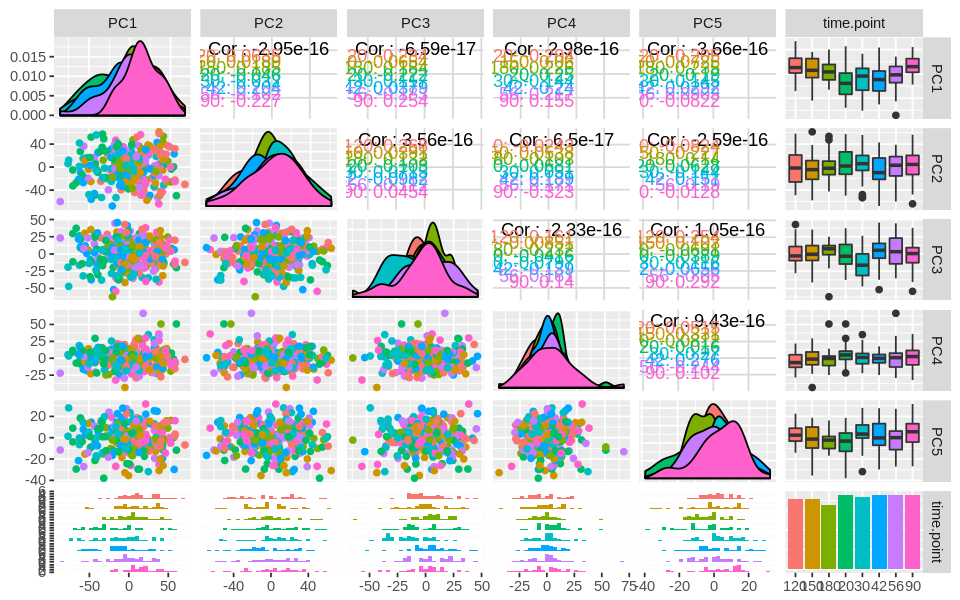

In [26]:
print(ggpairs(gg.PCA.monkey.m_l.point, aes(colour = time.point)))

#### Perform PCA and explore separation of active vs. latent disease across time periods post infection

##### PCA of all time periods with active vs latent

Result: Basically no difference between active vs. latent monkeys along PC-1-5 when looking at the entire dataset.

In [31]:
gg.PCA.monkey.disease = as.data.frame(PCA.monkey$x[,1:5])
gg.PCA.monkey.disease$clinical.status = pheno$clinical.status

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


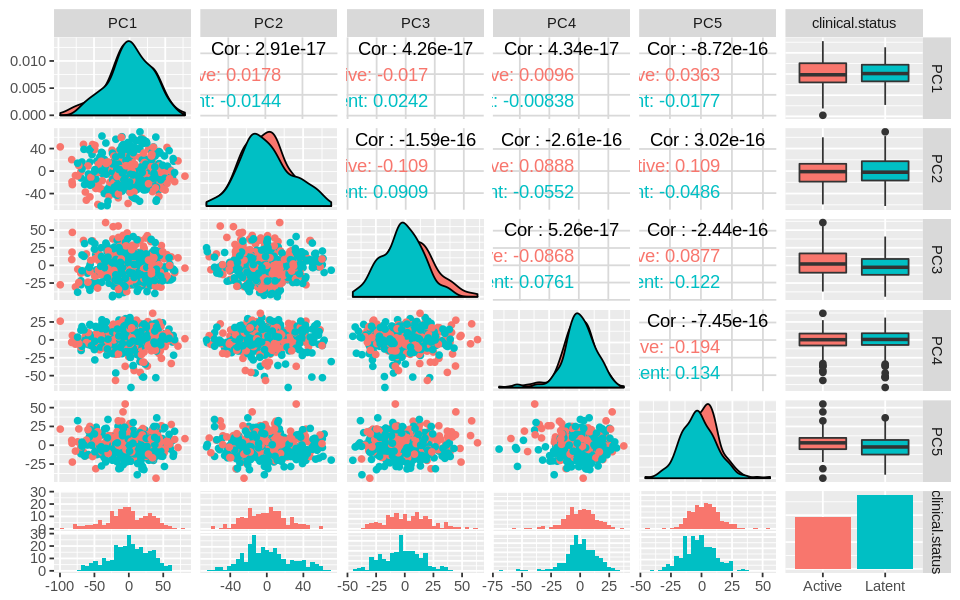

In [32]:
print(ggpairs(gg.PCA.monkey.disease, aes(colour = clinical.status)))

##### PCA of all post-infection time periods active vs latent

Result: Still basically no difference between active and latent disease

In [34]:
gg.PCA.monkey.infect.disease = as.data.frame(PCA.monkey_infect$x[,1:5])
gg.PCA.monkey.infect.disease$clinical.status = pheno[pheno$time.period != "pre.infect",]$clinical.status

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


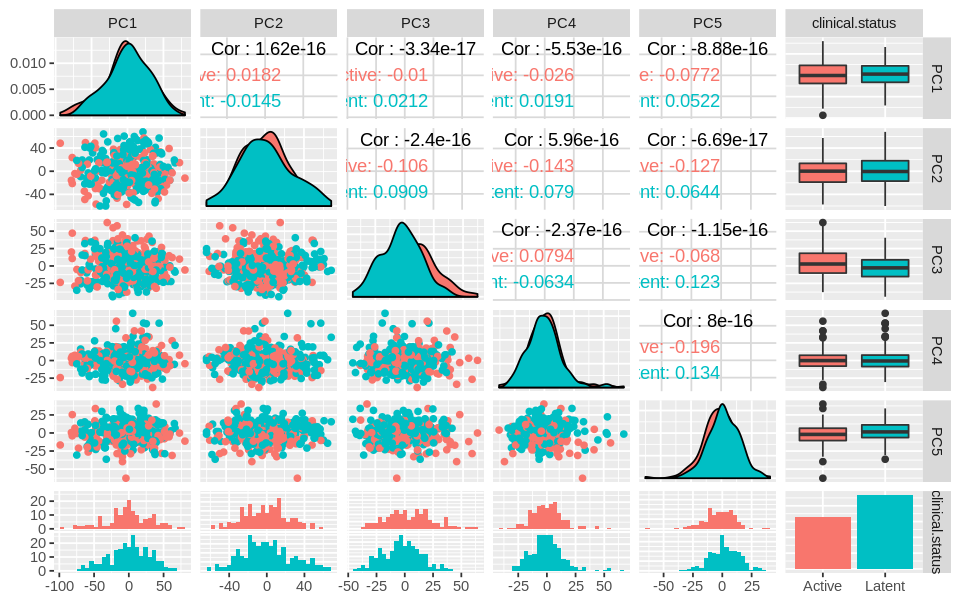

In [36]:
print(ggpairs(gg.PCA.monkey.infect.disease, aes(colour = clinical.status)))

##### PCA of all post-infection time periods individually comparing active vs latent

Result: Maybe some on PC-2,3 in late infection and a little with PC-3,5 in middle infection but overall no real separation between active and latent disease within a given time period post-infection via PCA analysis

In [37]:
m_early = monkey_var_genes[, pheno$time.period %in% c("early")]
m_middle = monkey_var_genes[, pheno$time.period %in% c("middle")]
m_late = monkey_var_genes[, pheno$time.period %in% c("late")]


PCA.monkey_early = prcomp(t(m_early), scale.=T)
PCA.monkey_middle = prcomp(t(m_middle), scale.=T)
PCA.monkey_late = prcomp(t(m_late), scale.=T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


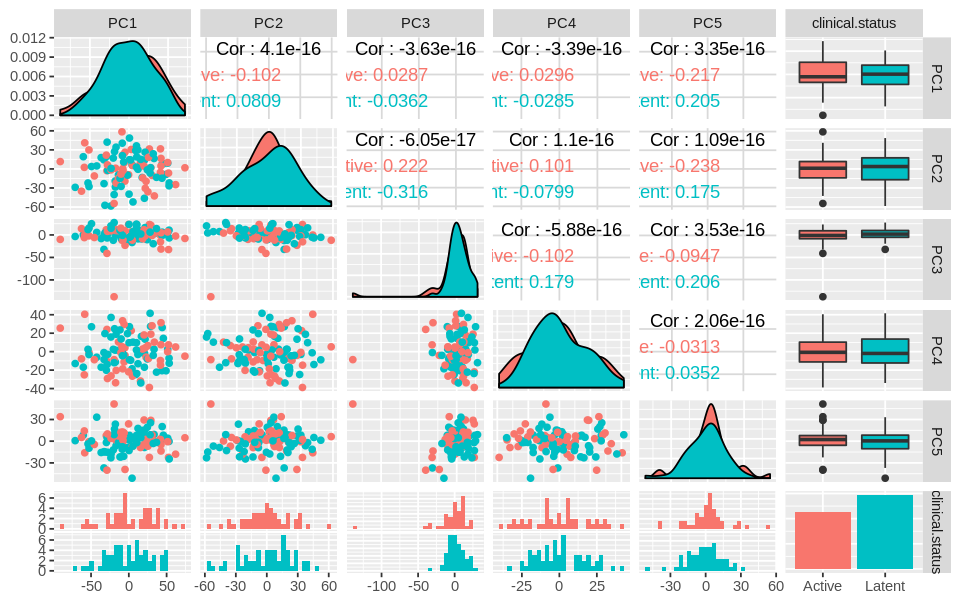

In [38]:
gg.PCA.monkey.early.disease = as.data.frame(PCA.monkey_early$x[,1:5])
gg.PCA.monkey.early.disease$clinical.status = pheno[pheno$time.period == "early",]$clinical.status
print(ggpairs(gg.PCA.monkey.early.disease, aes(colour = clinical.status)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


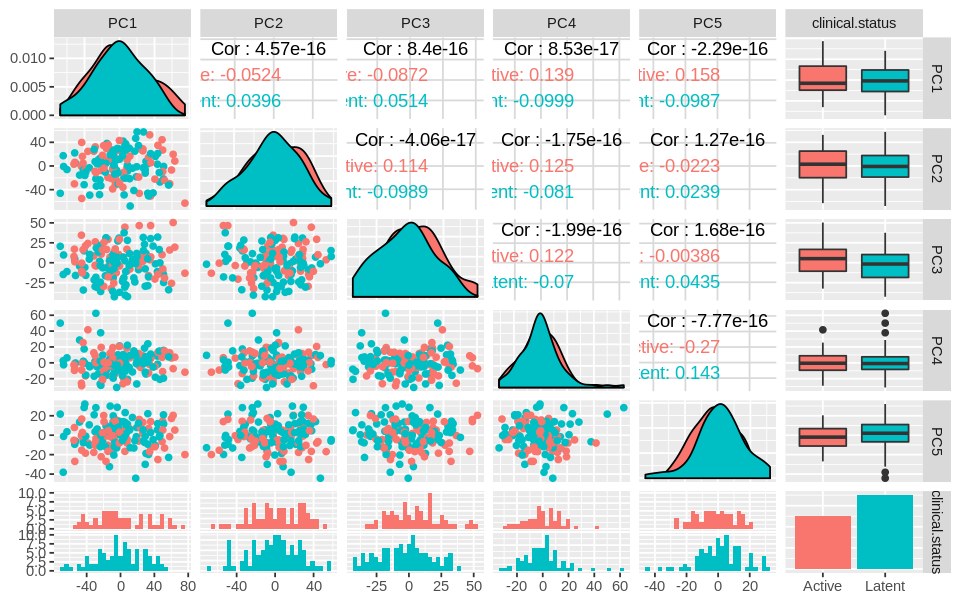

In [39]:
gg.PCA.monkey.middle.disease = as.data.frame(PCA.monkey_middle$x[,1:5])
gg.PCA.monkey.middle.disease$clinical.status = pheno[pheno$time.period == "middle",]$clinical.status
print(ggpairs(gg.PCA.monkey.middle.disease, aes(colour = clinical.status)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


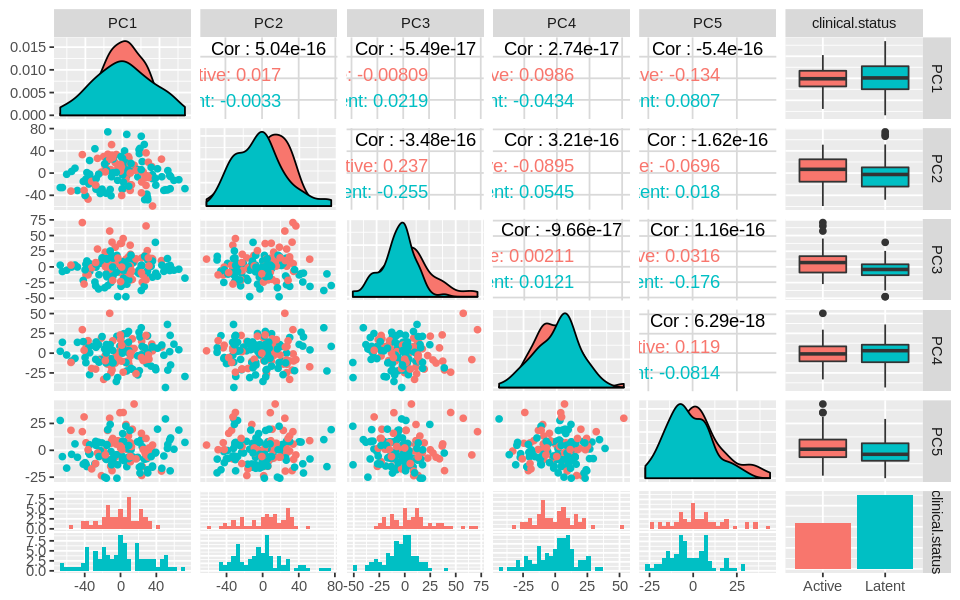

In [40]:
gg.PCA.monkey.late.disease = as.data.frame(PCA.monkey_late$x[,1:5])
gg.PCA.monkey.late.disease$clinical.status = pheno[pheno$time.period == "late",]$clinical.status
print(ggpairs(gg.PCA.monkey.late.disease, aes(colour = clinical.status)))

#### Run a caret optimization for regression using several techniques. Also include xgboost if I can. Graph the results similar to classification

##### Load middle-late data 

In [44]:
pheno_m_l = read.table(file=paste(monkey_path, "Monkey_PhenoData_middle-late.txt", sep="/"), header=T, sep="\t")
expres_m_l =  read.table(file=paste(monkey_path, "Monkey_Processed_ExpressionData_middle-late.txt", sep="/"), header=T, sep="\t")

##### Split into training and test sets, using the same random split used in python in initial neural networks training. It is 5 active TB monkeys and 6 latent TB monkeys, a roughly 70-30% train-test split.

In [47]:
test.latent.monkeys = c('M13', 'M27', 'M34', 'M15', 'M35', 'M36')
test.active.monkeys = c('M1', 'M16', 'M32', 'M18', 'M23')

In [51]:
test.rows = rownames(pheno[pheno$monkeyid %in% union(test.latent.monkeys, test.active.monkeys),])
train.rows = setdiff(rownames(pheno), test.rows)

pheno.train = droplevels(pheno[train.rows,])
pheno.test = droplevels(pheno[test.rows,])
expres.train = droplevels(expres[train.rows,])
expres.test = droplevels(expres[test.rows,])

##### Create grouped k-folds according to monkey within the training set. With seed 100, this gives 9-folds, which I am okay with

In [52]:
set.seed(100)
folds = groupKFold(pheno.train$monkeyid, k=10)
for (fold in lapply(folds, function(x) {pheno.train$monkeyid[x]}))
    print(length((as.character(fold))))

lapply(folds, function(x, y) table(y[x]), y = pheno.train$monkeyid)

[1] 202
[1] 194
[1] 186
[1] 174
[1] 187
[1] 179
[1] 186
[1] 178
[1] 194


$Fold1

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  5   8   8   0   8   7   8   8   8   8   8   8   8   8   8   8   8   7   8   8 
M38  M4  M5  M6  M7  M8  M9 
  7   8   8   8   8   8   8 

$Fold2

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  5   8   8   8   8   7   8   8   8   0   8   8   8   8   8   8   8   7   8   8 
M38  M4  M5  M6  M7  M8  M9 
  7   8   8   8   8   0   8 

$Fold3

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  5   0   8   8   8   7   8   8   8   8   8   8   0   8   8   8   0   7   8   8 
M38  M4  M5  M6  M7  M8  M9 
  7   8   8   8   8   8   8 

$Fold4

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  0   8   8   8   8   7   8   0   8   8   8   8   8   0   8   8   8   0   0   8 
M38  M4  M5  M6  M7  M8  M9 
  7   8   8   8   8   8   8 

$Fold5

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 

##### Create training sets for classification and regression. I will not repeat the classification analysis, but I include the code anyway.

In [81]:
expres.train.period = data.frame(expres.train, time.period=pheno.train$time.period)
expres.train.point = data.frame(expres.train, time.point=pheno.train$time.point)

##### Classification code using caret to randomly optimize gbm, svmRadial, svmPoly, ranger, glmnet and dnn

In [ ]:
seed=7

# Now we are going to loop over different models
# This code does work as long as I have the appropriate packages downloaded.
start_time <- Sys.time()

cluster = makeCluster(detectCores()-3) # Leaving 3 for other jobs
registerDoParallel(cluster)

methods = c("gbm", "svmRadial", "svmPoly", "ranger", "glmnet", "dnn")
#LVQ model has bug with a small dataset, so I removed that technique

models = list()


#folds
control <- trainControl(method="cv", index=folds, search="random", allowParallel=TRUE)

for (alg in methods) {
    set.seed(seed)
    print("I have gotten to model:")
    print(alg)
    model = train(time.period~., data=expres.train, method=alg, tuneLength=15, trControl=control)
    models[[alg]] = model
}



save.progress(file="Monkey-TB-caret-middlelate-classification-15 length random grid", dir=paste(path, "data/analysis_results", sep="/"))
stopCluster(cluster)
registerDoSEQ()

end_time <- Sys.time()
print(end_time - start_time)

##### Plot the classification cross-validation results and make predictions on the test set

In [73]:
# Make R graphs smaller
options(repr.plot.width=4, repr.plot.height=3)

In [75]:
load("data/Monkey-TB-caret-15 length random grid-2018-02-01-.RData")

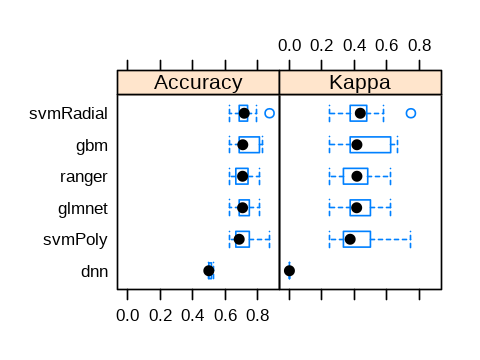

In [74]:
results = resamples(models)
bwplot(results)

In [ ]:
pdf(paste("Middle_late_Classification_Cross Validation-Parameter Search_",
          Sys.Date(), "_.pdf", sep="")
bwplot(results)
dev.off()

In [71]:
model.gbm = models$gbm
pred.test = predict(model.gbm, newdata = expres.test)
confusionMatrix(pred.test, pheno.test$time.period, positive = "middle")

Confusion Matrix and Statistics

          Reference
Prediction late middle
    late     25      8
    middle   15     36
                                         
               Accuracy : 0.7262         
                 95% CI : (0.618, 0.8179)
    No Information Rate : 0.5238         
    P-Value [Acc > NIR] : 0.0001197      
                                         
                  Kappa : 0.4467         
 Mcnemar's Test P-Value : 0.2109029      
                                         
            Sensitivity : 0.8182         
            Specificity : 0.6250         
         Pos Pred Value : 0.7059         
         Neg Pred Value : 0.7576         
             Prevalence : 0.5238         
         Detection Rate : 0.4286         
   Detection Prevalence : 0.6071         
      Balanced Accuracy : 0.7216         
                                         
       'Positive' Class : middle         
                                         

In [72]:
model.glm = models$glmnet
pred.test = predict(model.glm, newdata = expres.test)
confusionMatrix(pred.test, pheno.test$time.period, positive = "middle")

Confusion Matrix and Statistics

          Reference
Prediction late middle
    late     26      9
    middle   14     35
                                         
               Accuracy : 0.7262         
                 95% CI : (0.618, 0.8179)
    No Information Rate : 0.5238         
    P-Value [Acc > NIR] : 0.0001197      
                                         
                  Kappa : 0.448          
 Mcnemar's Test P-Value : 0.4042485      
                                         
            Sensitivity : 0.7955         
            Specificity : 0.6500         
         Pos Pred Value : 0.7143         
         Neg Pred Value : 0.7429         
             Prevalence : 0.5238         
         Detection Rate : 0.4167         
   Detection Prevalence : 0.5833         
      Balanced Accuracy : 0.7227         
                                         
       'Positive' Class : middle         
                                         

This is the best model for classification, chosen with a manual grid

In [277]:
# Despite the name, this was actually with 100 values for the parameters
load("data/analysis_results/Monkey-TB-caret-middlelate-classification-glmnet grid tuning with 50 samples_round4-2018-05-25-.RData")

In [ ]:
model.glm = models$glmnet
pred.test = predict(model.glm, newdata = expres.test)

In [280]:
confusionMatrix(model.glm$pred$pred, model.glm$pred$obs, positive= "middle")
confusionMatrix(pred.test, pheno.test$time.period, positive = "middle")

Confusion Matrix and Statistics

          Reference
Prediction late middle
    late     76     30
    middle   27     77
                                          
               Accuracy : 0.7286          
                 95% CI : (0.6631, 0.7875)
    No Information Rate : 0.5095          
    P-Value [Acc > NIR] : 7.634e-11       
                                          
                  Kappa : 0.4572          
 Mcnemar's Test P-Value : 0.7911          
                                          
            Sensitivity : 0.7196          
            Specificity : 0.7379          
         Pos Pred Value : 0.7404          
         Neg Pred Value : 0.7170          
             Prevalence : 0.5095          
         Detection Rate : 0.3667          
   Detection Prevalence : 0.4952          
      Balanced Accuracy : 0.7287          
                                          
       'Positive' Class : middle          
                                          

Confusion Matrix and Statistics

          Reference
Prediction late middle
    late     28      8
    middle   12     36
                                          
               Accuracy : 0.7619          
                 95% CI : (0.6565, 0.8481)
    No Information Rate : 0.5238          
    P-Value [Acc > NIR] : 6.115e-06       
                                          
                  Kappa : 0.5205          
 Mcnemar's Test P-Value : 0.5023          
                                          
            Sensitivity : 0.8182          
            Specificity : 0.7000          
         Pos Pred Value : 0.7500          
         Neg Pred Value : 0.7778          
             Prevalence : 0.5238          
         Detection Rate : 0.4286          
   Detection Prevalence : 0.5714          
      Balanced Accuracy : 0.7591          
                                          
       'Positive' Class : middle          
                                          

##### Demonstrate that classification of middle vs. late infection is independent of disease status. I will do this by showing that the proportion of active disease (before was the ratio of active to latent and was confusing/misleading) is not changed between ground truth and predicted time periods

My hypothesis is mostly correct. There is a small 3.5% absolute enrichment in the proportion of active TB samples in my predicted middle group, in both validation and testing. Therefore, active disease is in small part confounded with middle time point, but it's effect is insignificant (both statistically and in terms of effect size). I would expect a statistical test to show not significant, and I can describe this.

Below is an incorrect analysis based on making incorrect calculations and not interpreting them well:

- My hypothesis is wrong. There is a ~10% absolute increase in the active TB to latent TB ratio in the predicted middle vs. actual middle.
- This means that the classifier is learning a pattern of active disease to predict who is in middle infection
    - This is probably good for a treatment application of this research. I don't know yet about the clinical studies. However, most humans don't develop active TB so it's likely moot depending on the results of the human data analysis
    - This means the human data analysis is key. I should mention these results and even put it in Figure 2, but I don't think I should dwell on them too much prematurely.
- At some point soon I should make a graph of these results and do a statistical test for them.
- I DEFINITELY SHOULD LOOK AT THE TIME POINTS AND ACTIVE DISEASE THINGS MYSELF JUST TO MAKE SURE THESE RESULTS ARE CORRECT.
- It seems weird to me that 83.33% of the early samples are from active disease.
    - Maybe I am calculating things wrong in some way.
    - No I think the proportion is the best way for this

In [89]:
# Despite the name, this was actually with 100 values for the parameters
load("data/analysis_results/Monkey-TB-caret-middlelate-classification-glmnet grid tuning with 50 samples_round4-2018-05-25-.RData")

In [281]:
val.preds = models$glmnet$pred
test.preds = predict(models$glmnet, newdata=expres.test)

In [132]:
#confusionMatrix(val.preds$pred, val.preds$obs, positive="middle")
#confusionMatrix(test.preds, pheno.test$time.period, positive = "middle")

# Pretty amazing accuracy, 77% with a more optimized , but the validation is 72.38% still, probably overoptimistic, but it does use more data.

# sanity check from poster on active TB monkeys and latent TB monkeys, confirming everything is labeled correctly
# it's okay to be slightly off from the ratios below because some monkeys have missing samples

#sum(sapply(tapply(pheno.test$clinical.status, pheno.test$monkeyid, table), function(x) {x[1] > 0}))
#tapply(pheno$clinical.status, pheno$monkeyid, table)

#sum(pheno$clinical.status == "Active")
#16 / 38
#11 / 27
#5 / 11

In [282]:
# Calculate ratio of active to latent in all actual and predicted middle and late time periods, in both validation and test set
# Should be the same ratio for val middle and late
# actually, may be different from missing samples, and they are different
a.l.middle.val = sum(filter(pheno.train, time.period=="middle")$clinical.status == "Active") / length(filter(pheno.train, time.period=="middle")$clinical.status)
a.l.late.val = sum(filter(pheno.train, time.period=="late")$clinical.status == "Active") / length(filter(pheno.train, time.period=="late")$clinical.status)

a.l.p.middle.val = sum(pheno.train[val.preds$pred == "middle",]$clinical.status=="Active") / length(pheno.train[val.preds$pred == "middle",]$clinical.status)
a.l.p.late.val = sum(pheno.train[val.preds$pred == "late",]$clinical.status=="Active") / length(pheno.train[val.preds$pred == "late",]$clinical.status)




In [283]:
# Calculate ratio of active to latent in all actual and predicted middle and late time periods, in both validation and test set
# Should be the same ratio for val middle and late
# actually, may be different from missing samples, and they are different
a.l.middle.test = sum(filter(pheno.test, time.period=="middle")$clinical.status == "Active") / length(filter(pheno.test, time.period=="middle")$clinical.status)
a.l.late.test = sum(filter(pheno.test, time.period=="late")$clinical.status == "Active") / length(filter(pheno.test, time.period=="late")$clinical.status)

a.l.p.middle.test = sum(pheno.test[test.preds == "middle",]$clinical.status=="Active") / length(pheno.test[test.preds == "middle",]$clinical.status)
a.l.p.late.test = sum(pheno.test[test.preds == "late",]$clinical.status=="Active") / length(pheno.test[test.preds == "late",]$clinical.status)




In [384]:
print("Validation")
a.l.middle.val
a.l.late.val
a.l.p.middle.val
a.l.p.late.val

print('Test')
a.l.middle.test
a.l.late.test
a.l.p.middle.test
a.l.p.late.test

a.l.p.middle.val - a.l.middle.val
a.l.p.middle.test - a.l.middle.test

[1] "Validation"


[1] 0.4018692

[1] 0.3786408

[1] 0.4615385

[1] 0.3207547

[1] "Test"


[1] 0.4545455

[1] 0.4

[1] 0.4791667

[1] 0.3611111

[1] 0.0596693

[1] 0.02462121

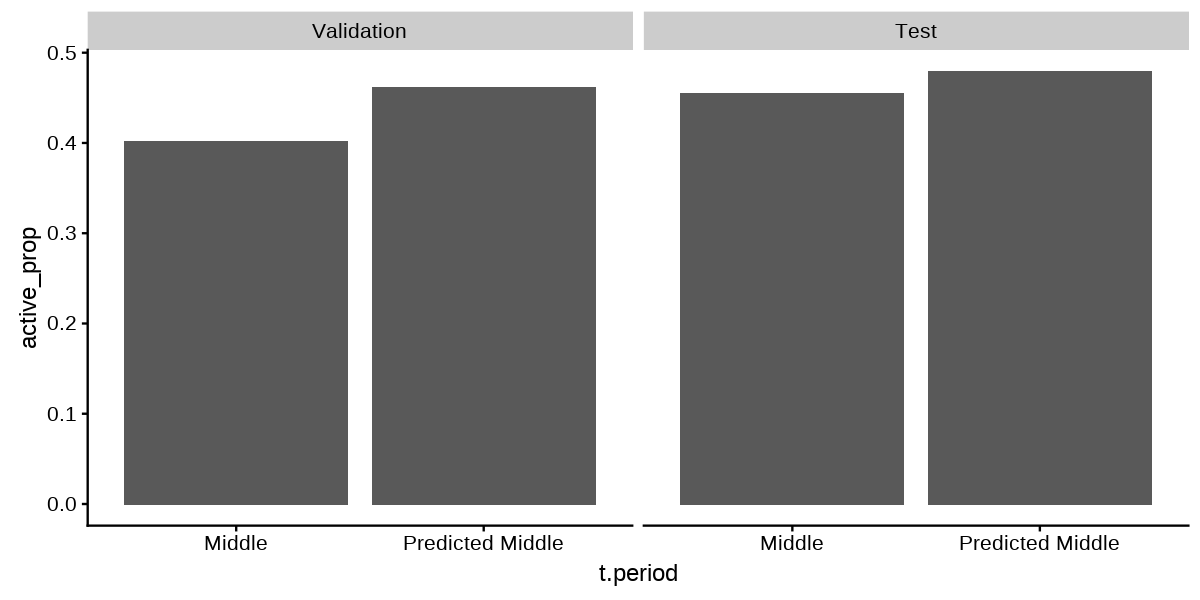

In [285]:
t.period = c("Middle", "Predicted Middle", "Middle", "Predicted Middle")
partition = as.factor(c("Validation", "Validation", "Test", "Test"))
active_prop = c(a.l.middle.val, a.l.p.middle.val, a.l.middle.test, a.l.p.middle.test)
partition = factor(partition, levels(partition)[c(which(levels(partition) == "Validation"),
                                                  which(levels(partition) == "Test"))])

disease.confound = data.frame(t.period=as.factor(t.period), partition=partition, active_prop=active_prop)

ggplot(disease.confound, aes(x=t.period, y=active_prop)) + geom_bar(stat="identity") + facet_grid(~partition)

##### Now regression code using caret to optimize with cross-validation gbm, range, glmnet, xgboost, dnn, svmRadial, svmPoly and any other method i can try.
- I think first I should try out the code with one method (glmnet) for regression on a toy dataset, and then I should confirm that I can get xgboost to work and see what it does. 
- Make sure I can get regression to work before I run it on the whole dataset.

###### Run the cross-validation with random hyperparameter search over many algorithms

In [ ]:
seed=7

# Now we are going to loop over different models
# This code does work as long as I have the appropriate packages downloaded.
start_time <- Sys.time()

cluster = makeCluster(detectCores()-3) # Leaving 3 for other jobs
registerDoParallel(cluster)

methods = c("gbm", "svmRadial", "svmPoly", "ranger", "glmnet", "xgbTree", "dnn")
#LVQ model has bug with a small dataset, so I removed that technique

models = list()


#folds
control <- trainControl(method="cv", index=folds, search="random", allowParallel=TRUE)

for (alg in methods) {
    set.seed(seed)
    print("I have gotten to model:")
    print(alg)
    model = train(time.point~., data=expres.train.point, method=alg, tuneLength=15, trControl=control)
    models[[alg]] = model
}



save.progress(file="Monkey-TB-caret-middlelate-regression-15 length random grid", dir=paste(path, "data/analysis_results", sep="/"))
stopCluster(cluster)
registerDoSEQ()

end_time <- Sys.time()
print(end_time - start_time)

###### Load results of the 50 parameter tuning and graph cross-validation predictions for all of the models
xgbboost tree and the 2 svmss may do the best class separation but they all have very similar MAE and RMSE

In [263]:
load('data/analysis_results/Monkey-TB-caret-middlelate-regression-50 length random grid_finalpredssaved-2018-05-15-.RData')

In [246]:
table(pheno.train$time.point)


 20  30  42  56  90 120 150 180 
 27  26  27  27  27  26  26  24 

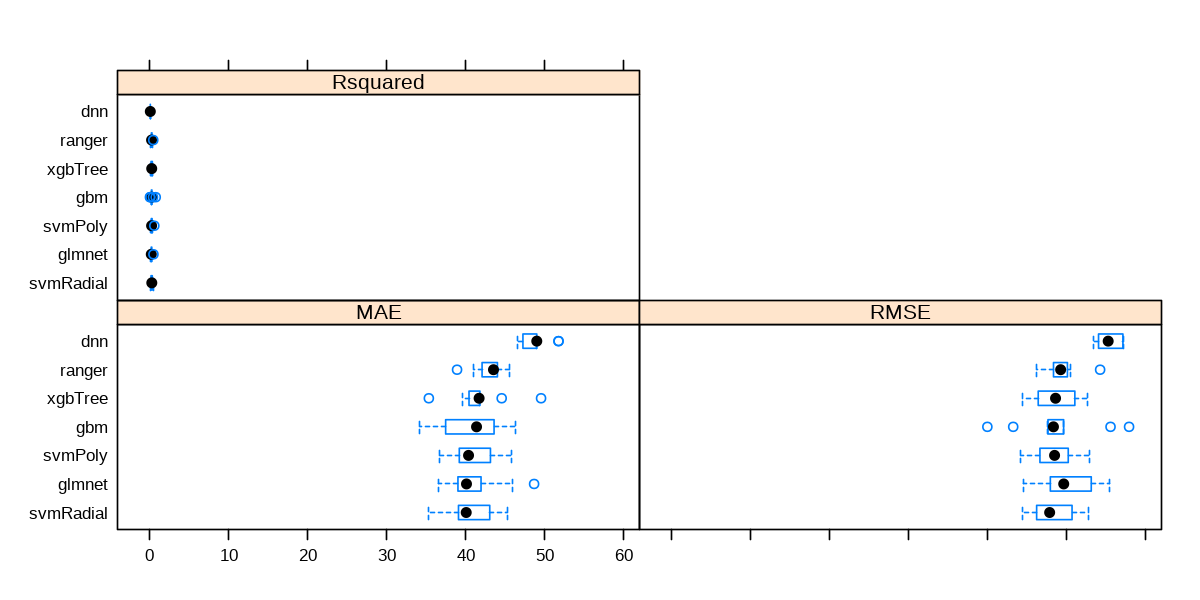

In [264]:
results = resamples(models)
bwplot(results)

In [328]:
max(c(0,180))

[1] 180

In [329]:
table(pheno$time.point)


  0   1   3   7  10  20  30  42  56  90 120 150 180 
 38  34  28  38  38  38  37  38  38  38  36  36  33 

In [345]:
generate.regres.graph = function(data, label, log = F, break.90 = F) {
    #q = qplot(obs, pred, data= data, geom = c("point", "smooth"), method="loess")
    if (log) {
        data$obs = 2 ^ data$obs
        data$pred = 2 ^ data$pred
    }
    
    break_points = c(0, 30, 60, 90 , 120, 150, 180)
    if (break.90)
        break_points = c(0, 20, 30, 42, 56, 90)
    q = ggplot(data, aes(obs, pred, group=obs)) +
        
        scale_y_continuous(breaks=break_points, limits = c(min(break_points), max(break_points))) +
        geom_point() + geom_smooth(method="loess") +
        geom_boxplot(outlier.shape=NA, colour = "red", fill="white", width=10) +
        theme_bw() +
        labs(x="Days Post Infection", y="Predicted Days Post Infection") + 
        ggtitle(paste(label)) +  #, "regression in cynomolgus macaques")) +
        theme(plot.title = element_text(hjust = 0.5))
    
    return(q)
}

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

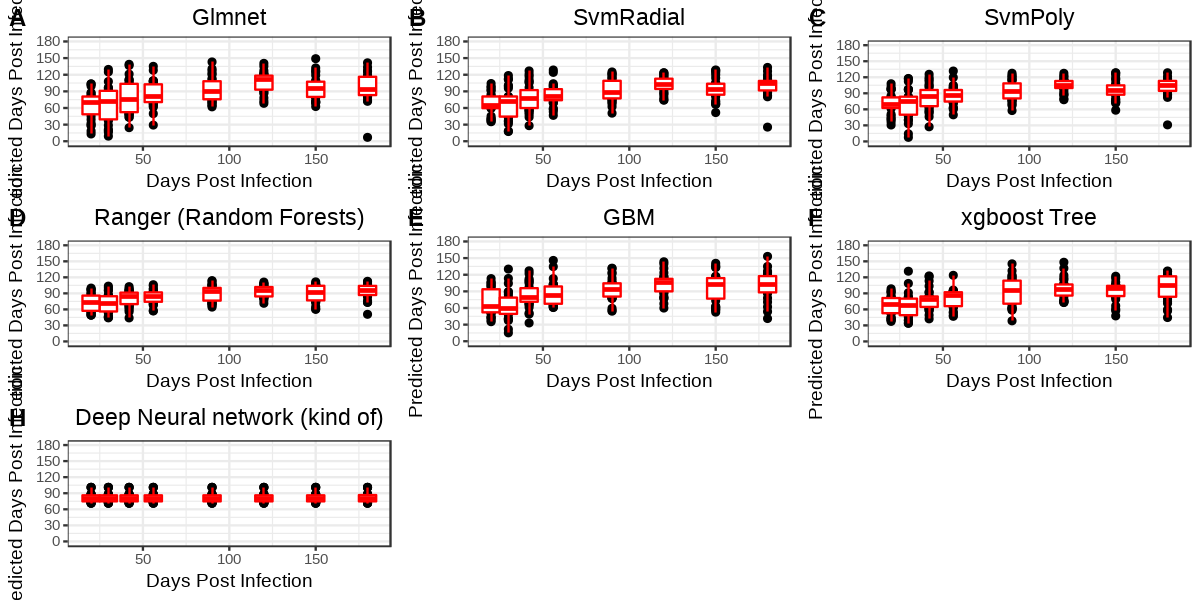

In [249]:
glm.graph = generate.regres.graph(models$glmnet$pred, "Glmnet")
svmRadial.graph = generate.regres.graph(models$svmRadial$pred, "SvmRadial")
svmPoly.graph = generate.regres.graph(models$svmPoly$pred, "SvmPoly")
ranger.graph = generate.regres.graph(models$ranger$pred, "Ranger (Random Forests)")
gbm.graph = generate.regres.graph(models$gbm$pred, "GBM")
xgbtree.graph = generate.regres.graph(models$xgbTree$pred, "xgboost Tree")
dnn.graph = generate.regres.graph(models$dnn$pred, "Deep Neural network (kind of)")
#svmRadial.graph = generate.regres.graph(models$svmRadial, "SvmRadial")

allregressions= plot_grid(glm.graph,
                          svmRadial.graph,
                          svmPoly.graph,
                          ranger.graph,
                          gbm.graph,
                          xgbtree.graph,
                          dnn.graph, labels = toupper(c(letters[1:6], align="h")))

allregressions

#save_plot(paste(figures.dir, "R03_paper_Monocytes_Figure3.pdf", sep="/"), Figure_3, nrow=1, ncol=2)

###### Load results of the 50 parameter tuning with only 90 day or less samples and graph cross-validation predictions for all of the models

In [237]:
load('data/analysis_results/Monkey-TB-caret-middlelate-regression-50 length random grid_only through 90 days_finalpredssaved-2018-05-16-.RData')

In [238]:
table(pheno.train.90$time.point)


20 30 42 56 90 
27 26 27 27 27 

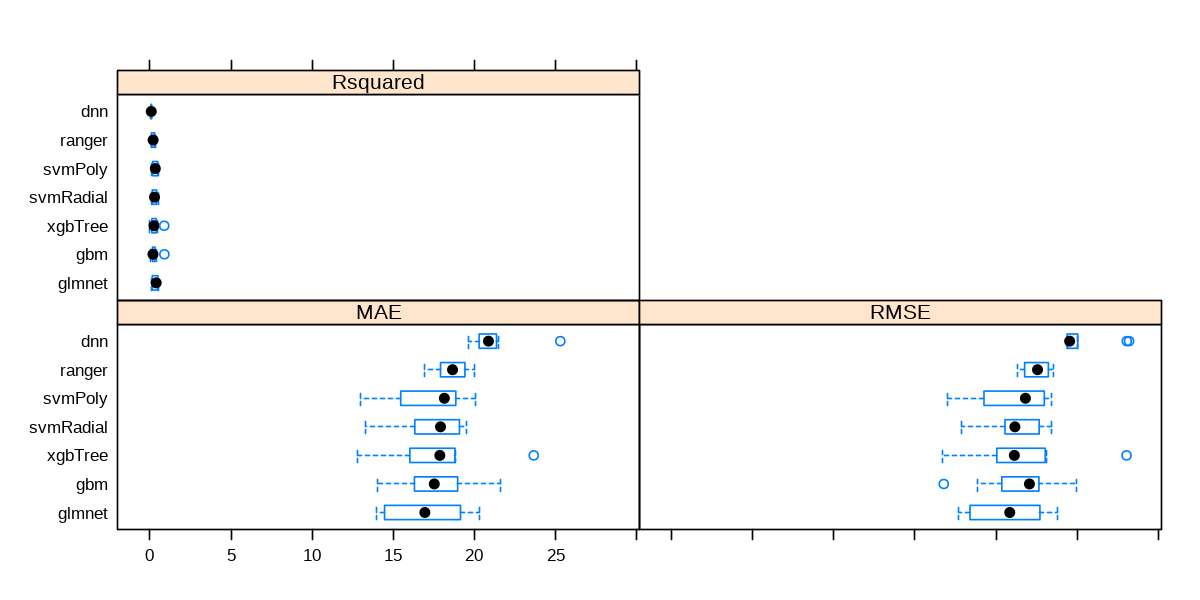

In [239]:
results = resamples(models)
bwplot(results)

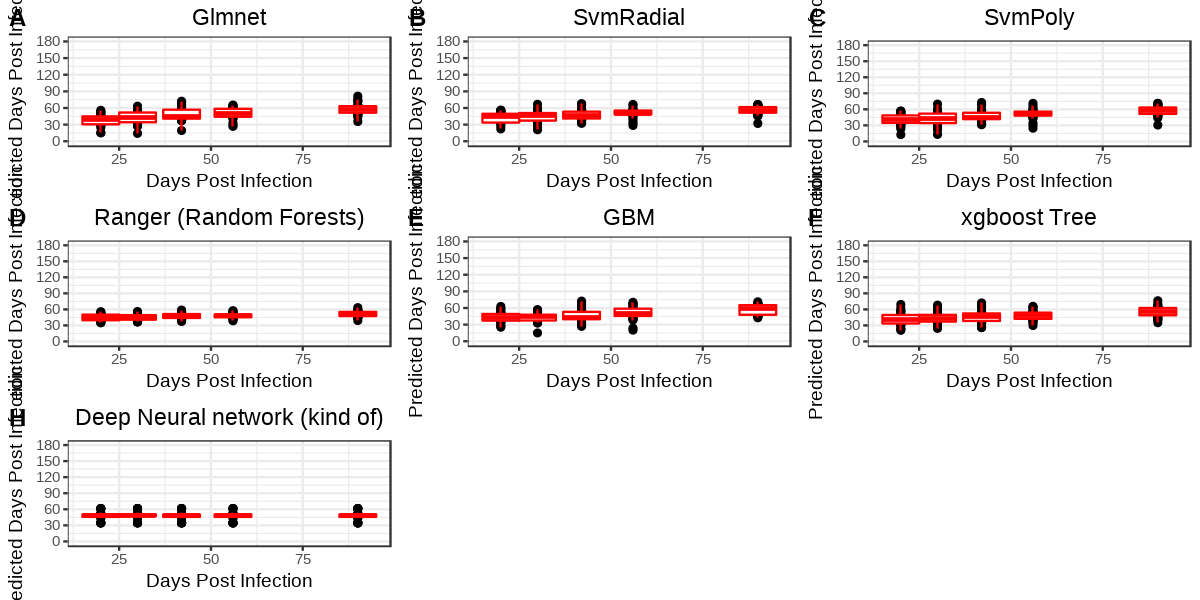

In [241]:
glm.graph = generate.regres.graph(models$glmnet$pred, "Glmnet")
svmRadial.graph = generate.regres.graph(models$svmRadial$pred, "SvmRadial")
svmPoly.graph = generate.regres.graph(models$svmPoly$pred, "SvmPoly")
ranger.graph = generate.regres.graph(models$ranger$pred, "Ranger (Random Forests)")
gbm.graph = generate.regres.graph(models$gbm$pred, "GBM")
xgbtree.graph = generate.regres.graph(models$xgbTree$pred, "xgboost Tree")
dnn.graph = generate.regres.graph(models$dnn$pred, "Deep Neural network (kind of)")
#svmRadial.graph = generate.regres.graph(models$svmRadial, "SvmRadial")

allregressions= plot_grid(glm.graph,
                          svmRadial.graph,
                          svmPoly.graph,
                          ranger.graph,
                          gbm.graph,
                          xgbtree.graph,
                          dnn.graph, labels = toupper(c(letters[1:6], align="h")))

allregressions

#save_plot(paste(figures.dir, "R03_paper_Monocytes_Figure3.pdf", sep="/"), Figure_3, nrow=1, ncol=2)

###### Load results of the 50 parameter tuning with log2 transformed data and graph cross-validation predictions for all of the models

In [307]:
load('data/analysis_results/Monkey-TB-caret-middlelate-regression-50 length random grid_timepointlogtransformed_finalpredssaved-2018-05-18-.RData')

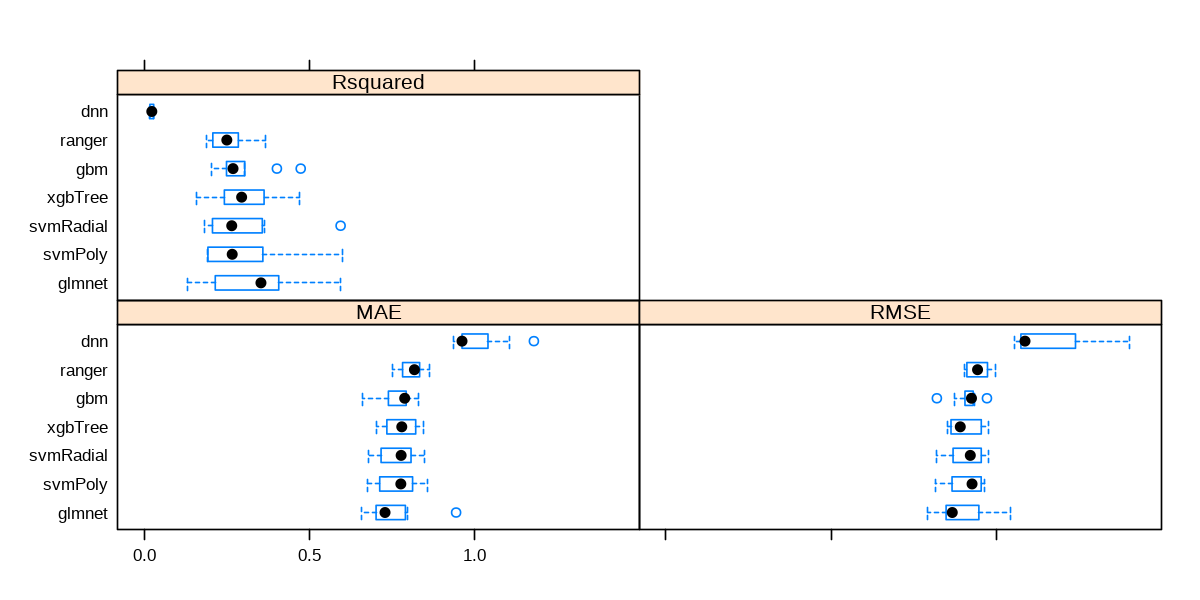

In [308]:
results = resamples(models)
bwplot(results)

This Graph indicates to me that maybe we should go out to 120 days in restricting our timing

GBM gives more symmetrical predictions about the truth than glmnet and SvmRadial. But all in all, they give very similar results.

Comparing these results to the 50 parameter tuning without log2, they look better, they are prettier. There is a tighter distribution along the median prediction within a time point.

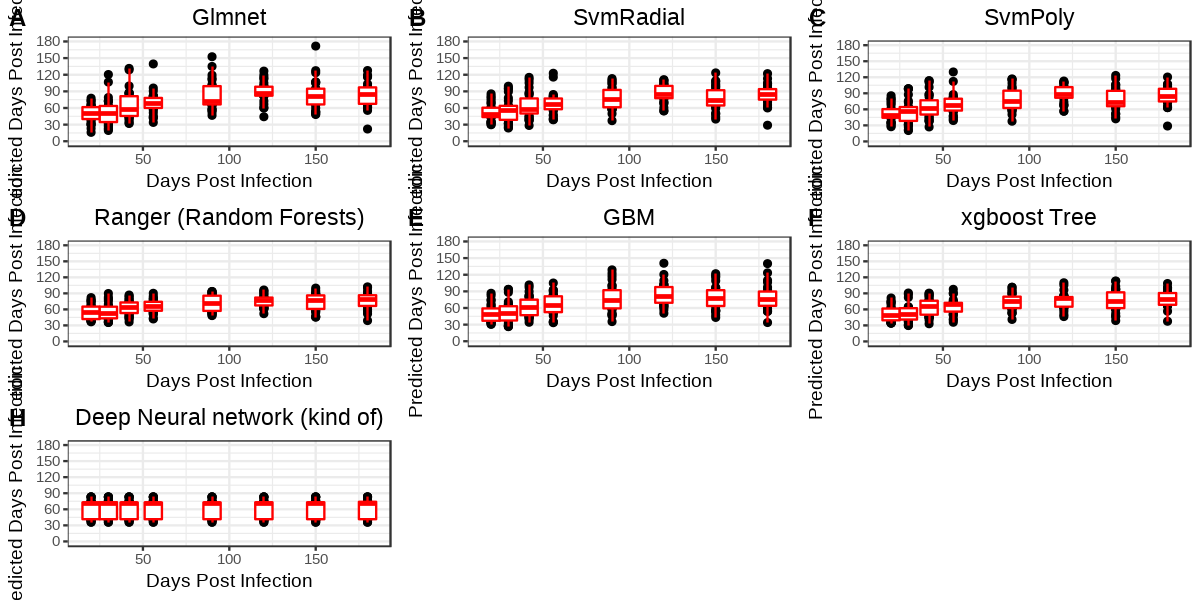

In [244]:
glm.graph = generate.regres.graph(models$glmnet$pred, "Glmnet", T)
svmRadial.graph = generate.regres.graph(models$svmRadial$pred, "SvmRadial", T)
svmPoly.graph = generate.regres.graph(models$svmPoly$pred, "SvmPoly", T)
ranger.graph = generate.regres.graph(models$ranger$pred, "Ranger (Random Forests)", T)
gbm.graph = generate.regres.graph(models$gbm$pred, "GBM", T)
xgbtree.graph = generate.regres.graph(models$xgbTree$pred, "xgboost Tree", T)
dnn.graph = generate.regres.graph(models$dnn$pred, "Deep Neural network (kind of)", T)
#svmRadial.graph = generate.regres.graph(models$svmRadial, "SvmRadial")

allregressions= plot_grid(glm.graph,
                          svmRadial.graph,
                          svmPoly.graph,
                          ranger.graph,
                          gbm.graph,
                          xgbtree.graph,
                          dnn.graph, labels = toupper(c(letters[1:6], align="h")))

allregressions

#save_plot(paste(figures.dir, "R03_paper_Monocytes_Figure3.pdf", sep="/"), Figure_3, nrow=1, ncol=2)

###### Compare MAE and MSE between log2 transformed and not transformed data

In [309]:
load('data/analysis_results/Monkey-TB-caret-middlelate-regression-50 length random grid_timepointlogtransformed_finalpredssaved-2018-05-18-.RData')
log2.models = models
load('data/analysis_results/Monkey-TB-caret-middlelate-regression-50 length random grid_finalpredssaved-2018-05-15-.RData')
reg.models = models

In [314]:
log2.pred = log2.models$glmnet$pred
reg.pred = reg.models$glmnet$pred

In [315]:
log2.pred$pred.t = 2 ^ log2.pred$pred
log2.pred$obs.t = 2 ^ log2.pred$obs

In [385]:
rmse <- function(truth, pred) 
    sqrt(mean((truth - pred)^2))

mea <- function(truth, pred)
    mean(abs(truth-pred))

mea.med <- function(truth, pred)
    median(abs(truth-pred))

all.metrics = function(truth, pred) {
    
    print("Root Mean Squared Error (RMSE)")
    print(rmse(truth, pred))
    print("Mean Absolute Error")
    print(mea(truth, pred))
    print("Median Absolute Error")
    print(mea.med(truth, pred))
    print("Pearson Correlation Coefficient")
    print(cor(truth, pred))
    print("Pearson Correlation Signifcance Test")
    print(cor.test(truth, pred))
    print("Spearman Correlation Signifcance Test")
    print(cor.test(truth, pred, method = 'spearman'))
    print("R squared")
    print(caret::R2(pred, truth))
}

The RMSE is more for the log2 transformed model. However, tuned parameter is a confounder. The mean absolute error is a bit better for the log2 transformed model. I think I am going to go ahead and go with the log2 transformed model. It probably makes little difference in the end, relative to other sources of noise/performance

In [316]:
rmse(reg.pred$obs, reg.pred$pred)
rmse(log2.pred$obs.t, log2.pred$pred.t)


mea(reg.pred$obs, reg.pred$pred)
mea(log2.pred$obs.t, log2.pred$pred.t)

R2(reg.pred$obs, reg.pred$pred)
R2(log2.pred$obs.t, log2.pred$pred.t)

[1] 50.08432

[1] 50.28947

[1] 40.50651

[1] 38.78397

[1] 0.1723313

[1] 0.2062639

###### Load the 115 parameter grid with log2 transformed time point, and graph the results for validation and test set. Also calculate the RMSE, MAE (mean and median), Rsquared and pearson correlation.

Do this for both the whole dataset, as well as within the up to 90 day dataset.
The 90 day dataset actually didn't work that well, particularly at the 56 day time point. I think for this dataset, I should not log transform the time periods. However, I might be artificially changing things. It doesn't look good, that is for sure.

In [317]:
load("data/analysis_results/Monkey-TB-caret-middlelate-regression-glmnet grid tuning with 115 samples_round5_log2 timepoint-2018-05-29-.RData")

Validation Data (whole dataset)

In [318]:
log2.models = models
log2.pred = log2.models$glmnet$pred
log2.pred$pred.t = 2 ^ log2.pred$pred
log2.pred$obs.t = 2 ^ log2.pred$obs

rmse(log2.pred$obs.t, log2.pred$pred.t)
mea(log2.pred$obs.t, log2.pred$pred.t)
mea.med(log2.pred$obs.t, log2.pred$pred.t)

cor(log2.pred$obs.t, log2.pred$pred.t)
cor.test(log2.pred$obs.t, log2.pred$pred.t)
caret::R2(log2.pred$pred.t, log2.pred$obs.t)

[1] 49.25728

[1] 38.10432

[1] 29.17451

[1] 0.5336253


	Pearson's product-moment correlation

data:  log2.pred$obs.t and log2.pred$pred.t
t = 9.1, df = 208, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4292470 0.6239376
sample estimates:
      cor 
0.5336253 


[1] 0.2847559

Test data (whole dataset)

In [319]:
model.glm = models$glmnet
pred.test = predict(model.glm, newdata = expres.test)

In [324]:
log2.pred.test = 2 ^ pred.test
pheno.test$time.point


rmse(pheno.test$time.point, log2.pred.test)
mea(pheno.test$time.point, log2.pred.test)
mea.med(pheno.test$time.point, log2.pred.test)

cor(pheno.test$time.point, log2.pred.test)
cor.test(pheno.test$time.point, log2.pred.test)
caret::R2(log2.pred.test, pheno.test$time.point)


[1] 150  20  90  42 180  20 120  20 120  56 180  30  42 180  30  90  90 150 120
[20]  56  90  56 150 120  90  42  30  30  56 150  56  42  42 150 180  30 120  20
[39]  20 120  90  42  42  42  30  90  20  56  20 180  56  20  30 180 120  56  20
[58] 120  90 150  56 150  56 180  30  90 120  56  42  20  90  20  42 150 120  90
[77] 150 180 150  30  30  30 180  42

[1] 48.80143

[1] 37.28059

[1] 27.22094

[1] 0.489246


	Pearson's product-moment correlation

data:  pheno.test$time.point and log2.pred.test
t = 5.0798, df = 82, p-value = 2.33e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3070588 0.6368416
sample estimates:
     cor 
0.489246 


[1] 0.2393617

Validation data (first 90 days)

In [332]:
load("data/analysis_results/Monkey-TB-caret-middlelate-regression-glmnet grid tuning with 1000 samples_first90days_round3_log2 timepoint-2018-05-29-.RData")

In [333]:
log2.models.90 = models
log2.pred = log2.models.90$glmnet$pred
log2.pred$pred.t = 2 ^ log2.pred$pred
log2.pred$obs.t = 2 ^ log2.pred$obs

rmse(log2.pred$obs.t, log2.pred$pred.t)
mea(log2.pred$obs.t, log2.pred$pred.t)
mea.med(log2.pred$obs.t, log2.pred$pred.t)

cor(log2.pred$obs.t, log2.pred$pred.t)
cor.test(log2.pred$obs.t, log2.pred$pred.t)
caret::R2(log2.pred$pred.t, log2.pred$obs.t)

[1] 20.90084

[1] 16.25966

[1] 12.14029

[1] 0.556822


	Pearson's product-moment correlation

data:  log2.pred$obs.t and log2.pred$pred.t
t = 7.7018, df = 132, p-value = 2.819e-12
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4276133 0.6637336
sample estimates:
     cor 
0.556822 


[1] 0.3100507

Test Data (first 90 days)

In [339]:
model.glm = models$glmnet
pred.test = predict(model.glm, newdata = expres.test[pheno.test$time.point <= 90,])

In [342]:
log2.pred.test.90 = 2 ^ pred.test
time.point.90 = filter(pheno.test, time.point <= 90)$time.point


rmse(time.point.90, log2.pred.test.90)
mea(time.point.90, log2.pred.test.90)
mea.med(time.point.90, log2.pred.test.90)

cor(time.point.90, log2.pred.test.90)
cor.test(time.point.90, log2.pred.test.90)
caret::R2(log2.pred.test.90, time.point.90)


[1] 22.54677

[1] 17.35462

[1] 15.41615

[1] 0.4440307


	Pearson's product-moment correlation

data:  time.point.90 and log2.pred.test.90
t = 3.6078, df = 53, p-value = 0.0006842
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2025998 0.6345749
sample estimates:
      cor 
0.4440307 


[1] 0.1971633

Graph all the results

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

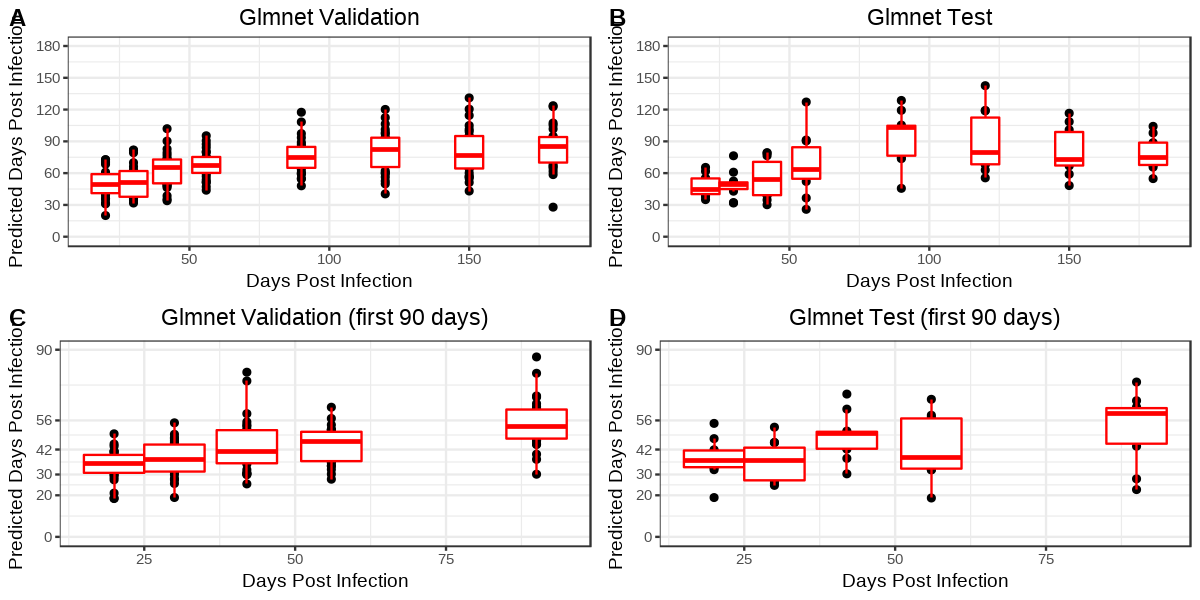

In [346]:
test.model = data.frame(obs=pheno.test$time.point, pred=log2.pred.test)

test.model.90 = data.frame(obs=time.point.90, pred=log2.pred.test.90)

glm.graph.val = generate.regres.graph(log2.models$glmnet$pred, "Glmnet Validation", T)
glm.graph.test = generate.regres.graph(test.model, "Glmnet Test")

glm.graph.val.90 = generate.regres.graph(log2.models.90$glmnet$pred, "Glmnet Validation (first 90 days)", T, break.90=T)
glm.graph.test.90 = generate.regres.graph(test.model.90, "Glmnet Test (first 90 days)", break.90=T)


allregressions= plot_grid(glm.graph.val,
                          glm.graph.test,
                          glm.graph.val.90,
                          glm.graph.test.90,
                          labels = toupper(c(letters[1:4], align="h")))

allregressions

#save_plot(paste(figures.dir, "R03_paper_Monocytes_Figure3.pdf", sep="/"), Figure_3, nrow=1, ncol=2)

###### Load everything without log transformed results, the test results do look better. I think I do need to be simpler and not have different log transform for validation vs. test. I am going to go ahead and do not log transformed, as it is better on test set.

- Log transform vs. not log transform makes only subtle changes between the two visually for the whole dataset, there is dramatic difference in test set for time 56 in the 90 days example. I am going to just not do log transformation. it seems that hte model generalizes 

In [387]:
load("data/analysis_results/Monkey-TB-caret-middlelate-regression-glmnet grid tuning with 1000 samples_looking everywhere_alltimepoints_round2-2018-05-29-.RData")

Validation (whole dataset)

In [388]:
val.models = models
val.pred = val.models$glmnet$pred
all.metrics(val.pred$obs, val.pred$pred)

[1] "Root Mean Squared Error (RMSE)"
[1] 47.9037
[1] "Mean Absolute Error"
[1] 39.67415
[1] "Median Absolute Error"
[1] 38.52282
[1] "Pearson Correlation Coefficient"
[1] 0.4801681
[1] "Pearson Correlation Signifcance Test"

	Pearson's product-moment correlation

data:  truth and pred
t = 7.8947, df = 208, p-value = 1.646e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3687502 0.5779838
sample estimates:
      cor 
0.4801681 

[1] "Spearman Correlation Signifcance Test"


Warning message in cor.test.default(truth, pred, method = "spearman"):
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  truth and pred
S = 739550, p-value = 5.323e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5208519 

[1] "R squared"
[1] 0.2305615


Test data (whole dataset)

In [389]:
model.glm = models$glmnet
pred.test = predict(model.glm, newdata = expres.test)
time.point.obs = pheno.test$time.point

In [390]:
all.metrics(time.point.obs, pred.test)

[1] "Root Mean Squared Error (RMSE)"
[1] 45.48553
[1] "Mean Absolute Error"
[1] 38.5541
[1] "Median Absolute Error"
[1] 35.73838
[1] "Pearson Correlation Coefficient"
[1] 0.540563
[1] "Pearson Correlation Signifcance Test"

	Pearson's product-moment correlation

data:  truth and pred
t = 5.8184, df = 82, p-value = 1.11e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3689239 0.6765500
sample estimates:
     cor 
0.540563 

[1] "Spearman Correlation Signifcance Test"


Warning message in cor.test.default(truth, pred, method = "spearman"):
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  truth and pred
S = 38710, p-value = 8.531e-10
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6080807 

[1] "R squared"
[1] 0.2922083


In [391]:
load("data//analysis_results//Monkey-TB-caret-middlelate-regression-glmnet grid tuning with 1000 samples_looking everywhere_first90days_round1-2018-05-29-.RData")

Validation data (90 days)

In [392]:
models.90 = models
val.pred.90 = models.90$glmnet$pred
all.metrics(val.pred.90$obs, val.pred.90$pred)


[1] "Root Mean Squared Error (RMSE)"
[1] 20.93578
[1] "Mean Absolute Error"
[1] 16.82354
[1] "Median Absolute Error"
[1] 15.81092
[1] "Pearson Correlation Coefficient"
[1] 0.5150351
[1] "Pearson Correlation Signifcance Test"

	Pearson's product-moment correlation

data:  truth and pred
t = 6.9033, df = 132, p-value = 1.928e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3785070 0.6296292
sample estimates:
      cor 
0.5150351 

[1] "Spearman Correlation Signifcance Test"


Warning message in cor.test.default(truth, pred, method = "spearman"):
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  truth and pred
S = 188780, p-value = 4.899e-11
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5292228 

[1] "R squared"
[1] 0.2652611


Test data (90 days)

In [393]:
model.glm = models$glmnet
pred.test.90 = predict(model.glm, newdata = expres.test[pheno.test$time.point <= 90,])

In [394]:
time.point.90 = filter(pheno.test, time.point <= 90)$time.point
all.metrics(time.point.90, pred.test.90)

[1] "Root Mean Squared Error (RMSE)"
[1] 22.09972
[1] "Mean Absolute Error"
[1] 16.96541
[1] "Median Absolute Error"
[1] 14.25824
[1] "Pearson Correlation Coefficient"
[1] 0.4554343
[1] "Pearson Correlation Signifcance Test"

	Pearson's product-moment correlation

data:  truth and pred
t = 3.7243, df = 53, p-value = 0.0004761
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2162678 0.6430364
sample estimates:
      cor 
0.4554343 

[1] "Spearman Correlation Signifcance Test"


Warning message in cor.test.default(truth, pred, method = "spearman"):
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  truth and pred
S = 14542, p-value = 0.0002446
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4754011 

[1] "R squared"
[1] 0.2074204


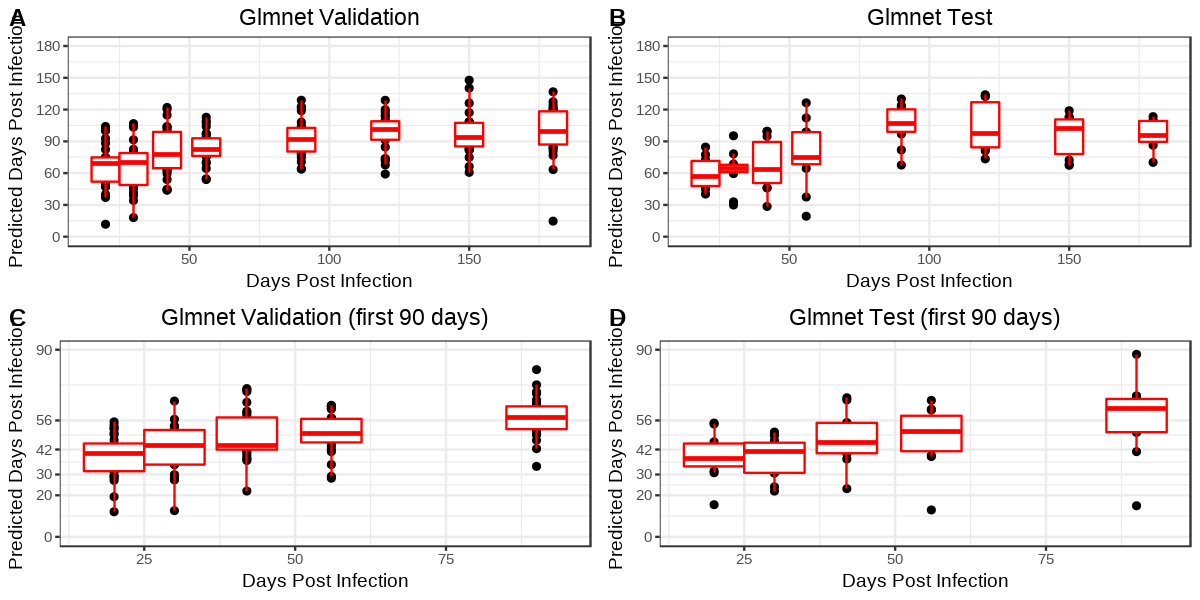

In [378]:
#test.model.90 = data.frame(obs=time.point.90, pred=pred.test.90)
#glm.graph.test.90 = generate.regres.graph(test.model.90, "Glmnet Test (first 90 days)", break.90=T)
#glm.graph.test.90

test.model = data.frame(obs=pheno.test$time.point, pred=pred.test)

test.model.90 = data.frame(obs=time.point.90, pred=pred.test.90)

glm.graph.val = generate.regres.graph(val.pred, "Glmnet Validation")
glm.graph.test = generate.regres.graph(test.model, "Glmnet Test")

glm.graph.val.90 = generate.regres.graph(val.pred.90, "Glmnet Validation (first 90 days)", break.90=T)
glm.graph.test.90 = generate.regres.graph(test.model.90, "Glmnet Test (first 90 days)", break.90=T)


allregressions= plot_grid(glm.graph.val,
                          glm.graph.test,
                          glm.graph.val.90,
                          glm.graph.test.90,
                          labels = toupper(c(letters[1:4], align="h")))

allregressions

#save_plot(paste(figures.dir, "R03_paper_Monocytes_Figure3.pdf", sep="/"), Figure_3, nrow=1, ncol=2)

###### Load the best glmnet model so far and graph the cross-validation results with active and latent separated, with two different boxplots (loess curves wouldn't tell all the information)

- At later time points (>= 90 days) active samples are systematically predicted to be earlier than latent. Not a clear difference at earlier time points. For both active and latent the change from early to late time points in predictive accuracy is about the same.

- I think if I used a neural net and told it whether a monkey was active or latent, and had it predict that, then it might be able to predict time point better.

- As of 29 May 2018, I don't think I have enough statistical power for this comparison now in the test set. Alternatively, I could just show the data and say that I don't have enough power. Also, now with log2 transformed time point, the early time points are predicted earlier for the active TB group.

- Again, without the log transformed time point, there's not a clear difference for most time points in the validation or test set. I am going to stick with that.

In [347]:
regres.graph.a.l = function(data, label) {
    #q = qplot(obs, pred, data= data, geom = c("point", "smooth"), method="loess")
    q = ggplot(data, aes(obs, pred, fill=clinical.status)) +
        
        scale_y_continuous(breaks=c(0, 30, 60, 90 , 120, 150, 180), limits = c(0, 180)) +
        geom_point() + geom_smooth(method="loess") +
        geom_boxplot(outlier.shape=NA, width=10) +
        theme_bw() +
        labs(x="Days Post Infection", y="Predicted Days Post Infection") + 
        ggtitle(paste(label)) +  #, "regression in cynomolgus macaques")) +
        theme(plot.title = element_text(hjust = 0.5))
    
    return(q)
}

regres.graph.basic = function(data) {
    q = ggplot(data, aes(x=obs, y=pred, group = interaction(obs, clinical.status), fill=clinical.status)) + 
    scale_y_continuous(breaks=c(0, 30, 60, 90 , 120, 150, 180), limits = c(0, 180)) +
    geom_point(aes(color=clinical.status)) + geom_smooth(method="loess") +
    geom_boxplot(outlier.shape=NA) +
    theme_bw()
}

#ggplot(d, aes(x = x, y = y, group = interaction(x, grp), fill = grp)) +
#  geom_boxplot()

In [379]:
load("data/analysis_results/Monkey-TB-caret-middlelate-regression-glmnet grid tuning with 1000 samples_looking everywhere_alltimepoints_round2-2018-05-29-.RData")

In [380]:
glm.mod = models$glmnet$pred
glm.mod$clinical.status = pheno.train$clinical.status[glm.mod$rowIndex]
#glm.mod$obs = 2 ^ glm.mod$obs
#glm.mod$pred = 2 ^ glm.mod$pred

In [381]:
model.glm = models$glmnet
pred.test = predict(model.glm, newdata = expres.test)

In [382]:
log2.pred.test = pred.test


test.model = data.frame(obs=pheno.test$time.point, pred=log2.pred.test, clinical.status=pheno.test$clinical.status)



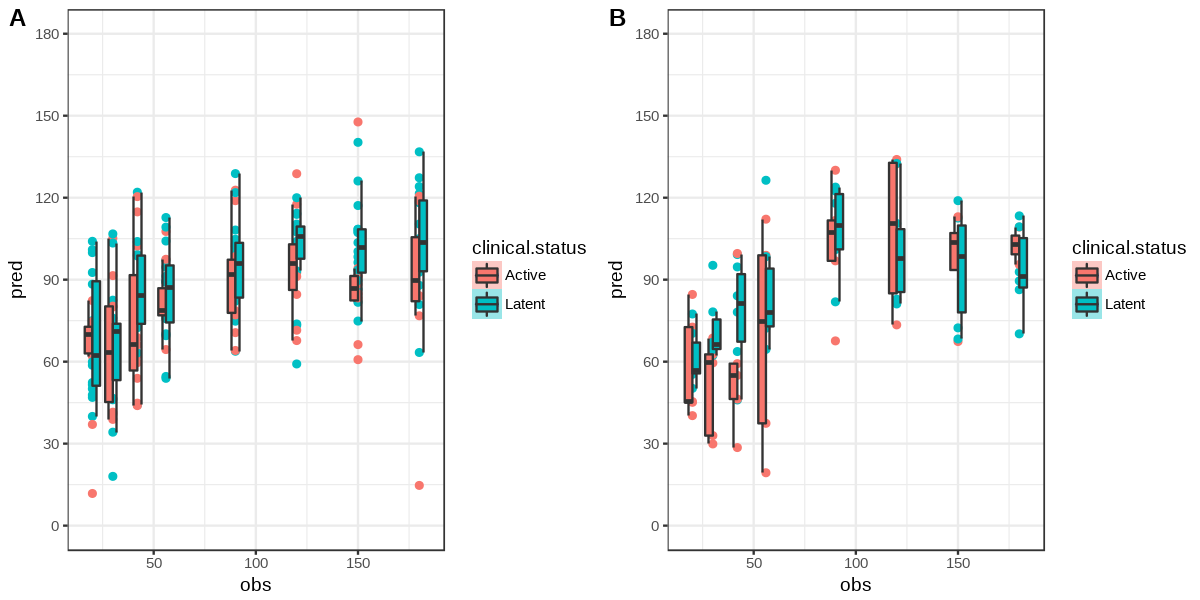

In [383]:
# Make R graphs smaller
options(repr.plot.width=10, repr.plot.height=5)

glm.graph.val = regres.graph.basic(glm.mod)
glm.graph.test = regres.graph.basic(test.model)

allregressions= plot_grid(glm.graph.val,
                          glm.graph.test,
                          
                          labels = toupper(c(letters[1:2], align="h")))

allregressions

#save_plot(paste(figures.dir, "R03_paper_Monocytes_Figure3.pdf", sep="/"), Figure_3, nrow=1, ncol=2)

###### Graphing glmnet hyperparameter tuning for the 500 random grid as well as 50 random grid with log2 transformed time point. Interestingly, log transforming the time point to be predicted alters the optimum parameters substantially.

In [288]:
load('data/analysis_results/Monkey-TB-caret-middlelate-regression-500 length random grid-2018-05-14-.RData')

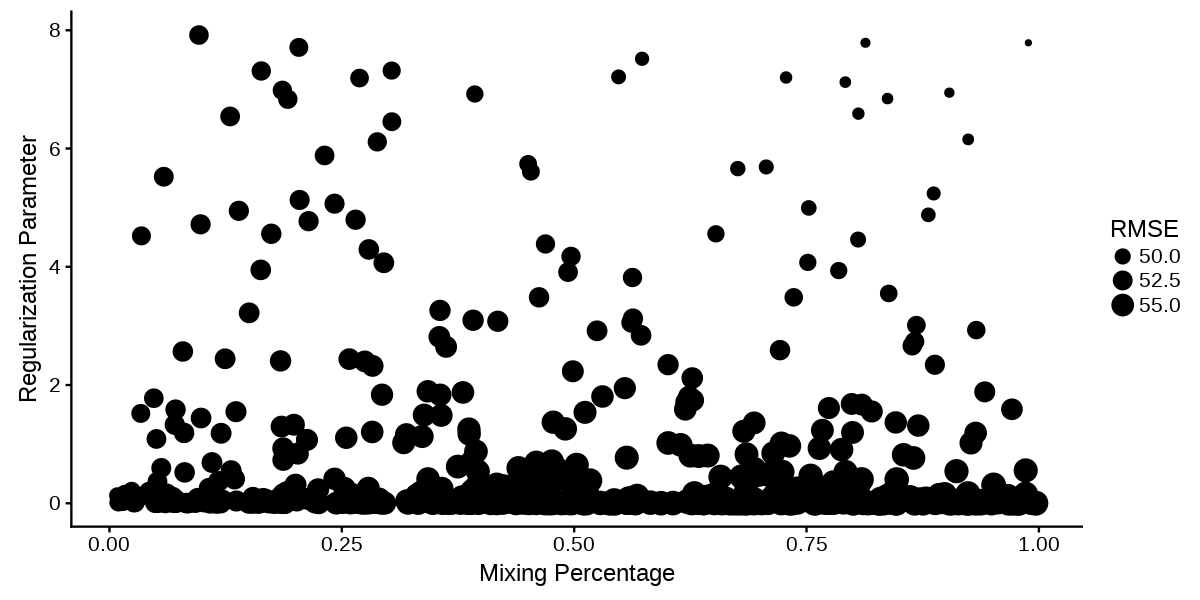

In [289]:
ggplot(models$glmnet)

In [290]:
load('data//analysis_results/Monkey-TB-caret-middlelate-regression-50 length random grid_timepointlogtransformed_finalpredssaved-2018-05-18-.RData')

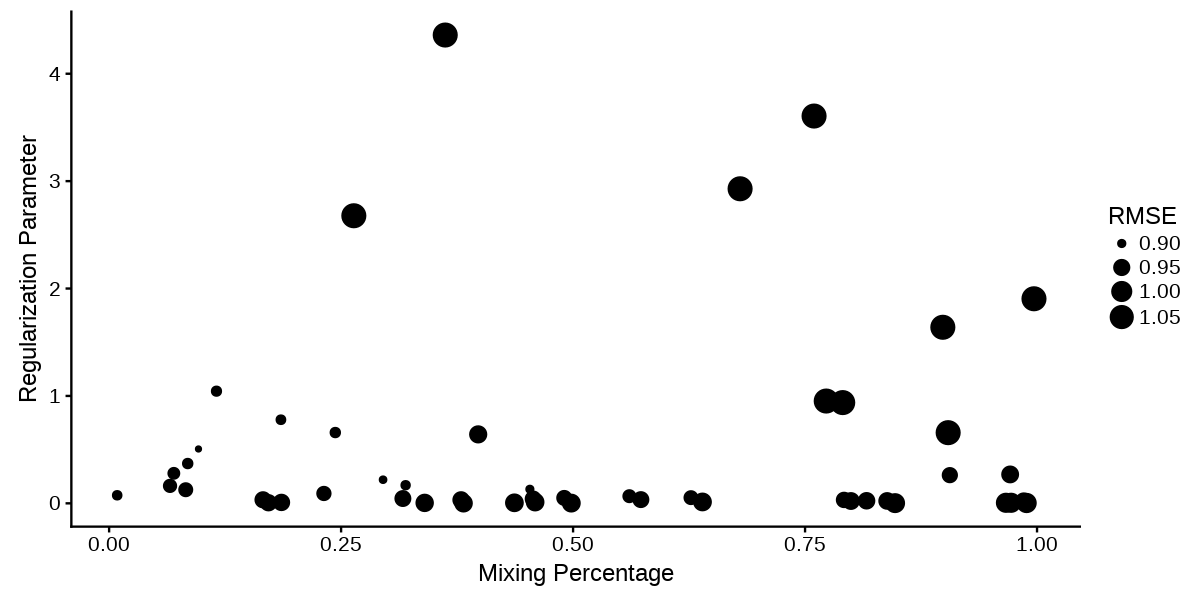

In [291]:
ggplot(models$glmnet)

###### I am now ready to write up the results of figure 2!!!

### Gene Analysis for Mice and Monkeys
- For now I will focus on the classification task, as that is what I will be able to apply in humans.
- At some point I could do regression too if it could help

#### Analyze Top Predictive Genes in Monkeys

##### Pull glmnet weights for classificaion on monkeys

In [395]:
# Despite the name, this was actually with 100 values for the parameters
# This was the best classification model
load("data/analysis_results/Monkey-TB-caret-middlelate-classification-glmnet grid tuning with 50 samples_round4-2018-05-25-.RData")

In [447]:
import = varImp(models$glmnet,scale=F)
import

glmnet variable importance

  only 20 most important variables shown (out of 9050)

             Overall
ILMN_1691458  0.3885
ILMN_1762436  0.3216
ILMN_3250201  0.2742
ILMN_1745764  0.2137
ILMN_1802654  0.2078
ILMN_1679238  0.2048
ILMN_1844862  0.1752
ILMN_1801119  0.1587
ILMN_1719857  0.1555
ILMN_1847159  0.1553
ILMN_1779190  0.1468
ILMN_1712352  0.1423
ILMN_2308689  0.1418
ILMN_1690970  0.1412
ILMN_3255931  0.1409
ILMN_1745447  0.1304
ILMN_1745374  0.1263
ILMN_1687922  0.1233
ILMN_1804306  0.1229
ILMN_1677446  0.1160

In [515]:
my.glmnet.model = models$glmnet$finalModel

coefs.monkey.class = coef(my.glmnet.model, s=models$glmnet$bestTune$lambda)
#coef(models$glmnet$finalModel, models$glmnet$finalModel$lambdaOpt)

nonzero.coefs = data.frame(name = coefs.monkey.class@Dimnames[[1]][coefs.monkey.class@i + 1], coefficient = coefs.monkey.class@x)
sort.coeffs = nonzero.coefs[order(-abs(nonzero.coefs$coefficient)), ]#, sort(abs(nonzero.coefs$coefficient), T)

In [432]:
dim(nonzero.coefs)

[1] 177   2

##### Description of the top 20 probes from uniprot and mentioned publications

 Top 20 Probes for the Monkey Classification Best Model (glmnet). The model reduced 9050 probes to 177 used in the final model. I could use elastic net itself or more LASSO arbitrarily to get the gene number down.

157	ILMN_1691458	0.38845701 SYPL1	SYPL; H-SP1
168	ILMN_1762436	-0.32162485 UBB	ubiquitin B
31	ILMN_3250201	-0.27424730
48	ILMN_1745764	-0.21367881
55	ILMN_1802654	-0.20777269
83	ILMN_1679238	0.20480036
119	ILMN_1844862	-0.17515573
12	ILMN_1801119	-0.15869004
57	ILMN_1719857	0.15545924
70	ILMN_1847159	0.15528421
8	ILMN_1779190	-0.14676444
37	ILMN_1712352	-0.14227567
6	ILMN_2308689	-0.14181756
97	ILMN_1690970	-0.14121725
88	ILMN_3255931	0.14094348
61	ILMN_1745447	-0.13035258
75	ILMN_1745374	-0.12627226
135	ILMN_1687922	-0.12327305
107	ILMN_1804306	-0.12289391
165	ILMN_1677446	-0.11603975

These are the matching genes:
Genetics home reference has some explanations:
https://ghr.nlm.nih.gov/gene/CNBP
Uniprote is giving me good first information:
https://www.uniprot.org/uniprot/Q9H1C3

$ILMN_1691458
'SYPL1'
$ILMN_1762436
'UBB'
Polyubiquitin-B
$ILMN_3250201
'CNBP'
https://ghr.nlm.nih.gov/gene/CNBP
$ILMN_1745764
'ESYT3'
Extended synaptotagmin-3
A recent cell paper about this protein and its family mebers. it is an ER protein that mediates interactions with the plasma membrane.
https://www-ncbi-nlm-nih-gov.proxy.lib.ohio-state.edu/pubmed/23791178
$ILMN_1802654
'GLT8D2'
Glycosyltransferase 8 domain-containing protein 2
$ILMN_1679238
'LENG1'
Leukocyte receptor cluster member 1
$ILMN_1844862
'NSL1'
Kinetochore-associated protein NSL1 homolog
Part of the MIS12 complex which is required for normal chromosome alignment and segregation and kinetochore formation during mitosis.
http://jcb.rupress.org.proxy.lib.ohio-state.edu/content/173/1/9.long
$ILMN_1801119
'BCL2'
Suppresses apoptosis in a variety of cell systems including factor-dependent lymphohematopoietic and neural cells. Regulates cell death by controlling the mitochondrial membrane permeability. Appears to function in a feedback loop system with caspases. Inhibits caspase activity either by preventing the release of cytochrome c from the mitochondria and/or by binding to the apoptosis-activating factor (APAF-1). May attenuate inflammation by impairing NLRP1-inflammasome activation, hence CASP1 activation and IL1B release (PubMed:17418785).
$ILMN_1719857
'GRIPAP1'
Regulates the endosomal recycling back to the neuronal plasma membrane, possibly by connecting early and late recycling endosomal domains and promoting segregation of recycling endosomes from early endosomal membranes. Involved in the localization of recycling endosomes to dendritic spines, thereby playing a role in the maintenance of dendritic spine morphology. Required for the activity-induced AMPA receptor recycling to dendrite membranes and for long-term potentiation and synaptic plasticity (By similarity)
GRIP1-associated protein 1
$ILMN_1847159
NA
$ILMN_1779190
'ALKBH8'
Alkylated DNA repair protein alkB homolog 8
Catalyzes the methylation of 5-carboxymethyl uridine to 5-methylcarboxymethyl uridine at the wobble position of the anticodon loop in tRNA via its methyltransferase domain (PubMed:20123966, PubMed:20308323). Catalyzes the last step in the formation of 5-methylcarboxymethyl uridine at the wobble position of the anticodon loop in target tRNA (PubMed:20123966, PubMed:20308323). Has a preference for tRNA(Arg) and tRNA(Glu), and does not bind tRNA(Lys)(PubMed:20308323). Binds tRNA and catalyzes the iron and alpha-ketoglutarate dependent hydroxylation of 5-methylcarboxymethyl uridine at the wobble position of the anticodon loop in tRNA via its dioxygenase domain, giving rise to 5-(S)-methoxycarbonylhydroxymethyluridine; has a preference for tRNA(Gly) (PubMed:21285950). Required for normal survival after DNA damage (PubMed:20308323). May inhibit apoptosis and promote cell survival and angiogenesis (PubMed:19293182).
$ILMN_1712352
'DOCK3'
Dedicator of cytokinesis protein 3
Potential guanine nucleotide exchange factor (GEF). GEF proteins activate some small GTPases by exchanging bound GDP for free GTP. Its interaction with presenilin proteins as well as its ability to stimulate Tau/MAPT phosphorylation suggest that it may be involved in Alzheimer disease. Ectopic expression in nerve cells decreases the secretion of amyloid-beta APBA1 protein and lowers the rate of cell-substratum adhesion, suggesting that it may affect the function of some small GTPase involved in the regulation of actin cytoskeleton or cell adhesion receptors (By similarity).
$ILMN_2308689
'AGBL5'
Cytosolic carboxypeptidase-like protein 5
Metallocarboxypeptidase that mediates protein deglutamylation. Specifically catalyzes the deglutamylation of the branching point glutamate side chains generated by post-translational glutamylation in proteins such as tubulins. In contrast, it is not able to act as a long-chain deglutamylase that shortens long polyglutamate chains, a process catalyzed by AGTPBP1/CCP1, AGBL2/CCP2, AGBL3/CCP3, AGBL1/CCP4 and AGBL4/CCP6. Mediates deglutamylation of CGAS, regulating the antiviral activity of CGAS.
$ILMN_1690970
'LINC00892'
LINC00892 long intergenic non-protein coding RNA 892 [ Homo sapiens (human) ]
$ILMN_3255931
'LOC100129297'
Homo sapiens gene LOC100129297, encoding hypothetical protein LOC100129297.
$ILMN_1745447
'HIVEP2'
Transcription factor HIVEP2
This protein specifically binds to the DNA sequence 5'-GGGACTTTCC-3' which is found in the enhancer elements of numerous viral promoters such as those of SV40, CMV, or HIV1. In addition, related sequences are found in the enhancer elements of a number of cellular promoters, including those of the class I MHC, interleukin-2 receptor, somatostatin receptor II, and interferon-beta genes. It may act in T-cell activation.
$ILMN_1745374
'IFI35'
Interferon-induced 35 kDa protein
Function not yet known
$ILMN_1687922
'RP9'
Retinitis pigmentosa 9 protein
Is thought to be a target protein for the PIM1 kinase. May play some roles in B-cell proliferation in association with PIM1
$ILMN_1804306
'LYPLA2'
Acyl-protein thioesterase 2
Hydrolyzes fatty acids from S-acylated cysteine residues in proteins such as trimeric G alpha proteins, GAP43, ZDHHC6 or HRAS (PubMed:21152083, PubMed:28826475). Deacylates GAP43 (PubMed:21152083). Mediates depalmitoylation of ZDHHC6 (PubMed:28826475). Has lysophospholipase activity (By similarity).
$ILMN_1677446
'TMEM189' 'TMEM189-UBE2V1'
Transmembrane protein 189
TMEM189/KUA and UBE2V1/UEV1 are adjacent genes which can produce independent proteins and can also be fused to form a TMEM189-UBE2V1 hybrid protein.
"Fusion of the human gene for the polyubiquitination coeffector UEV1 with Kua, a newly identified gene." a publication


##### Converting Illumina IDs to gene names

In [457]:
#source("https://bioconductor.org/biocLite.R")
#biocLite("illuminaHumanv4.db")

In [458]:
# library("illuminaHumanv4.db")

In [454]:
symbold <- mapIds(illuminaHumanv4.db, as.character(sort.coeffs$name[2:dim(sort.coeffs)[1]]), "SYMBOL","PROBEID", multiVals = "list")

'select()' returned 1:many mapping between keys and columns


##### Graph the top 20 genes, and then graph the whole 177 genes. See what patterns they have over time. Here is for the classification genes.

What i want is for time points in validation set and test set the mean and standard error of mean. That would tell me what I need to know, I think. Or look to the authors of their own data. Okay, in their PRDX2 graph of active vs. latent, they did mean +- 95% CI. For me I think more informative is median +- IQR. Essentially I want to graph box plots. But I'd like to overlay too.
I'll graph a line graph with median +- IQR

In [461]:
dim(expres.train.point$t)

[1]  210 9051

In [469]:
library(reshape)


Attaching package: ‘reshape’

The following objects are masked from ‘package:plyr’:

    rename, round_any

The following objects are masked from ‘package:S4Vectors’:

    expand, rename

The following object is masked from ‘package:dplyr’:

    rename

The following object is masked from ‘package:Matrix’:

    expand



In [557]:
expres.train.point = data.frame(expres.train, time.point=pheno.train$time.point)
expres.test.point = data.frame(expres.test, time.point=pheno.test$time.point)

In [558]:

genes.coefs = sort.coeffs$name[2:length(sort.coeffs$name)]
genes.coefs = genes.coefs[1:10]

In [559]:
expres.train.point.genes = expres.train.point[,colnames(expres.train.point) %in% c(as.character(genes.coefs), "time.point")]
expres.test.point.genes = expres.test.point[,colnames(expres.test.point) %in% c(as.character(genes.coefs), "time.point")]
#expres.train.point
dim(expres.train.point.genes)

[1] 210  11

In [560]:
long.exprs = melt(expres.train.point.genes,
                  id = c("time.point"),
                 measured = colnames(expres.train.point.genes)[1:length(genes.coefs)])
long.exprs.test = melt(expres.test.point.genes,
                  id = c("time.point"),
                 measured = colnames(expres.test.point.genes)[1:length(genes.coefs)])

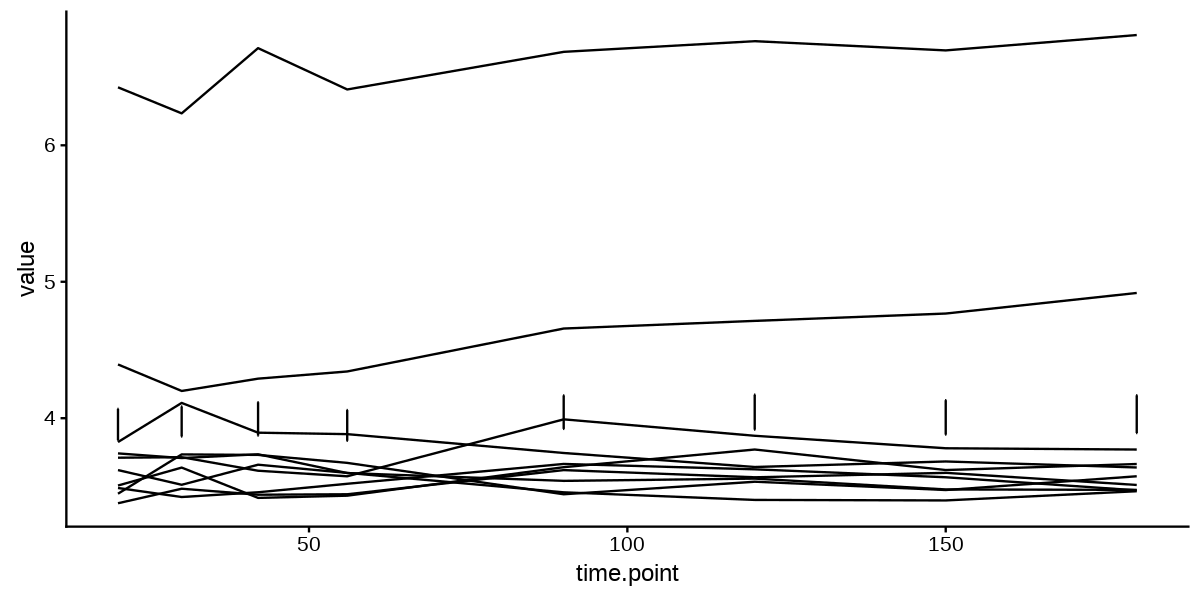

In [561]:
#install.packages("Hmisc")

#library("Hmisc")

# I think I can just go with the confidence interval looking at an individual gene
# I can alternatively look at boxplots as I've done before for time points.

# I can just filter by gene name for the graph, or do a loop for the dataset used.
# I should definitely look at the 20 graphs this way. I can also overlay them by the gene name, using that as a grouping variable
# Just filter the dataframe first. This really won't be too hard to get a good graph
# I think the melting and dplyr way is the best way

#https://www.researchgate.net/post/How_can_I_calculate_the_average_values_in_dataframe_with_R

# https://onunicornsandgenes.blog/2014/03/25/using-r-quickly-calculating-summary-statistics-from-a-data-frame/

# This code below I got from youtube. I may want to watch all of it. I was at about minute 18
#https://www.youtube.com/watch?v=Tfd5LKiYyLs

# I need to be able to color these and label them in some way! On the mean I basically do see a bunch of linear relationships, with some potential blips
# Most of the genes go up over time.
exprs.line = ggplot(long.exprs, aes(time.point, value))
exprs.line + stat_summary(fun.y = mean, geom = "line", aes(group=variable)) + stat_summary(fun.data = mean_cl_normal,
                                                                                   geom="errorbar", width=0.2)#, aes(group=variable))

THe lower expressed genes have a complicated behavior. A lot of them are not strictly linear. It would be great to do linear gregressions for each gene and color based on the sign of the slope parameter. Also for my visualization, I can graph and then facet and linear regression. It would be good to compare top 10 genes between training and test. The top 10 genes are generally agreeable in trend between training and test set, just like the top 20, but they don't look enriched in better looking genes.

I am thinking for visualization now that regression may give better gene sets. These will be ones that change more consistently over time. Classification doesn't have as hard of constraints as regression has. Actually, this would probably be better for the cross-species comparison too, more consistency (if my hypothesis of consistency for regression variables is true).

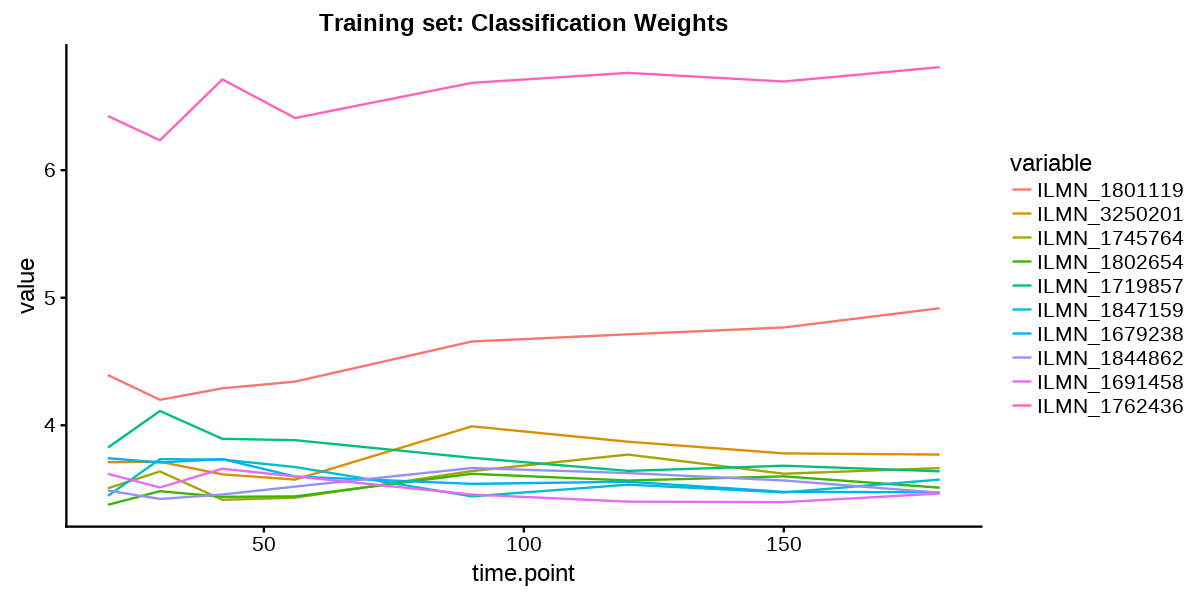

In [564]:
exprs.line = ggplot(long.exprs, aes(time.point, value, color = variable))
exprs.line + stat_summary(fun.y = mean, geom = "line", aes(group=variable)) +ggtitle("Training set: Classification Weights") #+  ylim(3.3,4)  #+ stat_summary(fun.data = mean_cl_normal,
                                                                                  # geom="errorbar", width=0.2)#, aes(group=variable))

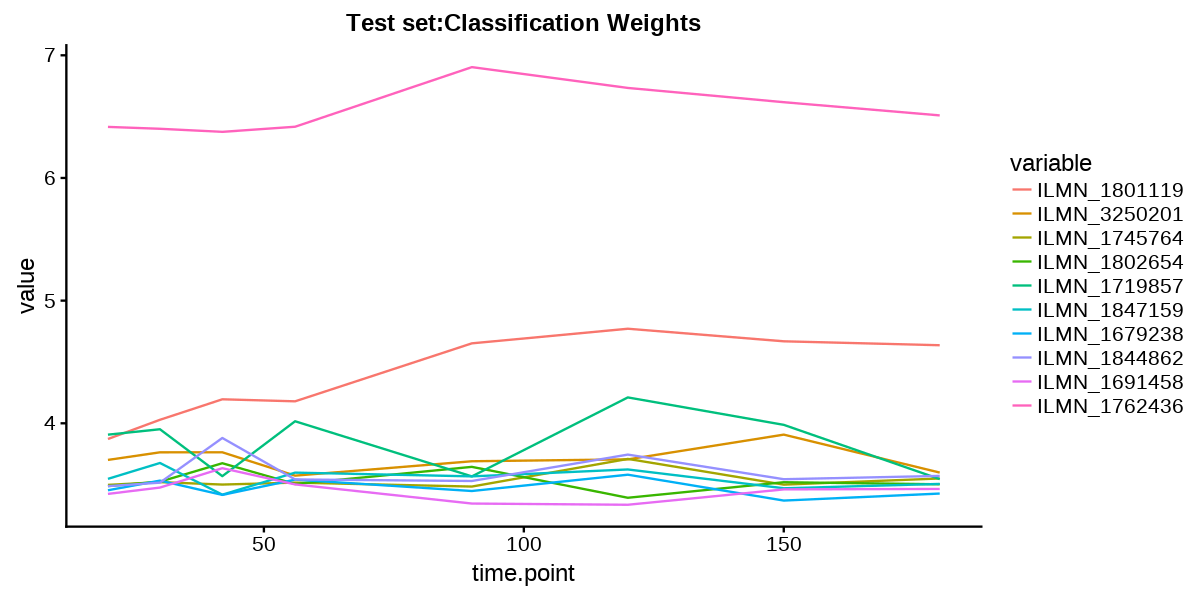

In [565]:
exprs.line.test = ggplot(long.exprs.test, aes(time.point, value, color = variable))
exprs.line.test + stat_summary(fun.y = mean, geom = "line", aes(group=variable))  + ggtitle("Test set:Classification Weights") # + ylim(3.3,4) #+ stat_summary(fun.data = mean_cl_normal,
                                                                                  # geom="errorbar", width=0.2)#, aes(group=variable))

In [472]:
colnames(expres.train.point)[1:9050]

[1] "ILMN_2055271" "ILMN_1814092" "ILMN_2061446" "ILMN_3237396"
   [5] "ILMN_1688755" "ILMN_1880387" "ILMN_1653165" "ILMN_1662364"
   [9] "ILMN_1700461" "ILMN_1698189" "ILMN_2096191" "ILMN_1687609"
  [13] "ILMN_1699334" "ILMN_1758523" "ILMN_1794965" "ILMN_1795507"
  [17] "ILMN_1743205" "ILMN_1665730" "ILMN_2193980" "ILMN_1709092"
  [21] "ILMN_1706531" "ILMN_3244070" "ILMN_1772189" "ILMN_1674032"
  [25] "ILMN_1676846" "ILMN_1781999" "ILMN_1810085" "ILMN_1658176"
  [29] "ILMN_2329927" "ILMN_1779470" "ILMN_2318685" "ILMN_1794213"
  [33] "ILMN_2227533" "ILMN_2403446" "ILMN_1723662" "ILMN_1700633"
  [37] "ILMN_1655702" "ILMN_1706344" "ILMN_1712707" "ILMN_1739081"
  [41] "ILMN_1724497" "ILMN_1755658" "ILMN_1713732" "ILMN_1785424"
  [45] "ILMN_1731610" "ILMN_2396672" "ILMN_1656940" "ILMN_1655114"
  [49] "ILMN_2367165" "ILMN_1660199" "ILMN_1775579" "ILMN_1778104"
  [53] "ILMN_1795104" "ILMN_1806408" "ILMN_2352009" "ILMN_3236270"
  [57] "ILMN_1800008" "ILMN_1708672" "ILMN_1665945" "ILMN_1684271"
  [61] "ILMN_3187680" "ILMN_1716480" "ILMN_3235340" "ILMN_3237774"
  [65] "ILMN_2134039" "ILMN_1750800" "ILMN_1654861" "ILMN_1715543"
  [69] "ILMN_2353978" "ILMN_1716237" "ILMN_2156699" "ILMN_1740265"
  [73] "ILMN_2332250" "ILMN_1679600" "ILMN_2367070" "ILMN_1658995"
  [77] "ILMN_1685703" "ILMN_2344956" "ILMN_2078599" "ILMN_1706598"
  [81] "ILMN_1758323" "ILMN_1728331" "ILMN_2360705" "ILMN_2391458"
  [85] "ILMN_1683598" "ILMN_2370882" "ILMN_1705247" "ILMN_1737418"
  [89] "ILMN_2278242" "ILMN_1685952" "ILMN_1771084" "ILMN_1752269"
  [93] "ILMN_2336595" "ILMN_1714197" "ILMN_1749297" "ILMN_2328280"
  [97] "ILMN_1665691" "ILMN_2388605" "ILMN_1657153" "ILMN_1652594"
 [101] "ILMN_1697585" "ILMN_1689162" "ILMN_1815392" "ILMN_1760490"
 [105] "ILMN_2243308" "ILMN_2152711" "ILMN_2319825" "ILMN_1694233"
 [109] "ILMN_2158705" "ILMN_1725043" "ILMN_2384544" "ILMN_1799728"
 [113] "ILMN_1751500" "ILMN_2121068" "ILMN_1765779" "ILMN_1708348"
 [117] "ILMN_1767362" "ILMN_1687035" "ILMN_3247424" "ILMN_2319326"
 [121] "ILMN_1679797" "ILMN_1657139" "ILMN_1698777" "ILMN_1663132"
 [125] "ILMN_1761309" "ILMN_2148944" "ILMN_1655935" "ILMN_2356786"
 [129] "ILMN_1787378" "ILMN_1775045" "ILMN_2096322" "ILMN_1688322"
 [133] "ILMN_2358626" "ILMN_1768062" "ILMN_1801020" "ILMN_1657993"
 [137] "ILMN_1666019" "ILMN_2080751" "ILMN_1747227" "ILMN_1807372"
 [141] "ILMN_1811480" "ILMN_1677868" "ILMN_2092664" "ILMN_1778796"
 [145] "ILMN_2240009" "ILMN_1736178" "ILMN_1803376" "ILMN_2333107"
 [149] "ILMN_1730995" "ILMN_1775235" "ILMN_1708502" "ILMN_2409898"
 [153] "ILMN_2066124" "ILMN_2402766" "ILMN_1767722" "ILMN_2342841"
 [157] "ILMN_1688627" "ILMN_2308689" "ILMN_2290776" "ILMN_1729777"
 [161] "ILMN_2257015" "ILMN_3260345" "ILMN_1703228" "ILMN_2064917"
 [165] "ILMN_1776153" "ILMN_1772645" "ILMN_2377430" "ILMN_1662049"
 [169] "ILMN_1740752" "ILMN_1794875" "ILMN_1698209" "ILMN_1770454"
 [173] "ILMN_1718071" "ILMN_1809139" "ILMN_1747504" "ILMN_1657862"
 [177] "ILMN_1680111" "ILMN_1792495" "ILMN_2162799" "ILMN_1703617"
 [181] "ILMN_1798308" "ILMN_1696512" "ILMN_1771827" "ILMN_3246401"
 [185] "ILMN_1717357" "ILMN_1668408" "ILMN_1688625" "ILMN_2312764"
 [189] "ILMN_1655645" "ILMN_3236458" "ILMN_1778173" "ILMN_2338038"
 [193] "ILMN_1764090" "ILMN_1712530" "ILMN_1718808" "ILMN_2293758"
 [197] "ILMN_1693220" "ILMN_1709101" "ILMN_1752247" "ILMN_1741572"
 [201] "ILMN_1768962" "ILMN_1802799" "ILMN_1658337" "ILMN_1687757"
 [205] "ILMN_1677043" "ILMN_2145396" "ILMN_1726906" "ILMN_2325612"
 [209] "ILMN_2325610" "ILMN_1665982" "ILMN_1747577" "ILMN_2385647"
 [213] "ILMN_1708323" "ILMN_2271875" "ILMN_1782939" "ILMN_2051381"
 [217] "ILMN_2096372" "ILMN_1709348" "ILMN_1748538" "ILMN_1802167"
 [221] "ILMN_1793859" "ILMN_1794825" "ILMN_2401641" "ILMN_1696099"
 [225] "ILMN_1785284" "ILMN_1763461" "ILMN_2365176" "ILMN_1736700"
 [229] "ILMN_1755974" "ILMN_3251482" "ILMN_1743995" "ILMN_1761456"
 [233] "ILMN_1743635" "ILMN_1711886" "ILMN_1664449" "ILMN_1685413"
 [237] "ILMN_1732809" "ILMN_1758038" "ILMN_2375973

In [468]:
ddply(expres.train.point, ~time.point, median)

ERROR: Error in median.default(piece, ...): need numeric data


In [ ]:
ddply(dfx, .(group, sex), summarize

In [462]:
baseball

id        year stint team lg g   ab  r  h   X2b ⋯ rbi sb cs bb  so  ibb
4     ansonca01 1871 1     RC1     25  120 29  39 11  ⋯ 16  6  2   2  1   NA 
44    forceda01 1871 1     WS3     32  162 45  45  9  ⋯ 29  8  0   4  0   NA 
68    mathebo01 1871 1     FW1     19   89 15  24  3  ⋯ 10  2  1   2  0   NA 
99    startjo01 1871 1     NY2     33  161 35  58  5  ⋯ 34  4  2   3  0   NA 
102   suttoez01 1871 1     CL1     29  128 35  45  3  ⋯ 23  3  1   1  0   NA 
106   whitede01 1871 1     CL1     29  146 40  47  6  ⋯ 21  2  2   4  1   NA 
113   yorkto01  1871 1     TRO     29  145 36  37  5  ⋯ 23  2  2   9  1   NA 
121   ansonca01 1872 1     PH1     46  217 60  90 10  ⋯ 50  6  6  16  3   NA 
143   burdoja01 1872 1     BR2     37  174 26  46  3  ⋯ 15  0  1   1  1   NA 
167   forceda01 1872 1     TRO     25  130 40  53 11  ⋯ 16  2  2   1  0   NA 
168   forceda01 1872 2     BL1     19   95 29  41  2  ⋯ 13  3  0   1  0   NA 
186   hinespa01 1872 1     WS4     11   49  9  12  1  ⋯  5  0  0   0  0   NA 
209   mathebo01 1872 1     BL1     50  223 36  50  1  ⋯ 21  1  1   3  2   NA 
226   nelsoca01 1872 1     TRO      4   20  2   7  0  ⋯  4  0  0   0  2   NA 
227   nelsoca01 1872 2     BR1     18   76 12  19  2  ⋯  8  1  0   2  2   NA 
229   orourji01 1872 1     MID     23  101 25  31  4  ⋯ 12  1  0   2  0   NA 
249   startjo01 1872 1     NY2     55  282 62  76  4  ⋯ 50  3  3   0  0   NA 
252   suttoez01 1872 1     CL1     22  107 30  30  6  ⋯ 10  1  0   1  1   NA 
259   whitede01 1872 1     CL1     22  109 21  37  2  ⋯ 22  0  0   4  1   NA 
268   yorkto01  1872 1     BL1     51  248 66  66 10  ⋯ 41  2  1   4  1   NA 
276   ansonca01 1873 1     PH1     52  254 53 101  9  ⋯ 36  0  2   5  1   NA 
293   burdoja01 1873 1     BR2     55  245 56  62  7  ⋯ 36  3  1   7  4   NA 
314   forceda01 1873 1     BL1     49  234 77  86  8  ⋯ 31  1  0   9  0   NA 
318   gerhajo01 1873 1     WS5     13   56  6  12  3  ⋯  7  0  0   0  5   NA 
327   hinespa01 1873 1     WS5     39  181 33  60  6  ⋯ 29  0  1   1  1   NA 
344   mathebo01 1873 1     NY2     52  223 40  43  3  ⋯ 13  1  1  10  3   NA 
353   nelsoca01 1873 1     NY2     36  168 28  55  4  ⋯ 22  2  0   1  2   NA 
355   orourji01 1873 1     BS1     57  280 79  98 19  ⋯ 48  4  2  14  1   NA 
375   snydepo01 1873 1     WS5     28  108 16  21  2  ⋯  4  0  1   3  3   NA 
377   startjo01 1873 1     NY2     53  251 42  67  8  ⋯ 28  1  0   4  0   NA 
⋮     ⋮         ⋮    ⋮     ⋮    ⋮  ⋮   ⋮   ⋮  ⋮   ⋮   ⋱ ⋮   ⋮  ⋮  ⋮   ⋮   ⋮  
89460 guarded01 2007 1     CIN  NL  15   0  0   0  0  ⋯  0   0 0    0   0  0 
89462 griffke02 2007 1     CIN  NL 144 528 78 146 24  ⋯ 93   6 1   85  99 14 
89463 greensh01 2007 1     NYN  NL 130 446 62 130 30  ⋯ 46  11 1   37  62  4 
89464 graffto01 2007 1     MIL  NL  86 231 34  55  8  ⋯ 30   0 1   24  44  6 
89465 gordoto01 2007 1     PHI  NL  44   0  0   0  0  ⋯  0   0 0    0   0  0 
89466 gonzalu01 2007 1     LAN  NL 139 464 70 129 23  ⋯ 68   6 2   56  56  4 
89467 gomezch02 2007 2     CLE  AL  19  53  4  15  2  ⋯  5   0 0    0   6  0 
89468 gomezch02 2007 1     BAL  AL  73 169 17  51 10  ⋯ 16   1 2   10  20  1 
89469 glavito02 2007 1     NYN  NL  33  56  3  12  1  ⋯  4   0 0    6   5  0 
89473 floydcl01 2007 1     CHN  NL 108 282 40  80 10  ⋯ 45   0 0   35  47  5 
89474 finlest01 2007 1     COL  NL  43  94  9  17  3  ⋯  2   0 0    8   4  1 
89480 embreal01 2007 1     OAK  AL   4   0  0   0  0  ⋯  0   0 0    0   0  0 
89481 edmonji01 2007 1     SLN  NL 117 365 39  92 15  ⋯ 53   0 2   41  75  2 
89482 easleda01 2007 1     NYN  NL  76 193 24  54  6  ⋯ 26   0 1   19  35  1 
89489 delgaca01 2007 1     NYN  NL 139 538 71 139 30  ⋯ 87   4 0   52 118  8 
89493 cormirh01 2007 1     CIN  NL   6   0  0   0  0  ⋯  0   0 0    0   0  0 
89494 coninje01 2007 2     NYN  NL  21  41  2   8  2  ⋯  5   0 0    7   8  2 
89495 coninje01 2007 1     CIN  NL  80 215 23  57 11  ⋯ 32   4 0   20  28  0 
89497 clemero02 2007 1     NYA  AL   2   2  0   1  0  ⋯  0   0 0    0   0  0 
89498 claytro01 2007 2     B

In [460]:
library(plyr)
ddply(baseball[1:100,], ~ year, nrow)
ddply(expres.train.point[1:])

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following object is masked from ‘package:IRanges’:

    desc

The following object is masked from ‘package:S4Vectors’:

    rename

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



year V1
1 1871  7
2 1872 13
3 1873 13
4 1874 15
5 1875 17
6 1876 15
7 1877 17
8 1878  3

##### Graph the top 20 genes, and then graph the whole 177 genes with a linear regression sign color. See what patterns they have over time. Here is for the regression genes, which I now think makes more sense than the classification genes. Honestly, I think regression genes could possibly perform better in classification since it is a hard problem and there is more specific phenotypic information.

- The regression genes definitely give less genes, only about 50 genes, more manageable
- I finished today being able to color genes by their regression slope (like Petkovich). Now what is the next step?

- It is clear how the regression model fits linear changes over time. It's then by inference clear that if the nolninear methods aren't doing better, they are probably fitting the same things (which we could show by graphing their important genes).
- I think I need to work straight towards prediction between mice and monkey, and at some point do a gene set enrichment analysis for the 50 genes chosen.

- I need to find out how to do variable importance for the cross-validation of the mice, I think, because this would be more informative than training on the whole set. I think what I've done with the monkey is fine.


- It would also be nice to add some thresholding to it, if the slope was greater than a certain value it would be colored, otherwise not.

In [544]:
load("data/analysis_results/Monkey-TB-caret-middlelate-regression-glmnet grid tuning with 1000 samples_looking everywhere_alltimepoints_round2-2018-05-29-.RData")

In [636]:
my.glmnet.model.r = models$glmnet$finalModel

coefs.monkey.regress = coef(my.glmnet.model.r, s=models$glmnet$bestTune$lambda)
#coef(models$glmnet$finalModel, models$glmnet$finalModel$lambdaOpt)

nonzero.coefs.r = data.frame(name = coefs.monkey.regress@Dimnames[[1]][coefs.monkey.regress@i + 1], coefficient = coefs.monkey.regress@x)
sort.coeffs.r = nonzero.coefs.r[order(-abs(nonzero.coefs.r$coefficient)), ]#, sort(abs(nonzero.coefs$coefficient), T)


genes.coefs.r = sort.coeffs.r$name[2:length(sort.coeffs.r$name)]
genes.coefs.r = genes.coefs.r[1:10]

expres.train.point.genes.r = expres.train.point[,colnames(expres.train.point) %in% c(as.character(genes.coefs.r), "time.point")]
expres.test.point.genes.r = expres.test.point[,colnames(expres.test.point) %in% c(as.character(genes.coefs.r), "time.point")]
#expres.train.point
dim(expres.train.point.genes.r)

long.exprs.r = melt(expres.train.point.genes.r,
                  id = c("time.point"),
                 measured = colnames(expres.train.point.genes.r)[1:length(genes.coefs.r)])
long.exprs.test.r = melt(expres.test.point.genes.r,
                  id = c("time.point"),
                 measured = colnames(expres.test.point.genes.r)[1:length(genes.coefs.r)])

[1] 210  11

In [623]:
which(long.exprs.r$variable[1000] == sloped$genes)

[1] 5

In [628]:

get_pos = function(data, sloped) {
    pos = rep(T, dim(data)[1])
    for (i in 1:length(pos)) {
    idx = which(data$variable[i] == sloped$genes)
    pos[i] = ifelse(sloped[idx, 2] > 0, T, F)
}
    return(pos)
}


In [627]:
head(pos)

[1] TRUE TRUE TRUE TRUE TRUE TRUE

In [637]:
long.pos = long.exprs.r
sloped = slope.finder(expres.train.point.genes.r, length(genes.coefs.r))
long.pos$pos = get_pos(long.exprs.r, sloped)
test.slope = slope.finder(expres.test.point.genes.r, length(genes.coefs.r))
long.pos.test = long.exprs.test.r
long.pos.test$pos = get_pos(long.exprs.test.r, test.slope)

In [632]:
head(filter(long.pos, variable=="ILMN_1663390"))

time.point variable     value    pos  
1  56        ILMN_1663390 4.815682 FALSE
2  90        ILMN_1663390 5.318506 FALSE
3 120        ILMN_1663390 4.200683 FALSE
4  90        ILMN_1663390 4.884595 FALSE
5 120        ILMN_1663390 4.739416 FALSE
6  42        ILMN_1663390 5.034324 FALSE

In [613]:
# Code to do linear models for each gene and extract the slope sign (positve or negative)

# This function returns a data frame with each gene and its slope for the time linear regression
slope.finder = function(data, ngenes) {
    slopes = as.numeric(rep(0.0, ngenes))
    for (i in 1:ngenes) {
        slopes[i] = lm(data[,i] ~ time.point, data)$coefficients[2]
        #print(slopes[i])
    }
    return(data.frame(genes=colnames(data)[1:ngenes], slopes=slopes))
}


In [600]:
length(genes.coefs.r)

[1] 100

In [603]:
dim(expres.train.point.genes.r)

[1] 210  51

In [616]:
which(sloped$genes == "ILMN_1801119")

[1] 3

In [614]:
sloped = slope.finder(expres.train.point.genes.r, length(genes.coefs.r))
#colnames(expres.train.point.genes.r)
sloped

genes        slopes       
1  ILMN_2308689  0.0016237441
2  ILMN_1779190  0.0031183907
3  ILMN_1801119  0.0041741513
4  ILMN_1805826  0.0032221518
5  ILMN_1712748  0.0017035049
6  ILMN_1777437  0.0011173348
7  ILMN_1811957  0.0031488449
8  ILMN_1663390 -0.0017895420
9  ILMN_2077680  0.0025888548
10 ILMN_1679826  0.0021712753
11 ILMN_2384181 -0.0053281254
12 ILMN_1712352  0.0009317574
13 ILMN_2365383 -0.0012121849
14 ILMN_1730731  0.0027498149
15 ILMN_1708105 -0.0021469031
16 ILMN_2364529 -0.0022263189
17 ILMN_1655307  0.0034317915
18 ILMN_2407464 -0.0012834384
19 ILMN_1671039 -0.0030978933
20 ILMN_1774077 -0.0074212868
21 ILMN_2106265 -0.0023114035
22 ILMN_2194627  0.0027945098
23 ILMN_1719857 -0.0022108859
24 ILMN_1789839  0.0026460579
25 ILMN_1861177  0.0010316532
26 ILMN_1837428  0.0021136837
27 ILMN_1799134  0.0041451275
28 ILMN_1679238 -0.0017579182
29 ILMN_2360401 -0.0015454877
30 ILMN_3255931 -0.0023538453
31 ILMN_1782487 -0.0084318313
32 ILMN_1666891  0.0008798156
33 ILMN_1806612  0.0018735334
34 ILMN_1805916  0.0026770586
35 ILMN_1721411 -0.0038047295
36 ILMN_1704656 -0.0008334168
37 ILMN_1660732  0.0036260884
38 ILMN_1737124 -0.0022652573
39 ILMN_1763842  0.0024479429
40 ILMN_1808811 -0.0028196006
41 ILMN_3240236 -0.0023252707
42 ILMN_1709750  0.0023547803
43 ILMN_1656678 -0.0020277066
44 ILMN_1691458 -0.0013414760
45 ILMN_1782688  0.0031006887
46 ILMN_1677446  0.0014717446
47 ILMN_1707002 -0.0012161452
48 ILMN_1762436  0.0026338988
49 ILMN_1780887  0.0023702935
50 ILMN_2248863  0.0014674467

In [578]:
a = lm(expres.train.point.genes.r[,1] ~ time.point , expres.train.point.genes.r) #mydata[1, ] ~ species)
a$coefficients[2] # this is the slope

time.point 
  1.001624

In [ ]:
All of the top 10 genes have the same slope sign between the training and test set. This is very good!

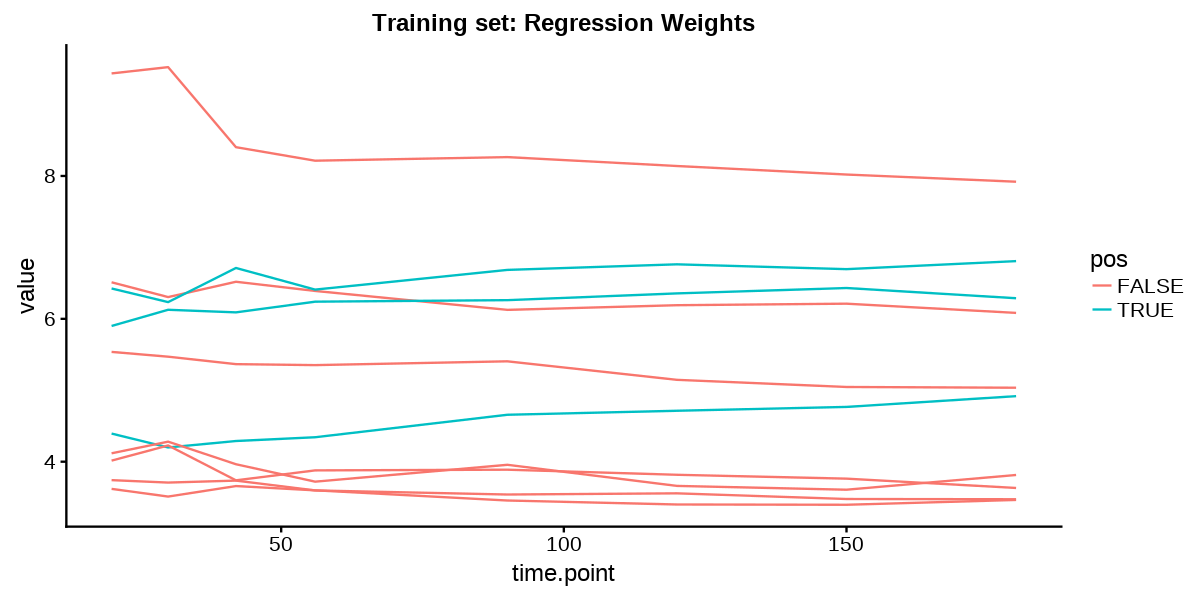

In [638]:
exprs.line = ggplot(long.pos, aes(time.point, value, group = variable, color = pos))
exprs.line + stat_summary(fun.y = mean, geom = "line", aes(group=variable)) +  ggtitle("Training set: Regression Weights") #+ ylim(3.3,4)  #+ stat_summary(fun.data = mean_cl_normal,
                                                                                  # geom="errorbar", width=0.2)#, aes(group=variable))

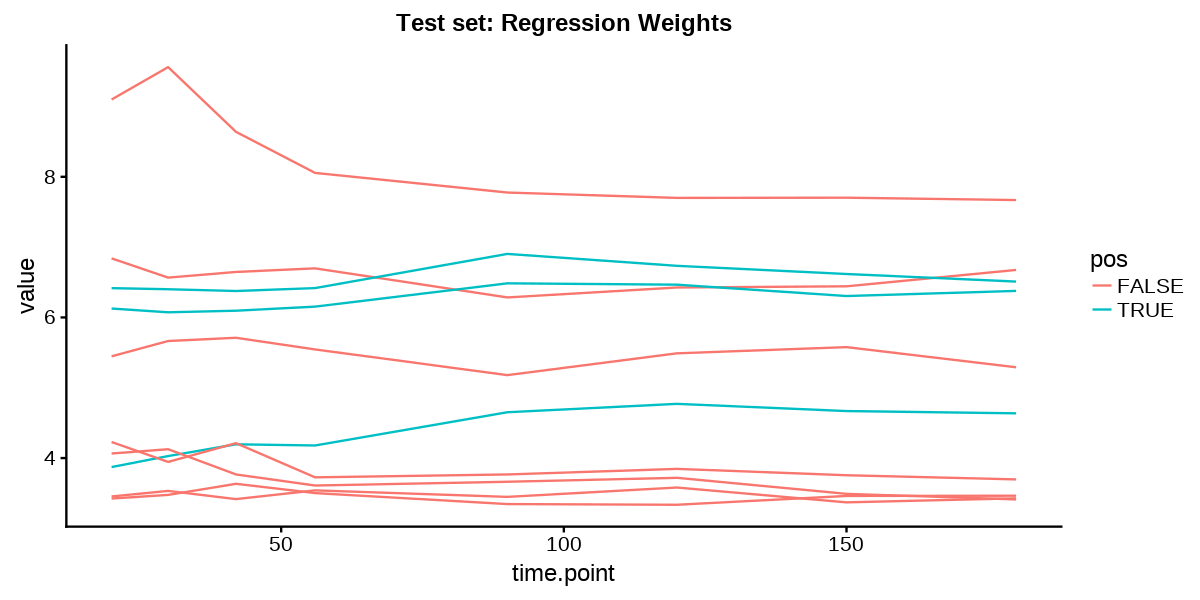

In [737]:
exprs.line = ggplot(long.pos.test, aes(time.point, value, group = variable, color = pos))
exprs.line + stat_summary(fun.y = mean, geom = "line", aes(group=variable)) +  ggtitle("Test set: Regression Weights") #+ ylim(3.3,4)  #+ stat_summary(fun.data = mean_cl_normal,
                                                                                  # geom="errorbar", width=0.2)#, aes(group=variable))

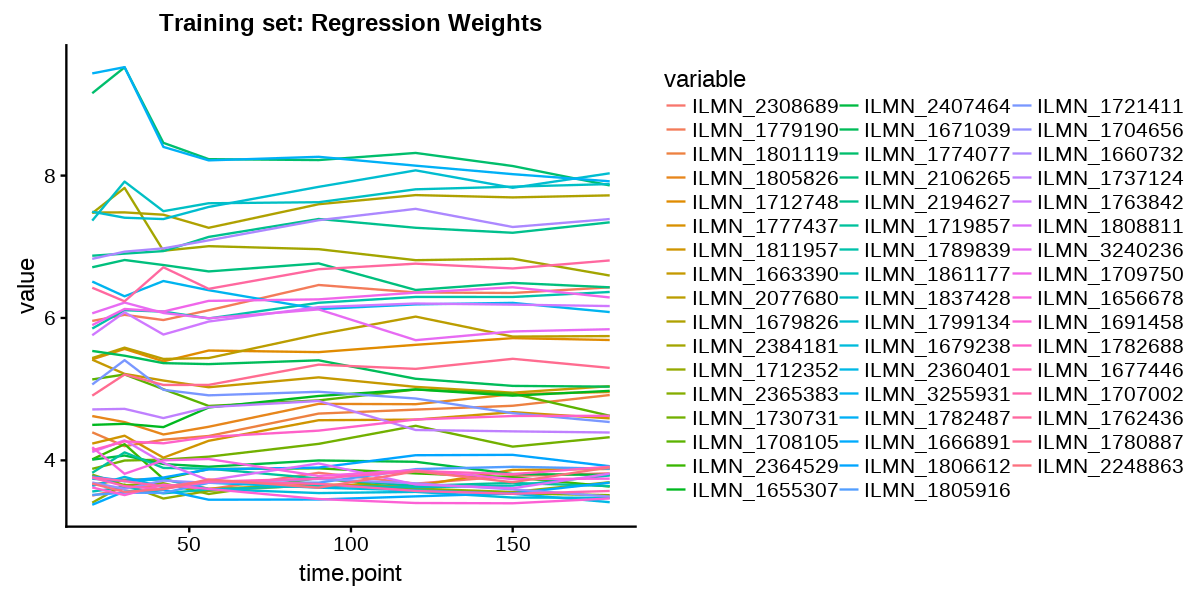

In [569]:
exprs.line = ggplot(long.exprs.r, aes(time.point, value, color = variable))
exprs.line + stat_summary(fun.y = mean, geom = "line", aes(group=variable)) +  ggtitle("Training set: Regression Weights") #+ ylim(3.3,4)  #+ stat_summary(fun.data = mean_cl_normal,
                                                                                  # geom="errorbar", width=0.2)#, aes(group=variable))

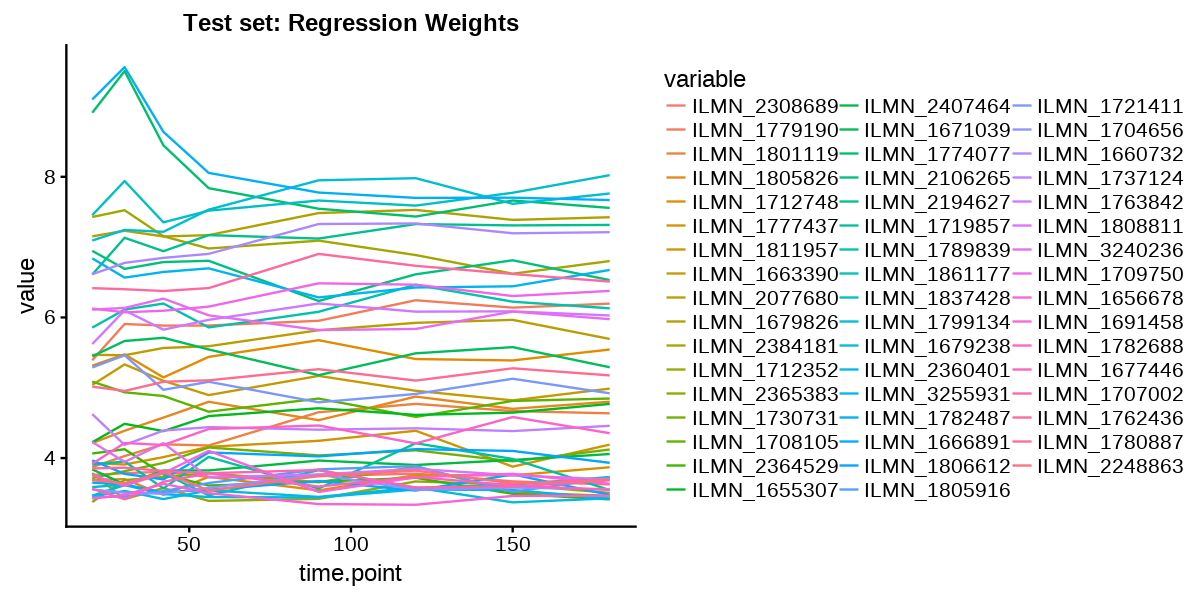

In [570]:
exprs.line.test = ggplot(long.exprs.test.r, aes(time.point, value, color = variable))
exprs.line.test + stat_summary(fun.y = mean, geom = "line", aes(group=variable)) +  ggtitle("Test set: Regression Weights") #+ ylim(3.3,4) #+ stat_summary(fun.data = mean_cl_normal,
                                                                                  # geom="errorbar", width=0.2)#, aes(group=variable))

#### Analyze top predictive genes in mice

In [ ]:
import = varImp(models$glmnet,scale=F)

In [667]:
C57.rf.regres


Call:
 randomForest(formula = Time.point.days ~ ., data = B6.table.regress) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 572

          Mean of squared residuals: 953.0969
                    % Var explained: 47.05

In [685]:
B6.rf.importance = data.frame(importance(C57.rf.regres))

Overall   
ILMN_2543688  1.0010015
ILMN_2435996  1.0010015
ILMN_2480021  1.2482716
ILMN_2734484  0.0000000
ILMN_2596761  0.0000000
ILMN_1237830  0.0000000
ILMN_2577558  0.0000000
ILMN_2960474  0.0000000
ILMN_2893564 -0.1893953
ILMN_1219820  0.0000000
ILMN_1217606  0.0000000
ILMN_1212605  0.0000000
ILMN_1218353  0.0000000
ILMN_2664993  0.0000000
ILMN_2557918 -0.5078040
ILMN_2720572  0.0000000
ILMN_2547610  0.0000000
ILMN_2479690 -1.0010015
ILMN_1219084  1.0010015
ILMN_2845839  0.0000000
ILMN_2701779  0.0000000
ILMN_2671528  0.0000000
ILMN_1222269  0.0000000
ILMN_1251065  0.0000000
ILMN_2888940 -1.0010015
ILMN_2544418 -1.0010015
ILMN_1213868  0.0000000
ILMN_1232635  0.0000000
ILMN_2693141  0.0000000
ILMN_2706014  0.0000000
⋮            ⋮         
ILMN_2483748  0.0000000
ILMN_2514674  0.0000000
ILMN_2959787  0.0000000
ILMN_2886947  0.0000000
ILMN_1254473  0.0000000
ILMN_1228653 -1.0010015
ILMN_1229216  1.0010015
ILMN_2770119 -1.0010015
ILMN_1247277  0.0000000
ILMN_2547078  0.0000000
ILMN_2524383  1.0010015
ILMN_2821501  0.0000000
ILMN_3100688  0.0000000
ILMN_2459155  1.0010015
ILMN_1252459  0.0000000
ILMN_1259424  0.0000000
ILMN_2564120  0.0000000
ILMN_2481389  0.7098211
ILMN_2481391  1.4005076
ILMN_2427108  0.1280390
ILMN_2840327  0.0000000
ILMN_1251225  0.0000000
ILMN_1245892 -1.0010015
ILMN_1256012  0.0000000
ILMN_2703621  0.7687272
ILMN_1217583  0.0000000
ILMN_1243263  0.0000000
ILMN_2960774  0.0000000
ILMN_2721919  0.9161951
ILMN_2491526  0.0000000

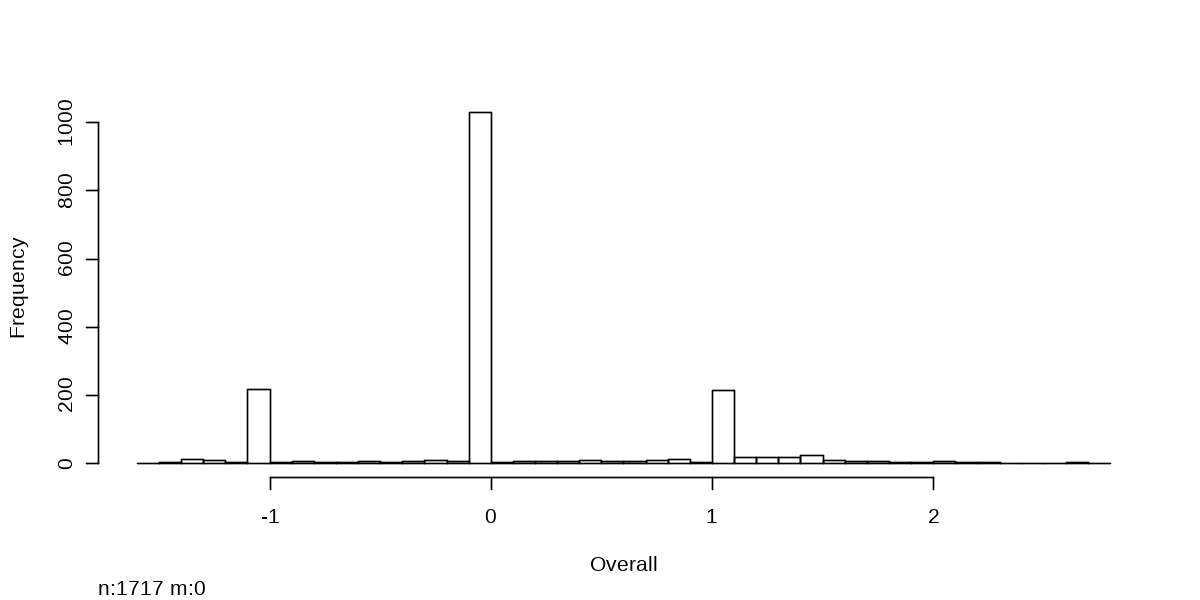

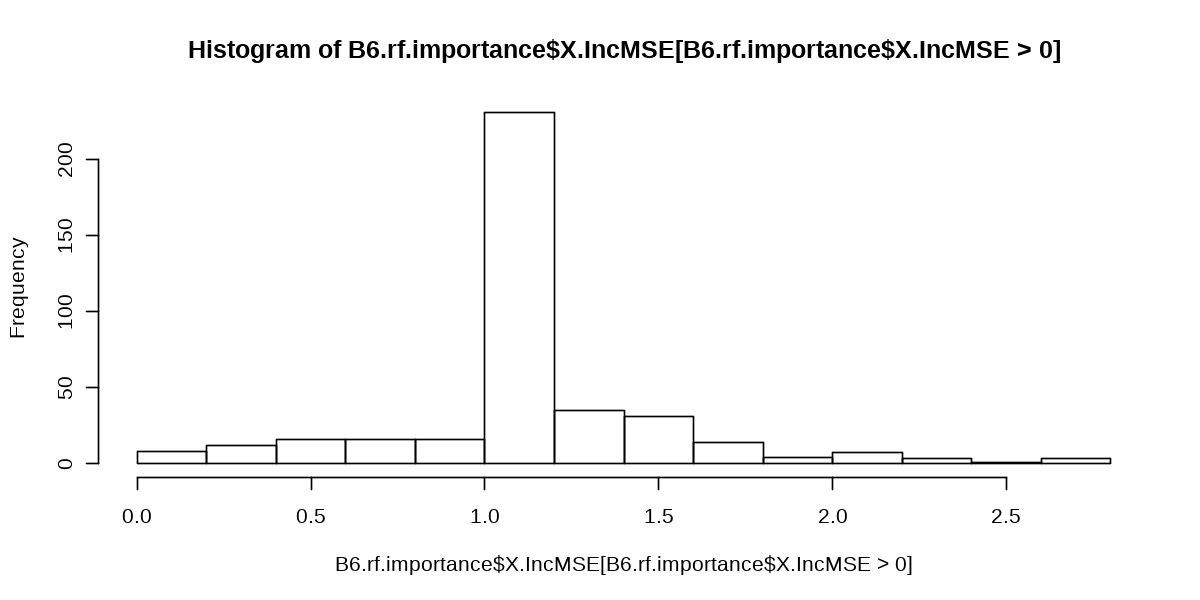

In [687]:
varImp(C57.rf.regres)
hist(varImp(C57.rf.regres))
hist(B6.rf.importance$X.IncMSE[B6.rf.importance$X.IncMSE > 0.0])



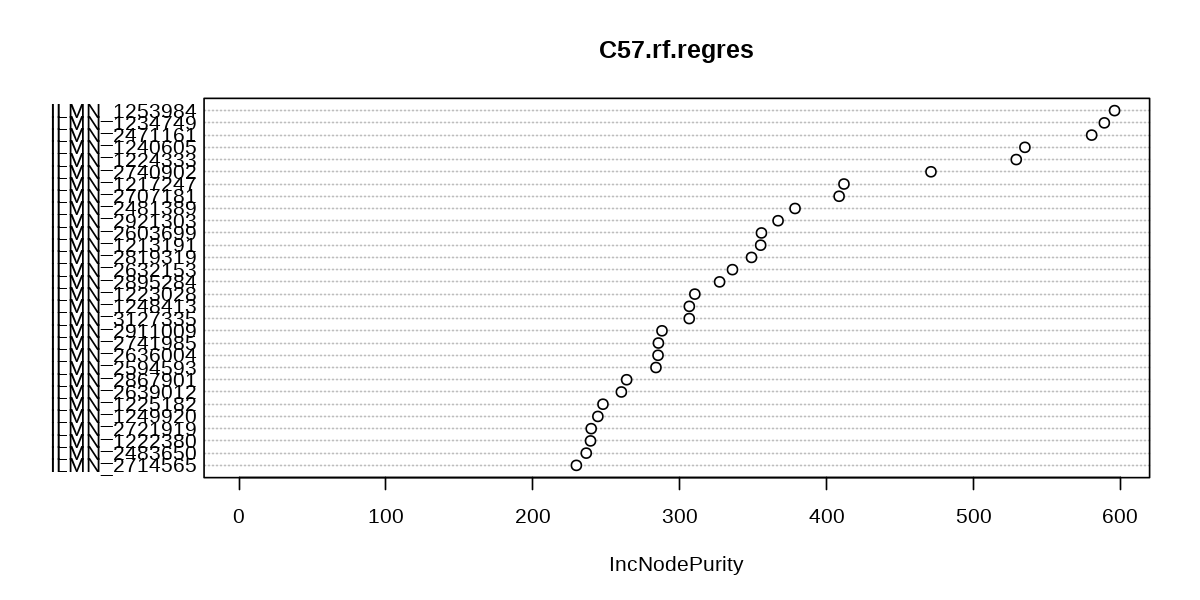

In [682]:
varImpPlot(C57.rf.regres,type=2)

ERROR: Error in hist.default(): argument "x" is missing, with no default


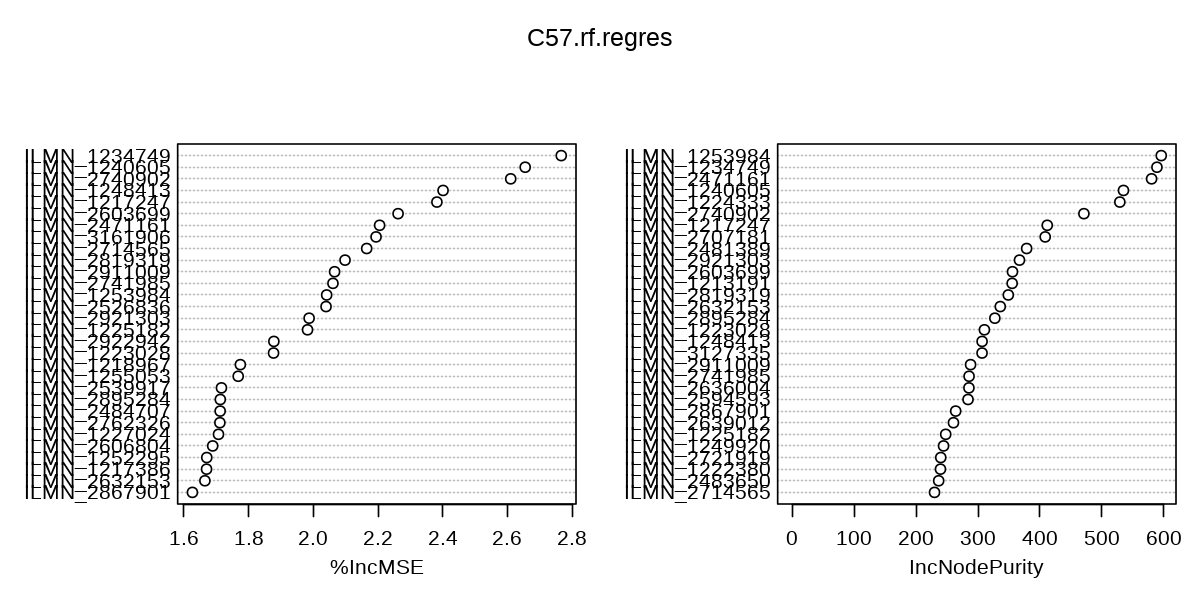

In [728]:
# I should use the lncMSE, this sight says.
#https://stats.stackexchange.com/questions/162465/in-a-random-forest-is-larger-incmse-better-or-worse
varImpPlot(C57.rf.regres)
hist()

In [ ]:
# Now graph the top 50, 10 genes for the mice. I can wait on the coloring scheme.

In [732]:
set.seed(100)
C57.rf.regres.imp = randomForest(Time.point.days~., data=B6.table.regress, importance=T)
B6.regres.imp = data.frame(importance(C57.rf.regres.imp))
impvar = rownames(B6.regres.imp)[order(B6.regres.imp[,1], decreasing=TRUE)]

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”

In [729]:
which(impvar == "ILMN_1234749")

[1] 86

In [733]:
impvar

[1] "ILMN_1234749" "ILMN_1240605" "ILMN_2740902" "ILMN_1248413"
   [5] "ILMN_1217247" "ILMN_2603699" "ILMN_2471161" "ILMN_3161906"
   [9] "ILMN_2714565" "ILMN_2819319" "ILMN_2911009" "ILMN_2741985"
  [13] "ILMN_1253984" "ILMN_2526836" "ILMN_2921303" "ILMN_1225182"
  [17] "ILMN_2922942" "ILMN_1223028" "ILMN_1218967" "ILMN_1255053"
  [21] "ILMN_2539917" "ILMN_2895284" "ILMN_2484707" "ILMN_2762326"
  [25] "ILMN_1227024" "ILMN_2606804" "ILMN_1252295" "ILMN_1217386"
  [29] "ILMN_2632153" "ILMN_2867901" "ILMN_2756704" "ILMN_1229500"
  [33] "ILMN_2420939" "ILMN_2982019" "ILMN_1222380" "ILMN_1213191"
  [37] "ILMN_1248849" "ILMN_2446999" "ILMN_2707181" "ILMN_2639012"
  [41] "ILMN_2706819" "ILMN_3127335" "ILMN_2762983" "ILMN_1252006"
  [45] "ILMN_2593631" "ILMN_2711112" "ILMN_2776857" "ILMN_2991272"
  [49] "ILMN_1257574" "ILMN_1248830" "ILMN_1242258" "ILMN_2625601"
  [53] "ILMN_2656021" "ILMN_1246004" "ILMN_1241039" "ILMN_1217577"
  [57] "ILMN_2711355" "ILMN_1219574" "ILMN_1253384" "ILMN_2670368"
  [61] "ILMN_2629581" "ILMN_2628708" "ILMN_2481391" "ILMN_1259252"
  [65] "ILMN_1246270" "ILMN_1220039" "ILMN_2688912" "ILMN_2655862"
  [69] "ILMN_2454339" "ILMN_2608719" "ILMN_2593994" "ILMN_2944755"
  [73] "ILMN_2657844" "ILMN_2970532" "ILMN_2756046" "ILMN_1223045"
  [77] "ILMN_1244454" "ILMN_3161959" "ILMN_2802311" "ILMN_2514749"
  [81] "ILMN_1237804" "ILMN_2659317" "ILMN_3157081" "ILMN_2688262"
  [85] "ILMN_1240819" "ILMN_2747641" "ILMN_2633179" "ILMN_2636110"
  [89] "ILMN_2480021" "ILMN_2719473" "ILMN_2652482" "ILMN_2445789"
  [93] "ILMN_2581419" "ILMN_2685921" "ILMN_1242553" "ILMN_1226839"
  [97] "ILMN_2964324" "ILMN_1229210" "ILMN_2575986" "ILMN_2632712"
 [101] "ILMN_2420353" "ILMN_2747959" "ILMN_1216107" "ILMN_1239314"
 [105] "ILMN_2854962" "ILMN_2589640" "ILMN_2737523" "ILMN_2748880"
 [109] "ILMN_2612206" "ILMN_1226979" "ILMN_2475271" "ILMN_2725595"
 [113] "ILMN_2742626" "ILMN_3071356" "ILMN_2507232" "ILMN_2543393"
 [117] "ILMN_3111744" "ILMN_1223979" "ILMN_2619107" "ILMN_2681241"
 [121] "ILMN_2959372" "ILMN_2836749" "ILMN_2685392" "ILMN_2636004"
 [125] "ILMN_1246446" "ILMN_2524667" "ILMN_2555071" "ILMN_3155815"
 [129] "ILMN_1249864" "ILMN_1233713" "ILMN_2500533" "ILMN_2962737"
 [133] "ILMN_2676056" "ILMN_1249378" "ILMN_2568571" "ILMN_1255190"
 [137] "ILMN_2646052" "ILMN_3043036" "ILMN_2595477" "ILMN_2833652"
 [141] "ILMN_2644708" "ILMN_2629663" "ILMN_2652877" "ILMN_2815506"
 [145] "ILMN_1235488" "ILMN_1244513" "ILMN_2793638" "ILMN_1221028"
 [149] "ILMN_2736489" "ILMN_2729197" "ILMN_2981801" "ILMN_1249824"
 [153] "ILMN_2682613" "ILMN_1255514" "ILMN_2773153" "ILMN_2691014"
 [157] "ILMN_2605201" "ILMN_2648475" "ILMN_2536184" "ILMN_1223708"
 [161] "ILMN_2652500" "ILMN_2589073" "ILMN_2798993" "ILMN_1247787"
 [165] "ILMN_2577039" "ILMN_2621021" "ILMN_1227403" "ILMN_2662450"
 [169] "ILMN_2731901" "ILMN_2772632" "ILMN_3163124" "ILMN_2605465"
 [173] "ILMN_1247947" "ILMN_2601378" "ILMN_2426853" "ILMN_3161250"
 [177] "ILMN_2543688" "ILMN_2435996" "ILMN_1219084" "ILMN_2706468"
 [181] "ILMN_2522460" "ILMN_1244904" "ILMN_2427777" "ILMN_2736038"
 [185] "ILMN_2473811" "ILMN_1227464" "ILMN_1233811" "ILMN_1216275"
 [189] "ILMN_2748150" "ILMN_2513205" "ILMN_2788036" "ILMN_2595597"
 [193] "ILMN_2718681" "ILMN_1252111" "ILMN_1233759" "ILMN_2910684"
 [197] "ILMN_1222069" "ILMN_2591592" "ILMN_2660555" "ILMN_2648346"
 [201] "ILMN_2825826" "ILMN_2710286" "ILMN_1216584" "ILMN_2567911"
 [205] "ILMN_3070701" "ILMN_2674140" "ILMN_2698767" "ILMN_2787871"
 [209] "ILMN_1243616" "ILMN_1234999" "ILMN_2821788" "ILMN_1230853"
 [213] "ILMN_1228320" "ILMN_2615920" "ILMN_1258341" "ILMN_2687165"
 [217] "ILMN_2653132" "ILMN_2600964" "ILMN_2858359" "ILMN_1223929"
 [221] "ILMN_1239933" "ILMN_2599527" "ILMN_1244797" "ILMN_1218547"
 [225] "ILMN_2708920" "ILMN_2692316" "ILMN_2550962" "ILMN_1256943"
 [229] "ILMN_2604423" "ILMN_1219258" "ILMN_2641038" "ILMN_2770968"
 [233] "ILMN_2663604" "ILMN_2610944" "ILMN_1244866" "ILMN_2862465"
 [237] "ILMN_2787817" "ILMN_2901112" "ILMN_1219670

In [734]:
length(impvar)
#expres.train.point.genes.r = expres.train.point[,colnames(expres.train.point) %in% c(as.character(genes.coefs.r), "time.point")]
#expres.test.point.genes.r = expres.test.point[,colnames(expres.test.point) %in% c(as.character(genes.coefs.r), "time.point")]
ngenes = 50

B6.table.regress.top50 = B6.table.regress[,colnames(B6.table.regress) %in% c(impvar[1:ngenes], "Time.point.days")]
B6.table.regress.top10 = B6.table.regress[,colnames(B6.table.regress) %in% c(impvar[1:10], "Time.point.days")]
#expres.train.point
dim(expres.train.point.genes.r)

B6.longtable.top50 = melt(B6.table.regress.top50,
                  id = c("Time.point.days"),
                 measured = colnames(B6.table.regress.top50)[1:ngenes])
B6.longtable.top10 = melt(B6.table.regress.top10,
                  id = c("Time.point.days"),
                 measured = colnames(B6.table.regress.top10)[1:ngenes])


[1] 1717

[1] 210  11

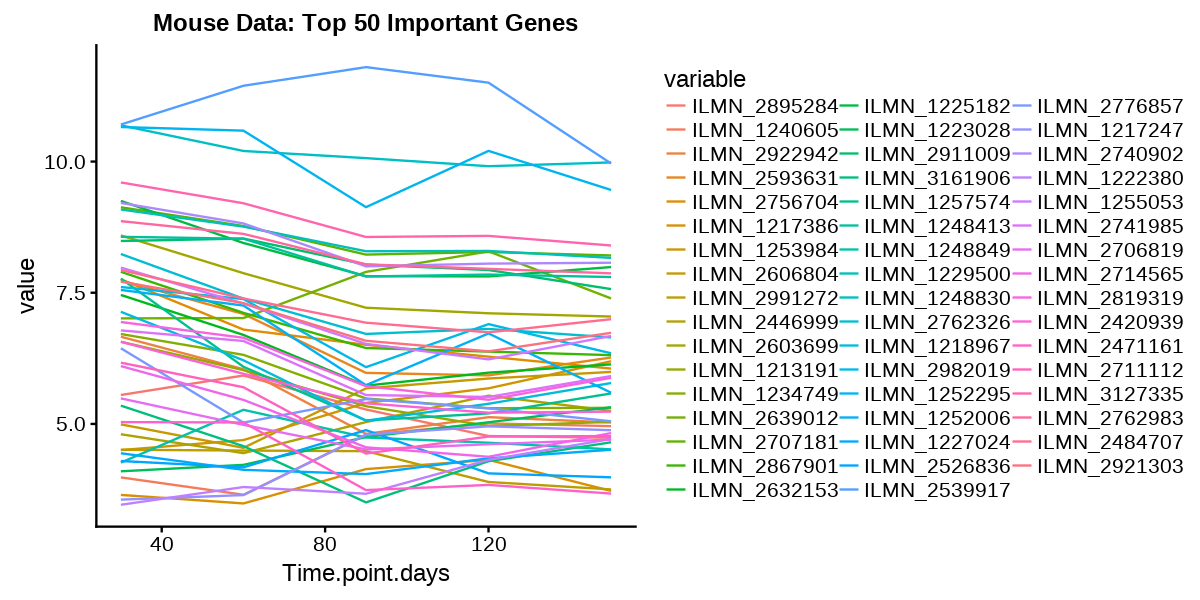

In [735]:
exprs.line.mouse = ggplot(B6.longtable.top50, aes(Time.point.days, value, color = variable))
exprs.line.mouse + stat_summary(fun.y = mean, geom = "line", aes(group=variable)) +  ggtitle("Mouse Data: Top 50 Important Genes") #+ ylim(3.3,4)  #+ stat_summary(fun.data = mean_cl_normal,
                                                                                  # geom="errorbar", width=0.2)#, aes(group=variable))

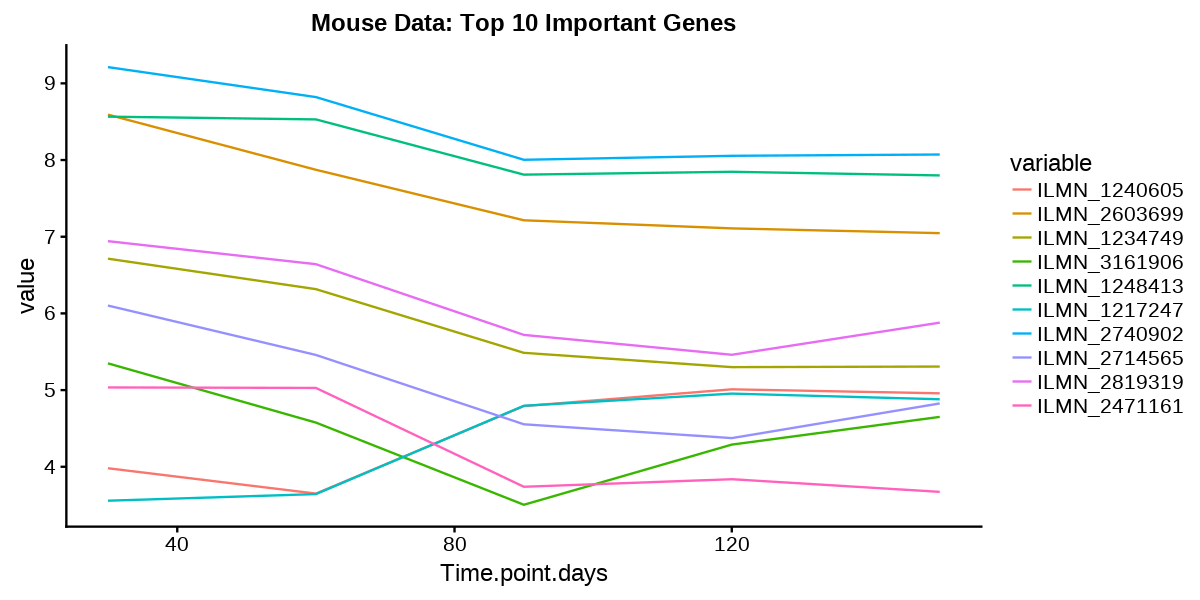

In [736]:
exprs.line.mouse = ggplot(B6.longtable.top10, aes(Time.point.days, value, color = variable))
exprs.line.mouse + stat_summary(fun.y = mean, geom = "line", aes(group=variable)) +  ggtitle("Mouse Data: Top 10 Important Genes") #+ ylim(3.3,4)  #+ stat_summary(fun.data = mean_cl_normal,
                                                                                  # geom="errorbar", width=0.2)#, aes(group=variable))

In [723]:
impvar[1:10]

[1] "ILMN_1240605" "ILMN_1217247" "ILMN_2471161" "ILMN_2603699" "ILMN_2922942"
 [6] "ILMN_1255053" "ILMN_2651144" "ILMN_2911009" "ILMN_1248413" "ILMN_2593631"

### Human Analysis